# Study Colors of isolated objects


ColorIsolatedObjects.ipynb:
The goal is to generate a non-buggy list of colored objects in order to have the correct color distribution.
The original list **list_of_isolatedobjects.csv** produced by **MultiColor_lightCurves-DMRehearsal2024_01-AuxTel.ipynb** had a bug.

Now this notebook produce the file to use **isolated_objects_magandcolors_psfap_good.csv** from the original source files **sources_objectTable-t3864-multibands-o(.*)-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146.csv**
in folder **data/photom/sources_objectTable**.

- author : Sylvie Dagoret-Campagne
- creation : 2024-08-01
- update : 2024-08-02 : number id of object + add (ra,dec)
- last update : 2024-09-05 : add comment
- last update : 2024-09-08 : add number of object
- last update : 2024-09-09 : the aperture photometry mags were not the calibrated one. Fix that bug and Check.

In [1]:
import os
import astropy.units as u
import numpy as np 
import pandas as pd
pd.options.mode.chained_assignment = None
pd.set_option("display.max_columns", None)
from astropy.time import Time

import scipy.stats

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib import pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm,SymLogNorm
from matplotlib.patches import Circle,Annulus


from astropy.stats import SigmaClip

In [2]:
from astropy.io import fits
from astropy.wcs import WCS


import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option('display.max_rows', 100)

import matplotlib.ticker                         # here's where the formatter is
import os
import re
import pandas as pd
import pickle
from collections import OrderedDict

plt.rcParams["figure.figsize"] = (4,3)
plt.rcParams["axes.labelsize"] = 'xx-large'
plt.rcParams['axes.titlesize'] = 'xx-large'
plt.rcParams['xtick.labelsize']= 'xx-large'
plt.rcParams['ytick.labelsize']= 'xx-large'

import scipy
from scipy.optimize import curve_fit

In [3]:
def convert_fluxtomag(x) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    return -2.50 * np.log10(x) + 31.4

In [4]:
def convert_fluxtomagerr(row) :
    """
    The object and source catalogs store only fluxes. There are hundreds of flux-related columns, 
    and to store them also as magnitudes would be redundant, and a waste of space.
    All flux units are nanojanskys. The AB Magnitudes Wikipedia page provides a concise resource 
    for users unfamiliar with AB magnitudes and jansky fluxes. To convert to AB magnitudes use:
    As demonstrated in Section 2.3.2, to add columns of magnitudes after retrieving columns of flux, users can do this:
    results_table['r_calibMag'] = -2.50 * numpy.log10(results_table['r_calibFlux']) + 31.4
    results_table['r_cModelMag'] = -2.50 * numpy.log10(results_table['r_cModelFlux']) + 31.4
    (from DP0 tutorial)
    """
    x= row["apFlux_35_0_instFlux"]
    dx = row["apFlux_35_0_instFluxErr"]
    mag =  -2.50 * np.log10(x) + 31.4
    emag = 2.5/np.log(10)*dx/x
    return mag,emag

In [5]:
def get_df_perband(df):
    dfg = df[df.band == "g"]
    dfr = df[df.band == "r"]
    dfi = df[df.band == "i"]
    dfz = df[df.band == "z"]
    dfy = df[df.band == "y"]
    return (dfg,dfr,dfi,dfz,dfy)

In [6]:
def get_df_median(df,ctag="mag"):
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)
    medg = dfg[ctag].median()
    medr = dfr[ctag].median()
    medi = dfi[ctag].median()
    medz = dfz[ctag].median()
    medy = dfy[ctag].median()
    return (medg,medr,medi,medz,medy)    

In [7]:
def get_df_sigma(df,ctag="mag"):
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)   
    (medg,medr,medi,medz,medy) = get_df_median(df,ctag)
    
    #dfg["sigma"] = (dfg[tag]- medg)**2
    dfg.loc[:,"sigma"] = dfg.apply( lambda row : (row[ctag]- medg)**2,axis=1,result_type="expand")
    dfr["sigma"] = dfr.apply( lambda row : (row[ctag]- medr)**2,axis=1,result_type="expand")
    if len(dfi)>0:
        flag_dfi = True
        dfi["sigma"] = dfi.apply( lambda row : (row[ctag]- medi)**2,axis=1,result_type="expand")
    else:
        flag_dfi = False
    dfz["sigma"] = dfz.apply( lambda row : (row[ctag]- medz)**2,axis=1,result_type="expand")
    dfy["sigma"] = dfy.apply( lambda row : (row[ctag]- medy)**2,axis=1,result_type="expand")
    
    sigg = np.sqrt(dfg["sigma"].mean())
    sigr = np.sqrt(dfr["sigma"].mean())
    if flag_dfi:
        sigi = np.sqrt(dfi["sigma"].mean())
    else:
        sigi = 0
    sigz = np.sqrt(dfz["sigma"].mean())
    sigy = np.sqrt(dfy["sigma"].mean())
    return (sigg,sigr,sigi,sigz,sigy)

    

In [8]:
def plothistogram_magperband(df):
    objectnum = df["obj_index"].unique()[0]
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)

    (medg,medr,medi,medz,medy) = get_df_median(df)
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(df)
    
    fig,axs = plt.subplots(1,5,figsize=(16,3))
    axes = axs.flatten()
    
    label = f"$\sigma = $ {sigg*1000:.2f} mmag"
    dfg["mag"].plot.hist(ax=axes[0],bins=20,facecolor="g",xlabel="mag")
    axes[0].axvline(medg,color="b",lw=3)
    axes[0].set_title(label)

    label = f"$\sigma = $ {sigr*1000:.2f} mmag"
    dfr["mag"].plot.hist(ax=axes[1],bins=20,facecolor="r",xlabel="mag")
    axes[1].axvline(medr,color="b",lw=3)
    axes[1].set_title(label)

    label = f"$\sigma = $ {sigi*1000:.2f} mmag"
    dfi["mag"].plot.hist(ax=axes[2],bins=20,facecolor="y",xlabel="mag")
    axes[2].axvline(medi,color="b",lw=3)
    axes[2].set_title(label)

    label = f"$\sigma = $ {sigz*1000:.2f} mmag"
    dfz["mag"].plot.hist(ax=axes[3],bins=20,facecolor="grey",xlabel="mag")
    axes[3].axvline(medz,color="b",lw=3)
    axes[3].set_title(label)

    label = f"$\sigma = $ {sigy*1000:.2f} mmag"
    dfy["mag"].plot.hist(ax=axes[4],bins=20,facecolor="k",xlabel="mag")
    axes[4].axvline(medy,color="b",lw=3)
    axes[4].set_title(label)

    title = f"object {objectnum}"
    plt.suptitle(title,fontsize=14,fontweight="bold")
    plt.tight_layout()
    plt.show()
       

In [9]:
def plothistogram_valperband(df,ctag):
    objectnum = df["obj_index"].unique()[0]
    dfg,dfr,dfi,dfz,dfy = get_df_perband(df)

    (medg,medr,medi,medz,medy) = get_df_median(df,ctag)
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(df,ctag)
    
    fig,axs = plt.subplots(1,5,figsize=(16,3))
    axes = axs.flatten()
    
    label = f"$\sigma = $ {sigg*1000:.2f} mmag"
    dfg[ctag].plot.hist(ax=axes[0],bins=20,facecolor="g",xlabel="mag")
    axes[0].axvline(medg,color="b",lw=3)
    axes[0].set_title(label)

    label = f"$\sigma = $ {sigr*1000:.2f} mmag"
    dfr[ctag].plot.hist(ax=axes[1],bins=20,facecolor="r",xlabel="mag")
    axes[1].axvline(medr,color="b",lw=3)
    axes[1].set_title(label)

    label = f"$\sigma = $ {sigi*1000:.2f} mmag"
    dfi[ctag].plot.hist(ax=axes[2],bins=20,facecolor="y",xlabel="mag")
    axes[2].axvline(medi,color="b",lw=3)
    axes[2].set_title(label)

    label = f"$\sigma = $ {sigz*1000:.2f} mmag"
    dfz[ctag].plot.hist(ax=axes[3],bins=20,facecolor="grey",xlabel="mag")
    axes[3].axvline(medz,color="b",lw=3)
    axes[3].set_title(label)

    label = f"$\sigma = $ {sigy*1000:.2f} mmag"
    dfy[ctag].plot.hist(ax=axes[4],bins=20,facecolor="k",xlabel="mag")
    axes[4].axvline(medy,color="b",lw=3)
    axes[4].set_title(label)

    title = f"object {objectnum}"
    plt.suptitle(title,fontsize=14,fontweight="bold")
    plt.tight_layout()
    plt.show()
       

## Config

In [10]:
path = "data/photom/sources_objectTable"

## Find input files

In [11]:
list_of_files = os.listdir(path) 
list_of_files = sorted(list_of_files)

In [12]:
tag = "^sources_objectTable-t3864-multibands-o(.*)-LATISS_runs_AUXTEL_DRP_IMAGING_20230509_20240513_w_2024_20_PREOPS-5146.csv$"
selected_files = []
selected_objectnum = []
for filename in list_of_files: 
    result = re.findall(tag,filename)
    if len(result)>0:
        num = int(result[0])
        selected_objectnum.append(num)
        selected_files.append(filename) 
        
selected_objectnum = np.array(selected_objectnum)
selected_files = np.array(selected_files)

In [13]:
index_sorted = np.argsort(selected_objectnum)
selected_objectnum = selected_objectnum[index_sorted] 
selected_files = selected_files[index_sorted]
N = len(selected_files)

## Read pandas dataframe

In [14]:
all_df = []
for index,filename in enumerate(selected_files):
    fullfilename = os.path.join(path,filename)
    df = pd.read_csv(fullfilename,index_col=0)
    # calculate the magnitude I want
    df[["mag","emag"]] = df.apply(lambda row : convert_fluxtomagerr(row), axis=1,result_type = 'expand')
    all_df.append(df)

## Study magnitudes

In [15]:
index = 0
objectnum = selected_objectnum[index] 

In [16]:
the_df = all_df[index]

In [17]:
the_df.head()

sourceId       psfFlux    psfFluxErr  psfFlux_flag  \
500  178737290963583254  2.765022e+06  15732.080763         False   
517  178737292037325173  3.796435e+06  23732.628633         False   
571  179300079855730924  1.796155e+06  10096.104952         False   
597  179300080929472885  2.680370e+06  12990.442686         False   
625  179300084150698237  1.751206e+06   9148.919699         False   

     psfFlux_apCorr  psfFlux_apCorrErr  extendedness  detect_isPrimary  \
500        0.996067                0.0           0.0              True   
517        1.008703                0.0           0.0              True   
571        1.004340                0.0           0.0              True   
597        0.969370                0.0           0.0              True   
625        0.983773                0.0           0.0              True   

     deblend_skipped  gaussianFlux  gaussianFluxErr  gaussianFlux_flag  \
500            False  2.752271e+06     18712.172330              False   
517            False  3.807841e+06     28966.492744              False   
571            False  1.787261e+06     11891.257391              False   
597            False  2.669753e+06     14937.369511              False   
625            False  1.740024e+06     10483.528612              False   

     localPhotoCalib  localPhotoCalibErr  localPhotoCalib_flag  index  \
500        40.851923            0.065515                 False    277   
517        67.631085            0.124960                 False    372   
571        22.695517            0.059906                 False    235   
597        26.823090            0.066885                 False    372   
625        22.655672            0.042922                 False    252   

             visit  detector          ra        dec   physical_filter band  \
500  2023112900634         0  122.458937 -36.203402  SDSSr_65mm~empty    r   
517  2023112900635         0  122.458931 -36.203406  SDSSz_65mm~empty    z   
571  2023121500484         0  122.458938 -36.203409  SDSSg_65mm~empty    g   
597  2023121500485         0  122.458938 -36.203409  SDSSr_65mm~empty    r   
625  2023121500488         0  122.458942 -36.203410  SDSSg_65mm~empty    g   

     apFlux_35_0_instFlux  apFlux_35_0_instFluxErr            x            y  \
500          69453.830451               617.503044  2380.238795  2116.264594   
517          56130.541188               613.347312  2383.284906  2110.487447   
571          80049.336172               600.286968  2174.069843  2550.197946   
597         104391.030913               626.890504  2173.847999  2550.820067   
625          78502.204074               614.182786  1624.215327  2557.996359   

     apFlux_50_0_instFlux  apFlux_50_0_instFluxErr  apFlux_50_0_flag  \
500          72059.884913               845.132886             False   
517          57039.628103               844.669879             False   
571          83626.365591               813.039061             False   
597         106861.241293               838.206922             False   
625          81003.260634               834.549678             False   

     localBackground_instFlux  localBackground_flag  source_row  obj_index  \
500                  0.354473                 False         277         64   
517                  0.185647                 False         372         64   
571                  0.430589                 False         235         64   
597                  0.518708                 False         372         64   
625                  0.268325                 False         252         64   

          psfSn     psfMag  psfMagErr  apFlux_35_0_calFlux  \
500  175.756939  15.295753   0.006177         2.837323e+06   
517  159.966879  14.951560   0.006787         3.796169e+06   
571  177.905722  15.764141   0.006103         1.816761e+06   
597  206.334006  15.329513   0.005262         2.800090e+06   
625  191.411245  15.791657   0.005672         1.778520e+06   

     apFlux_35_0_calFluxErr  apFlux_35_0_calMa

In [18]:
#list(the_df.columns)

In [19]:
the_df["diffmag"]=(the_df['psfMag']-the_df['apFlux_35_0_calMag'])*1000

<Axes: >

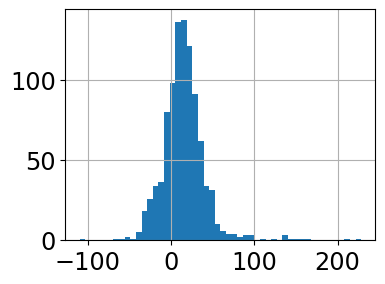

In [20]:
the_df["diffmag"].hist(bins=50)

In [21]:
#plothistogram_magperband(the_df)

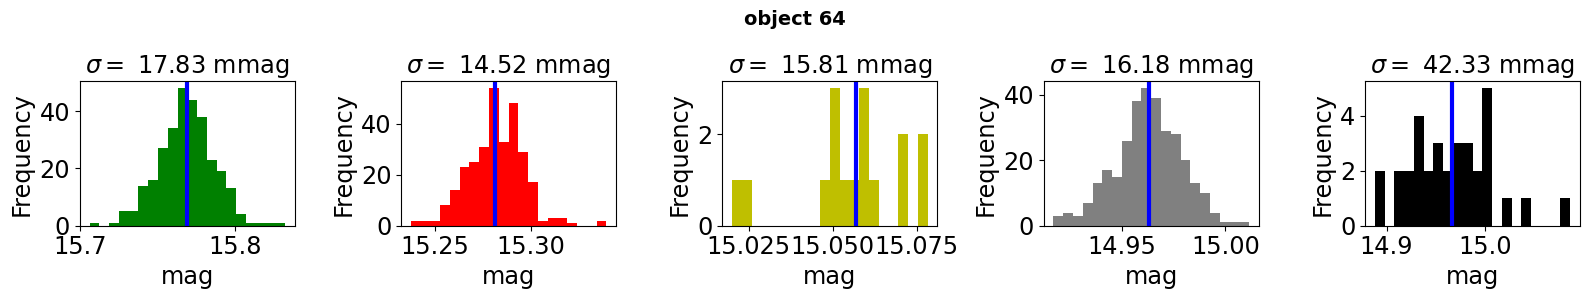

In [22]:
# psf flux
#plothistogram_valperband(the_df,ctag="psfMag")
# calibrated aperture flux
plothistogram_valperband(the_df,ctag="apFlux_35_0_calMag")

In [23]:
dfg,dfr,dfi,dfz,dfy = get_df_perband(the_df)   
(medg,medr,medi,medz,medy) = get_df_median(the_df,ctag="apFlux_35_0_calMag")
(sigg,sigr,sigi,sigz,sigy) = get_df_sigma(the_df,ctag="apFlux_35_0_calMag")

## Create pandas dataframe on Calibrated aperture photometry for isolated objects data

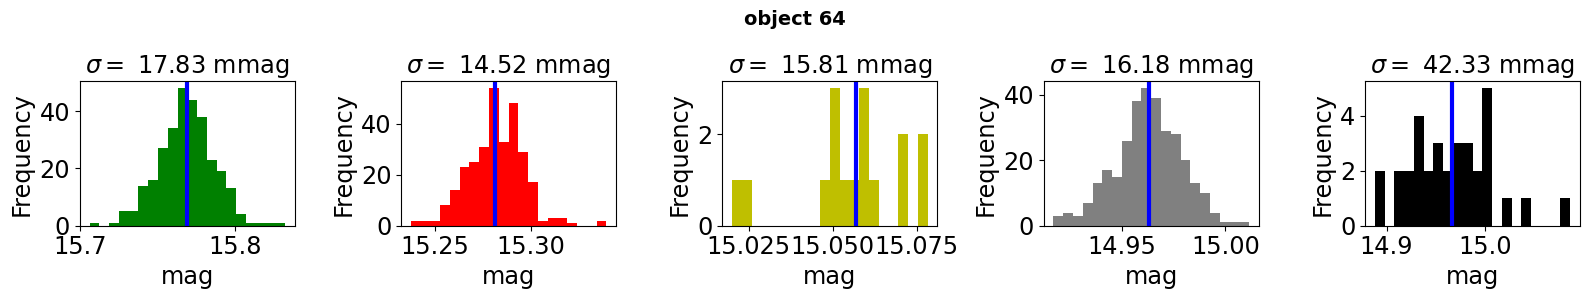

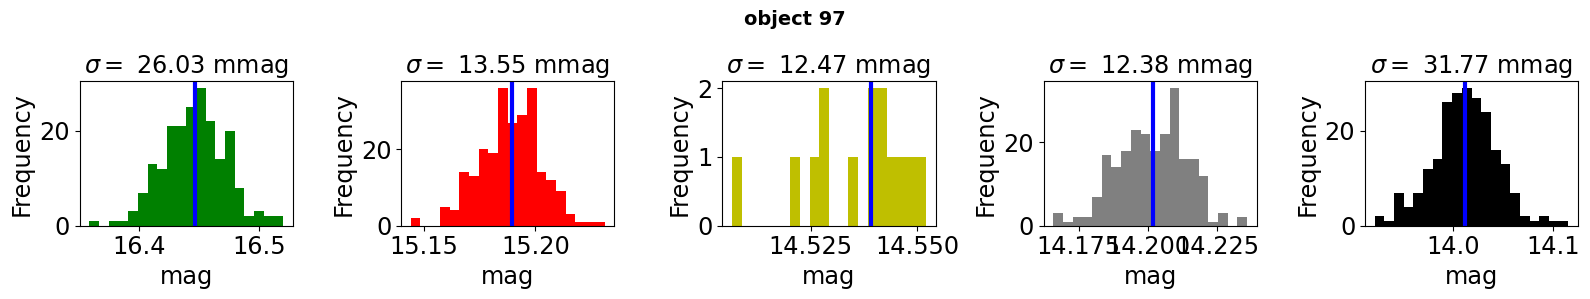

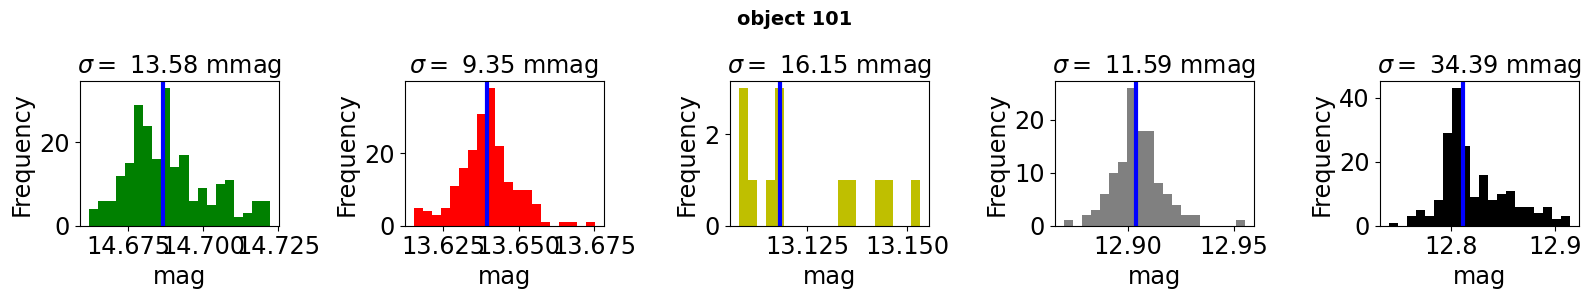

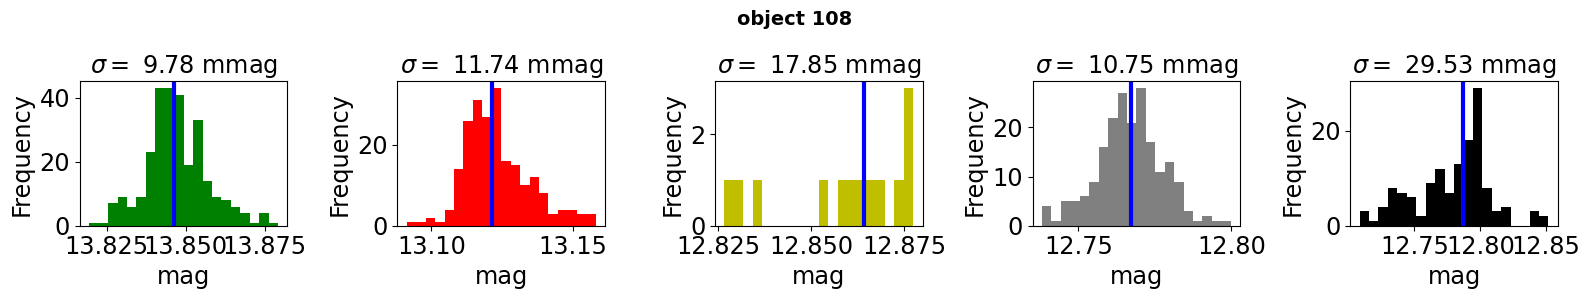

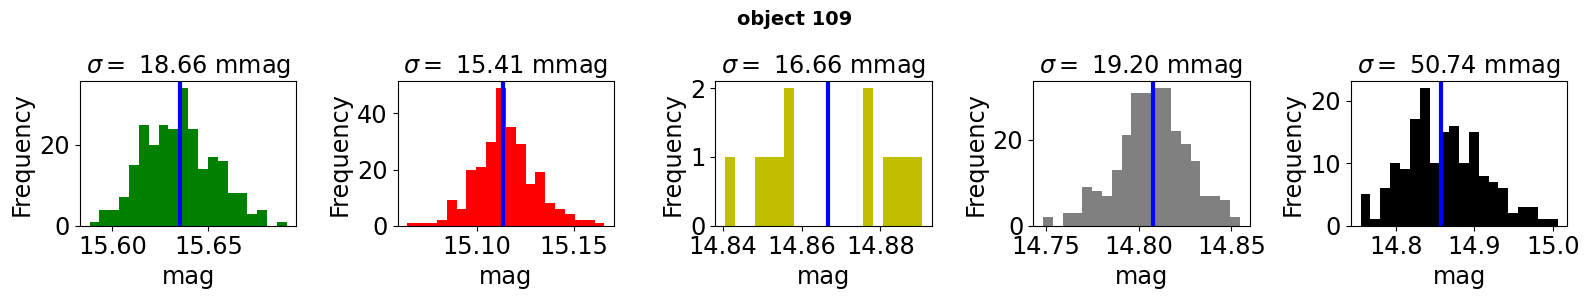

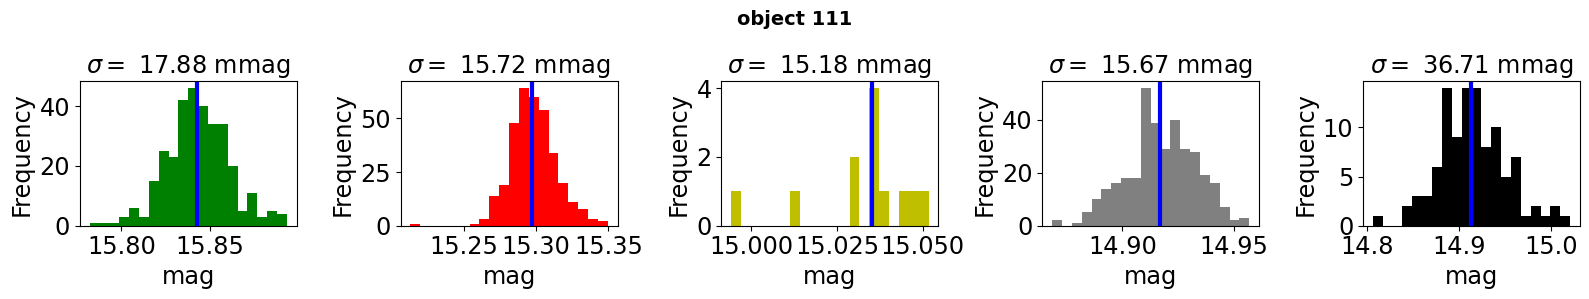

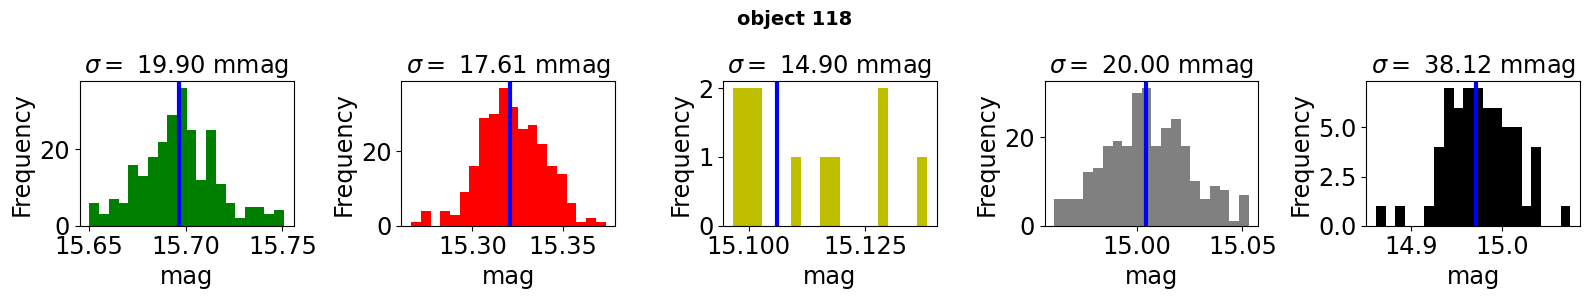

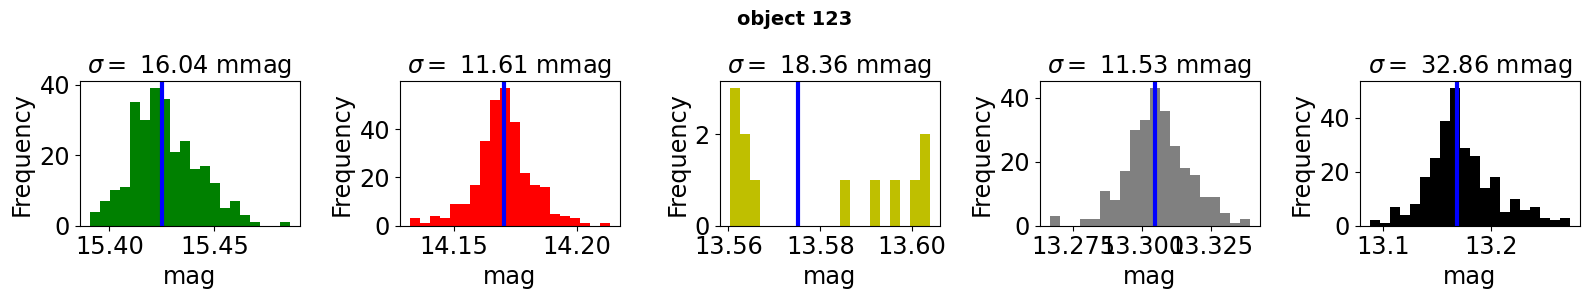

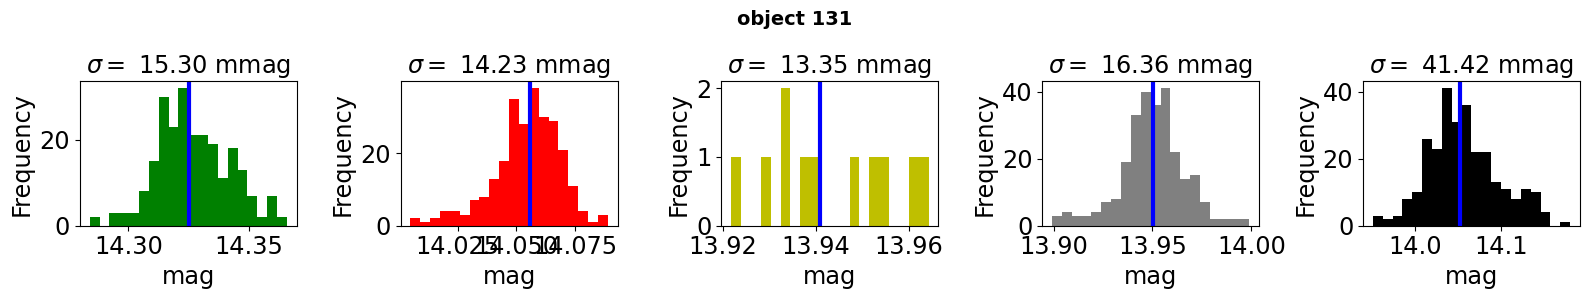

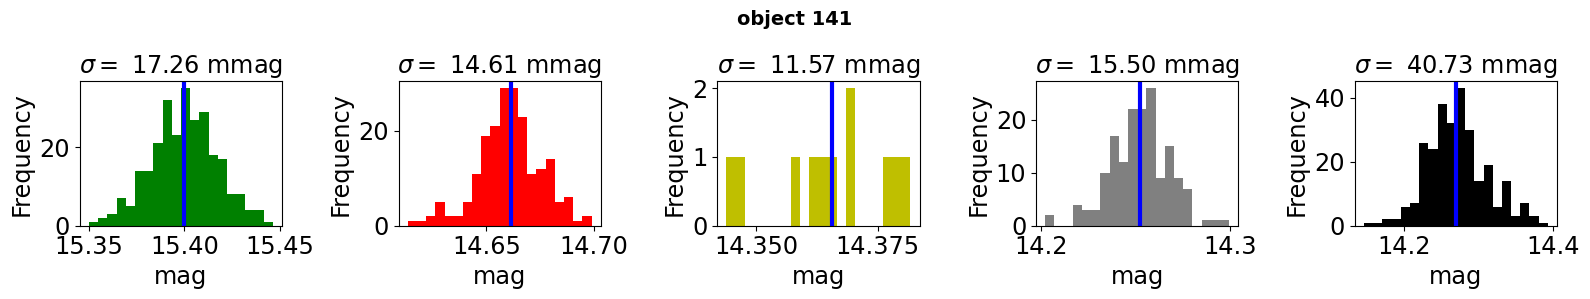

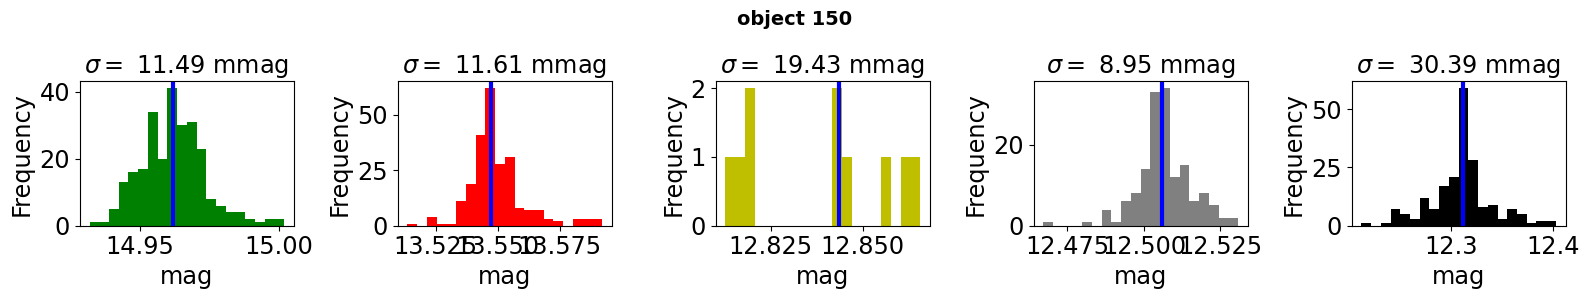

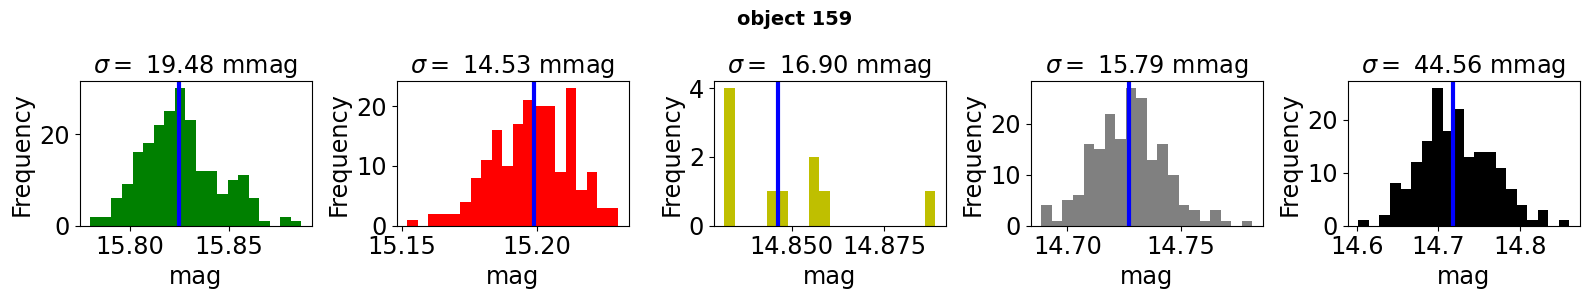

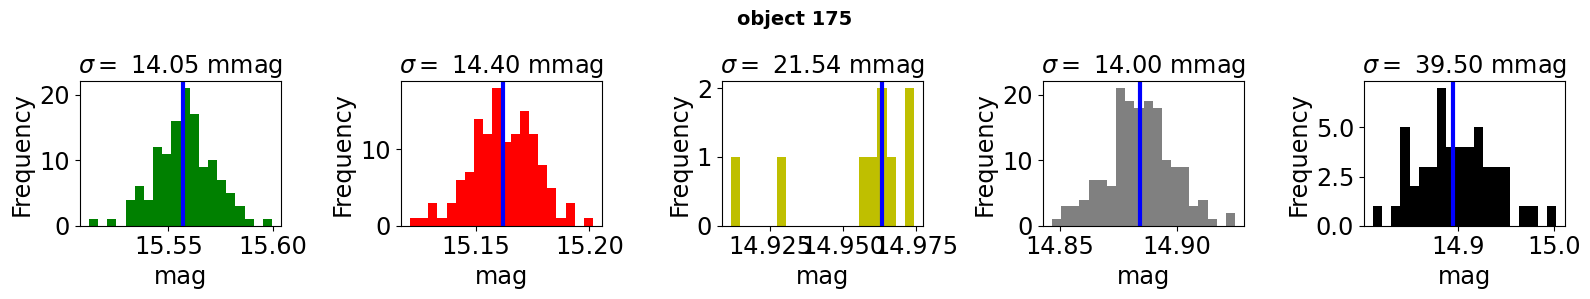

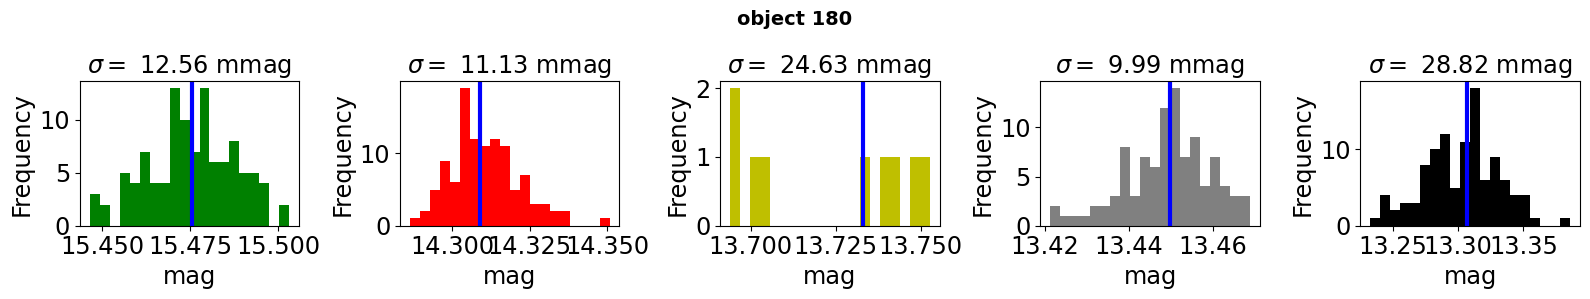

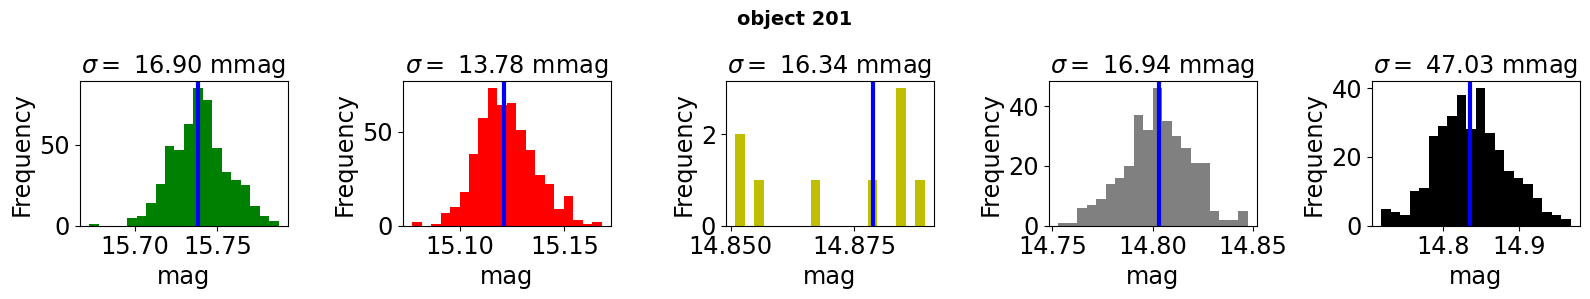

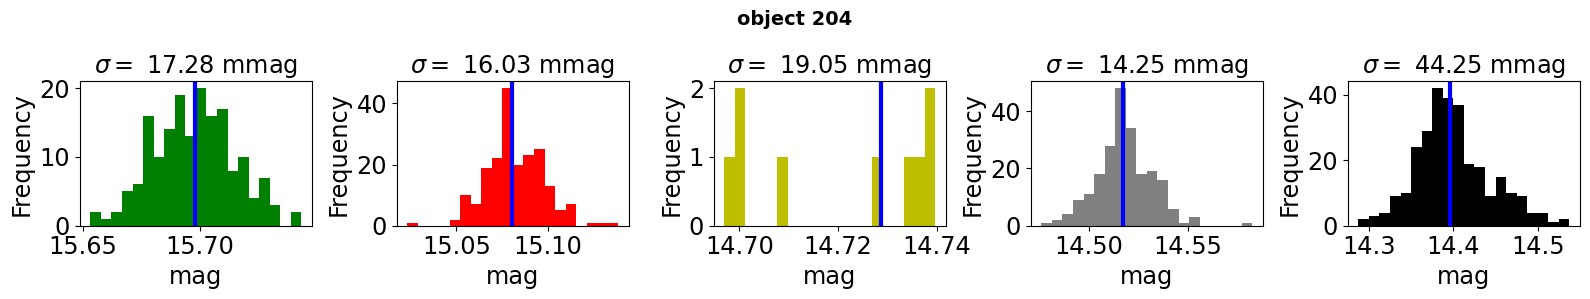

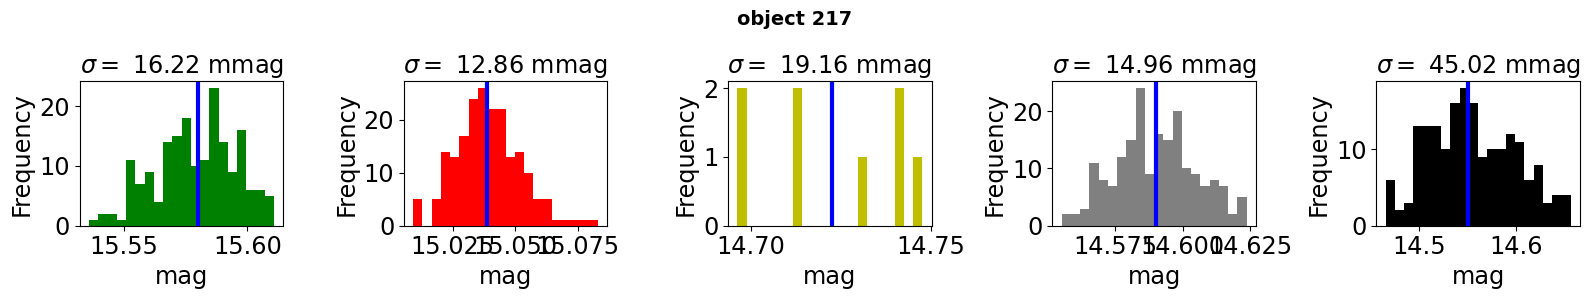

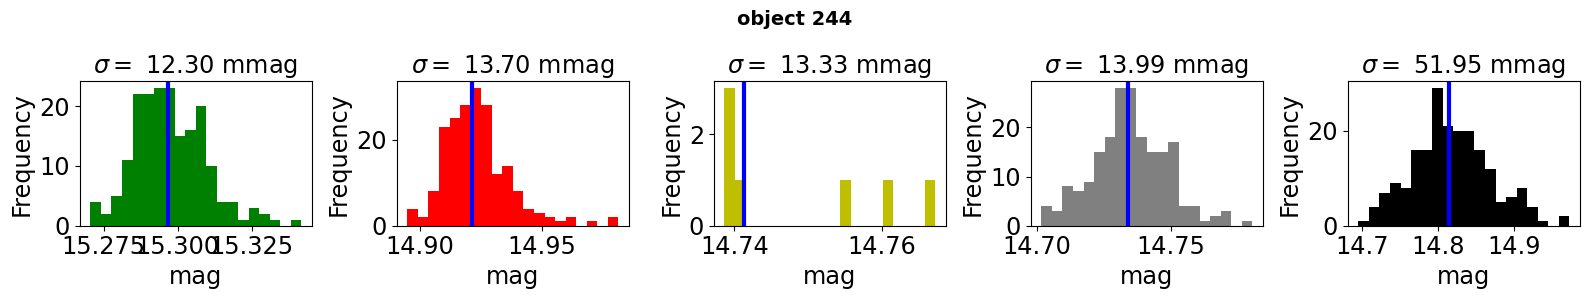

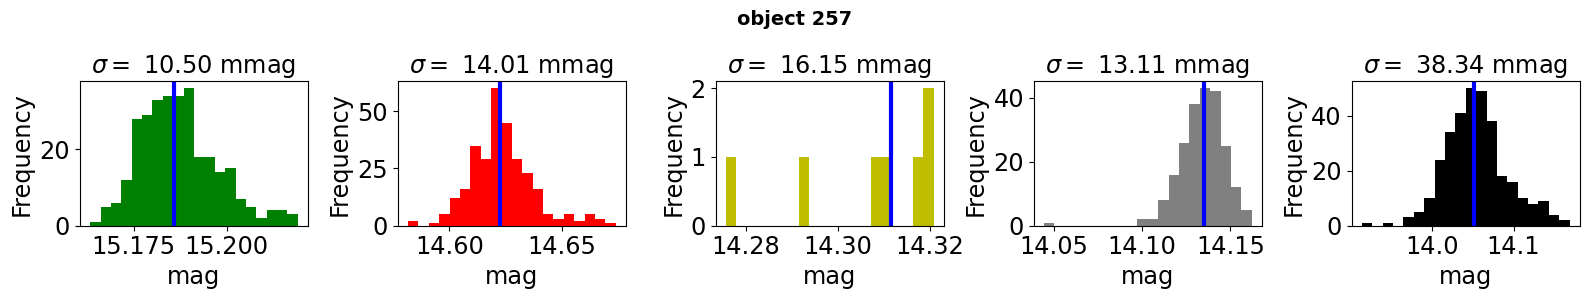

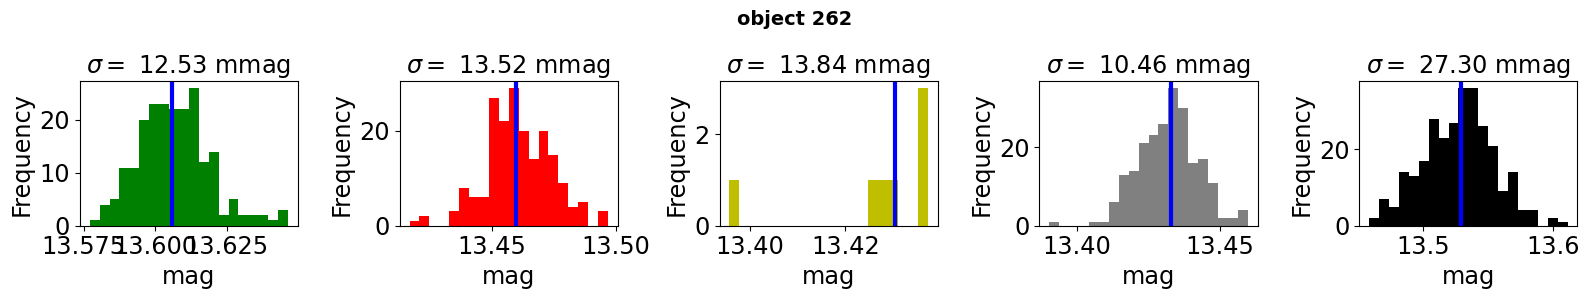

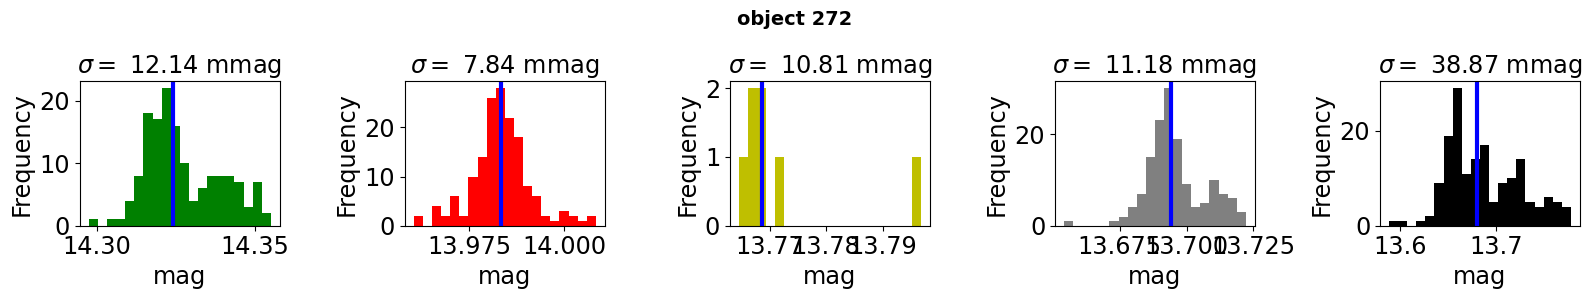

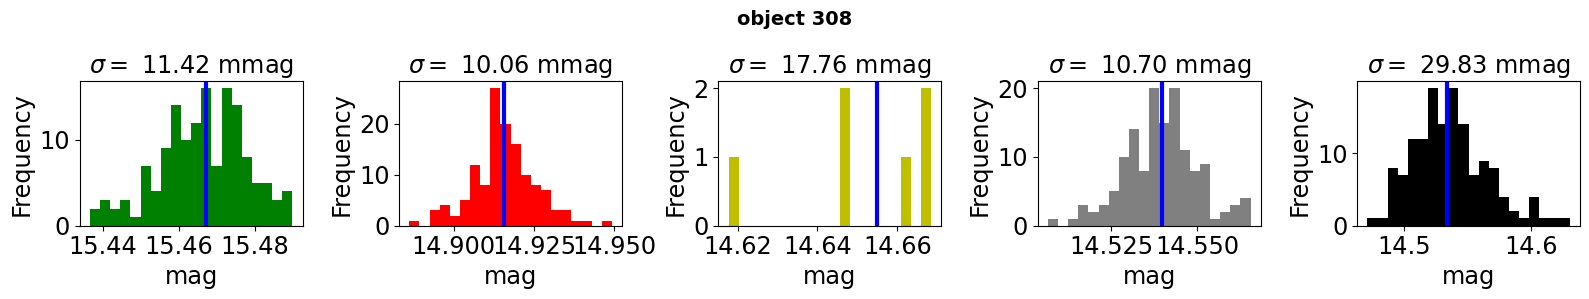

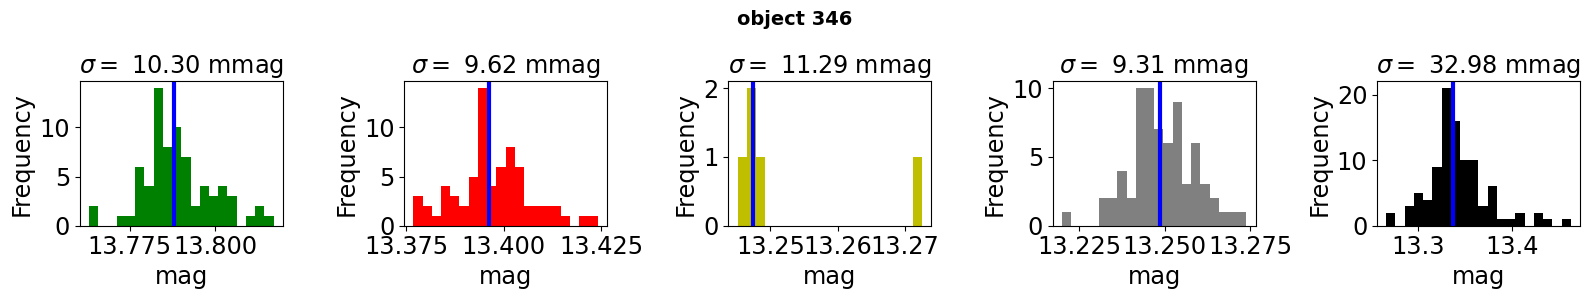

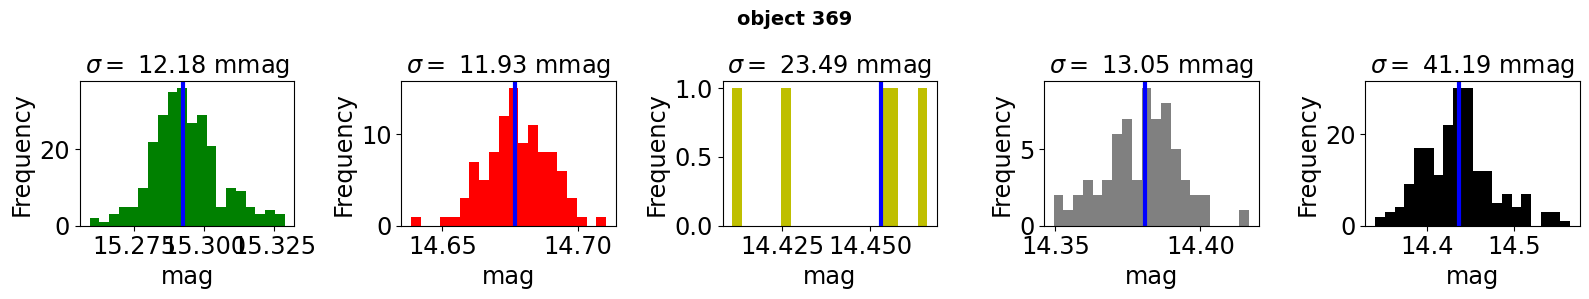

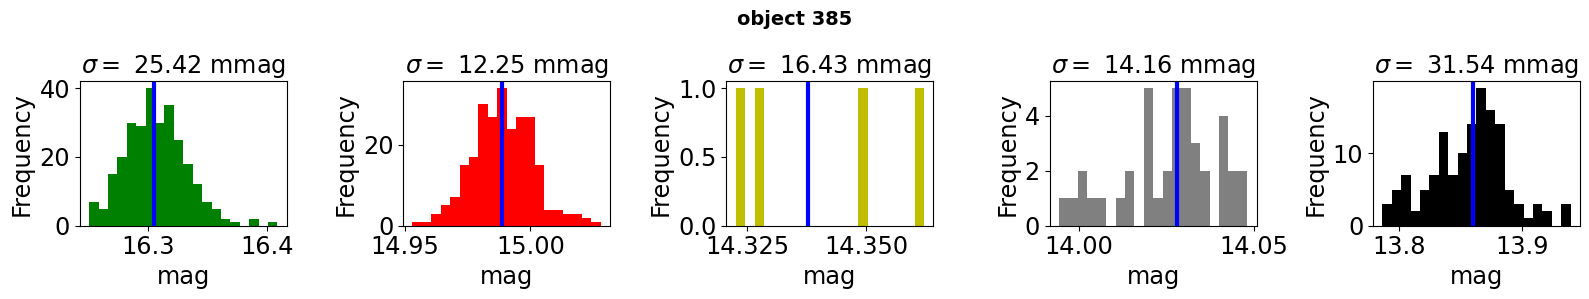

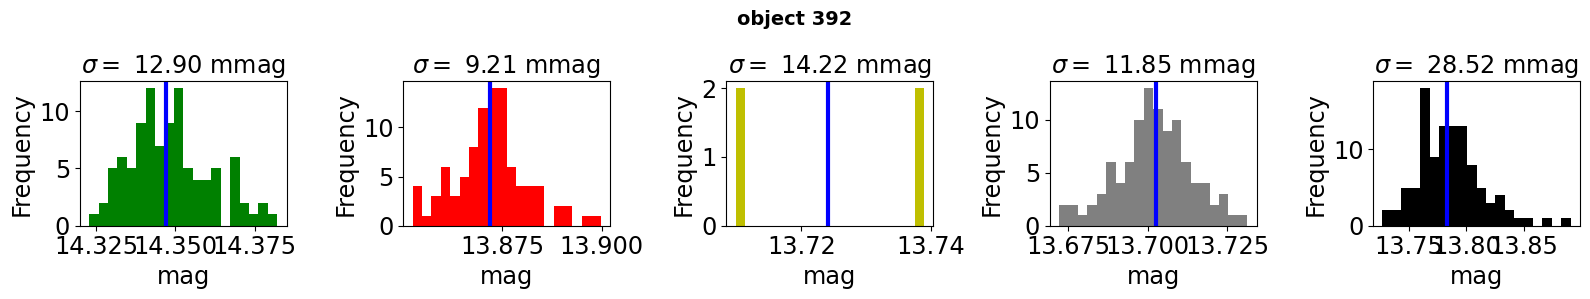

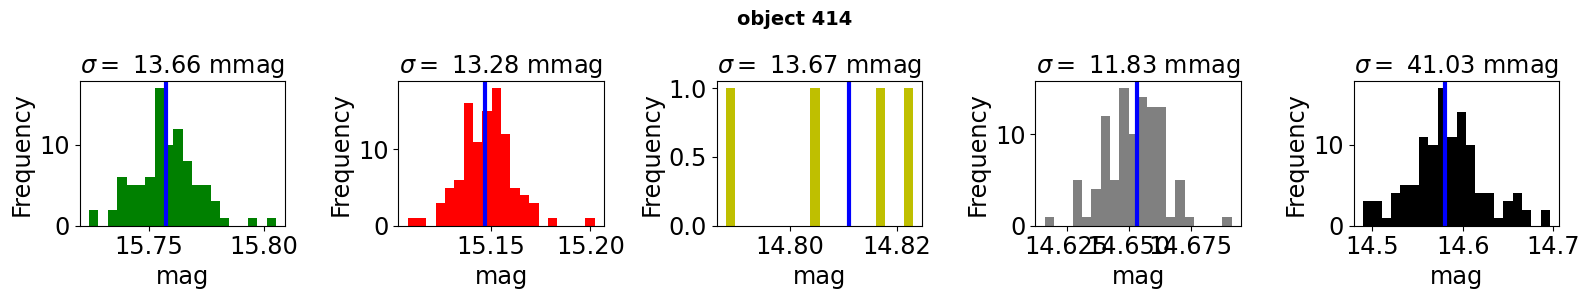

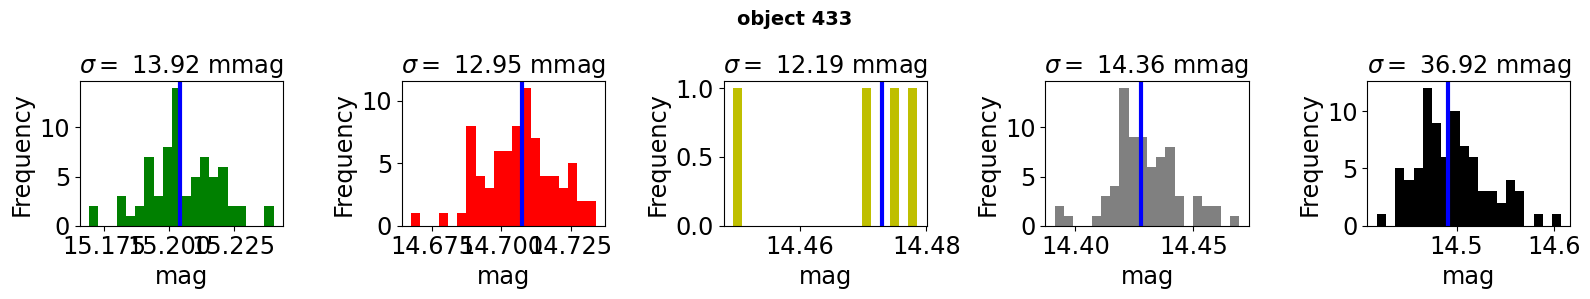

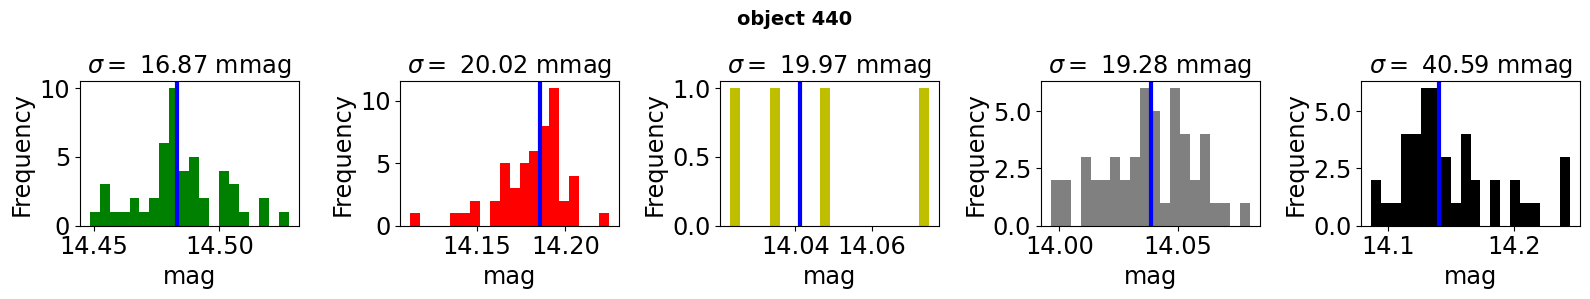

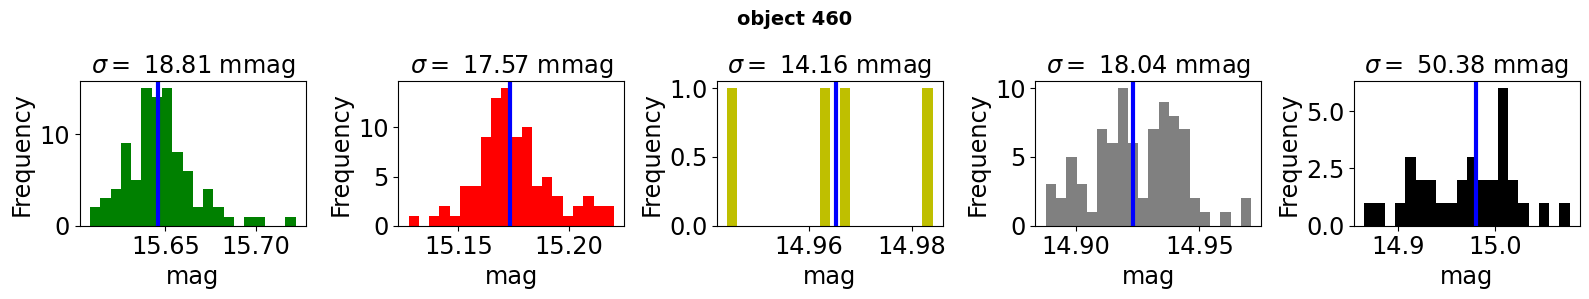

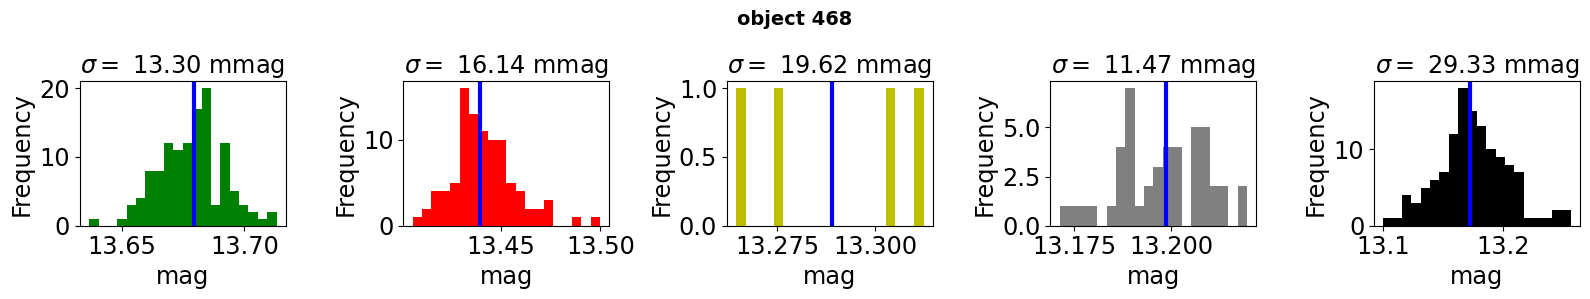

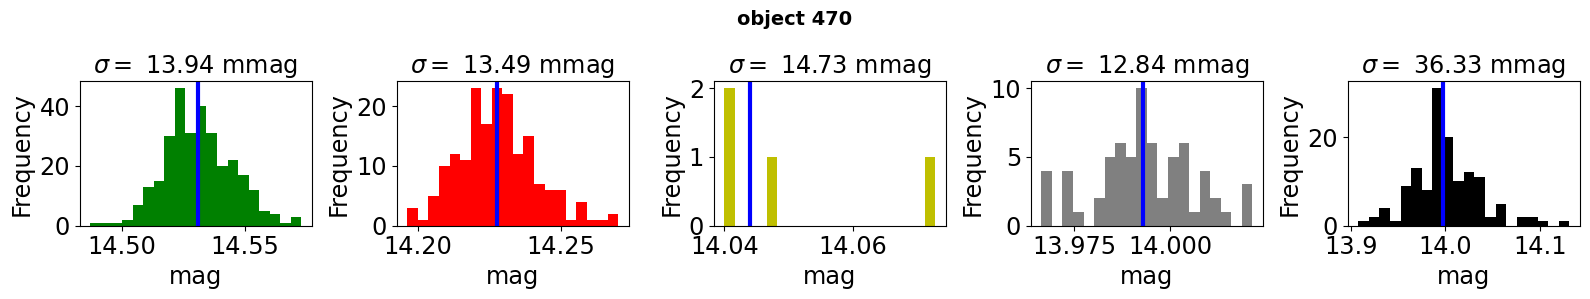

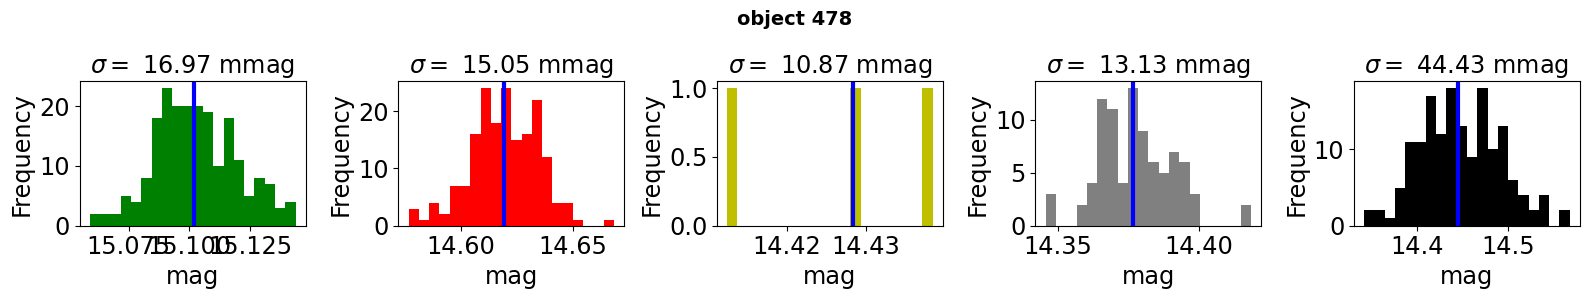

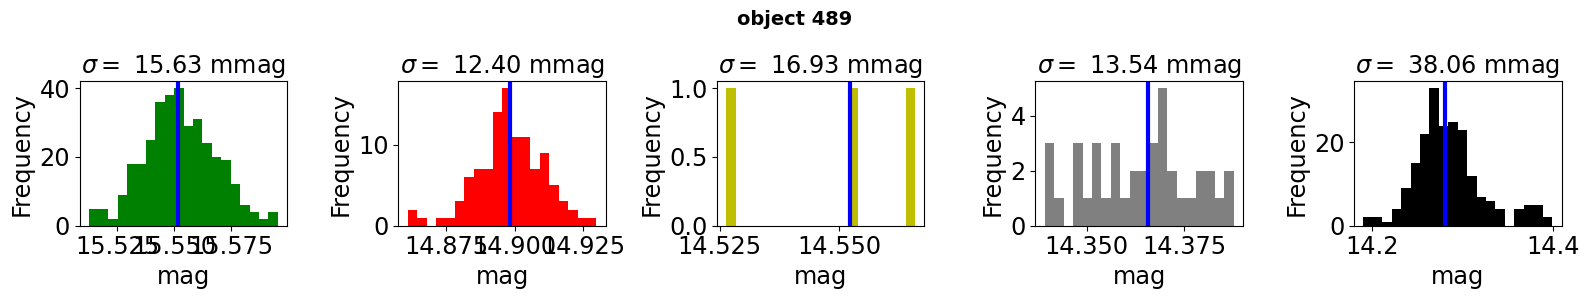

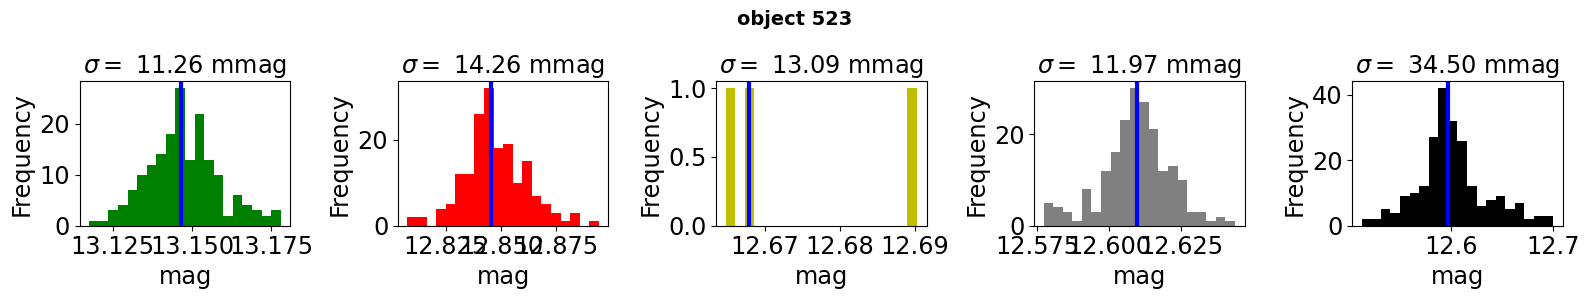

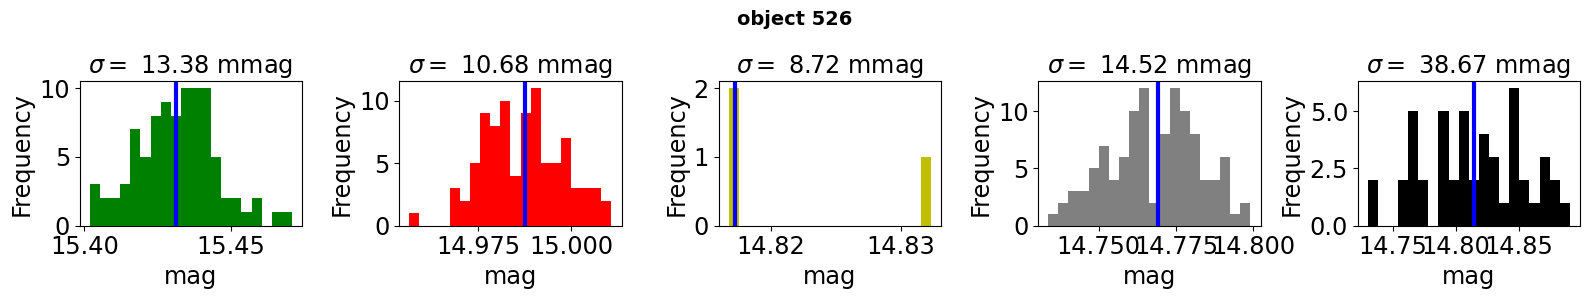

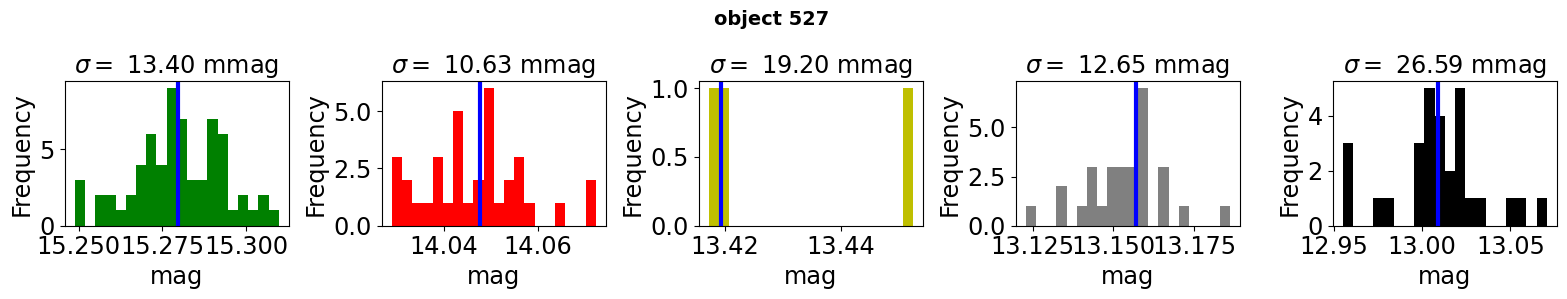

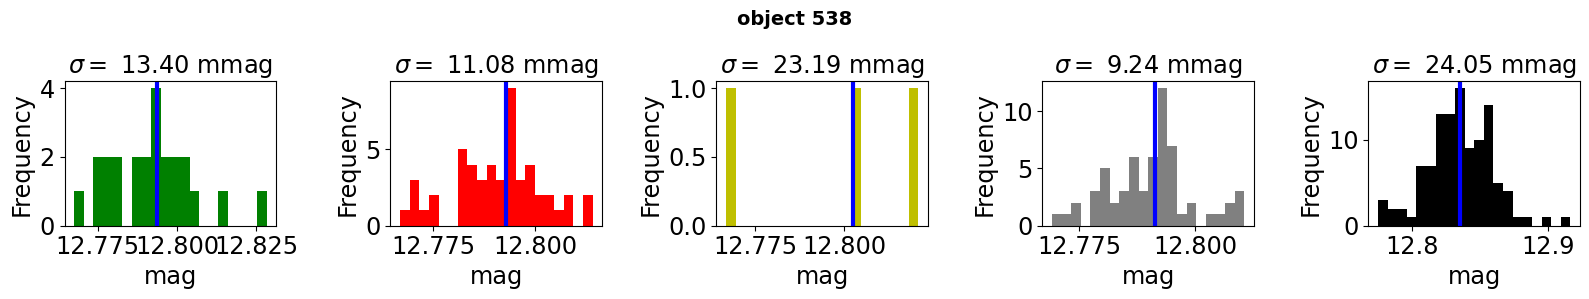

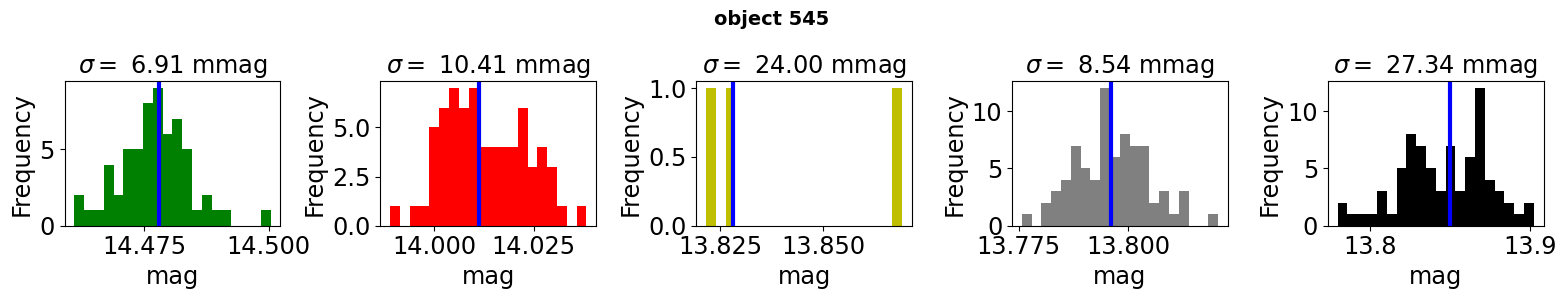

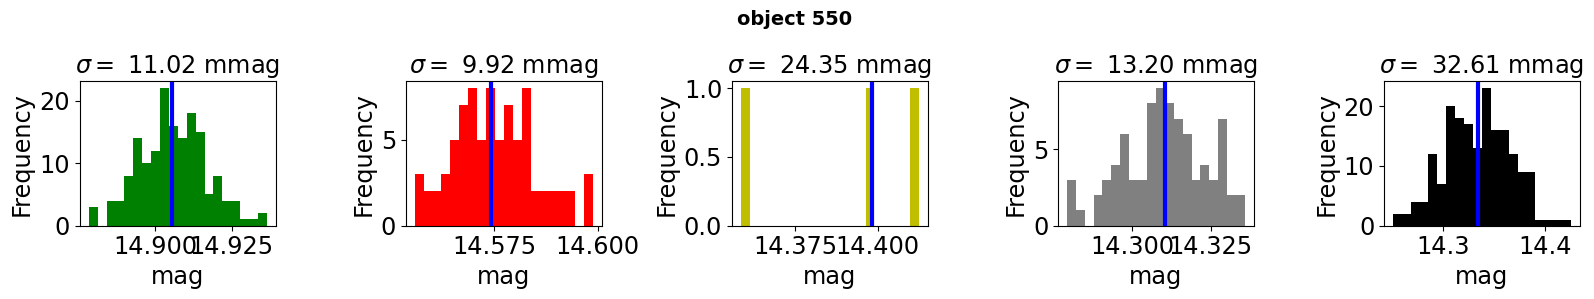

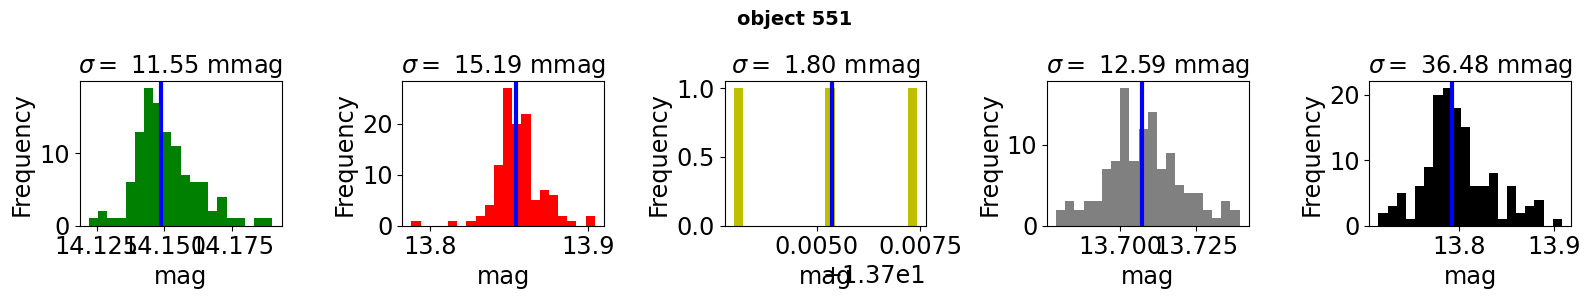

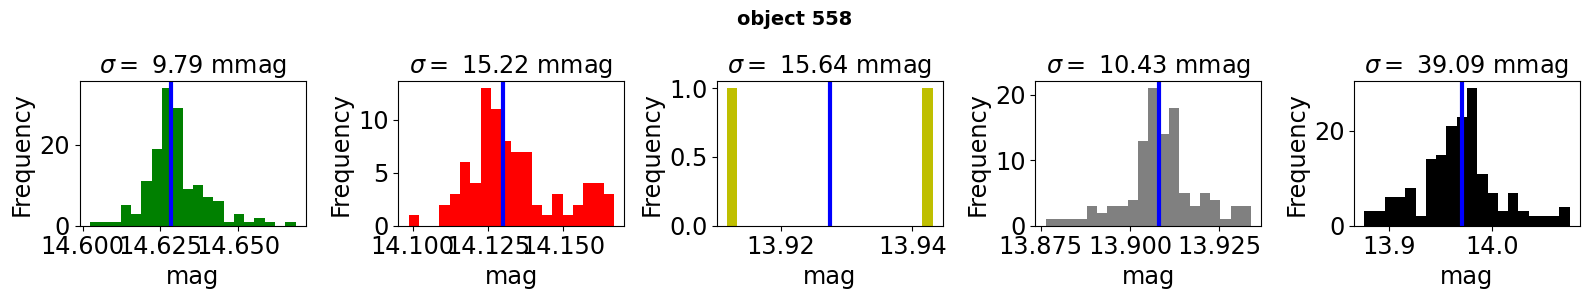

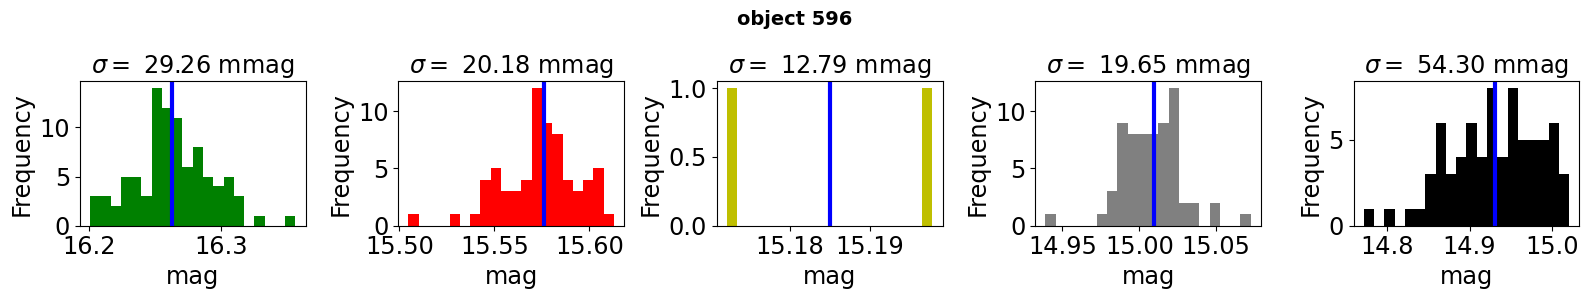

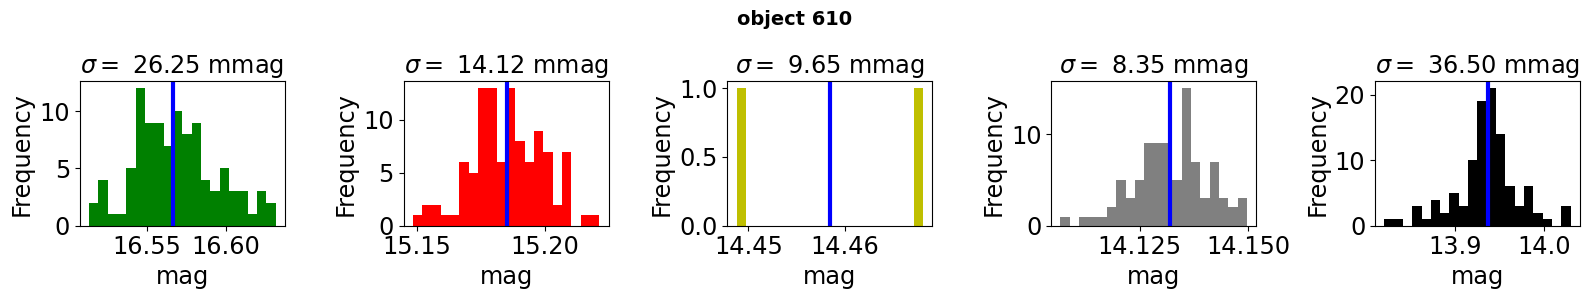

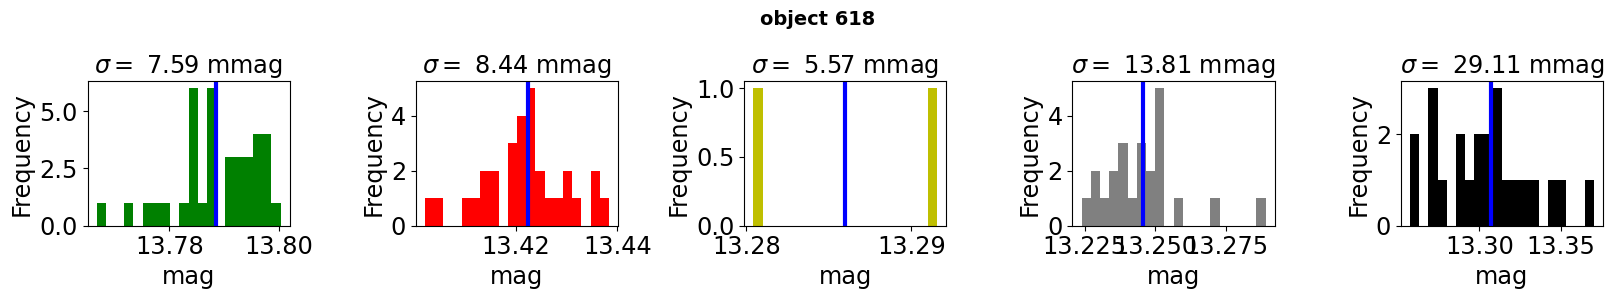

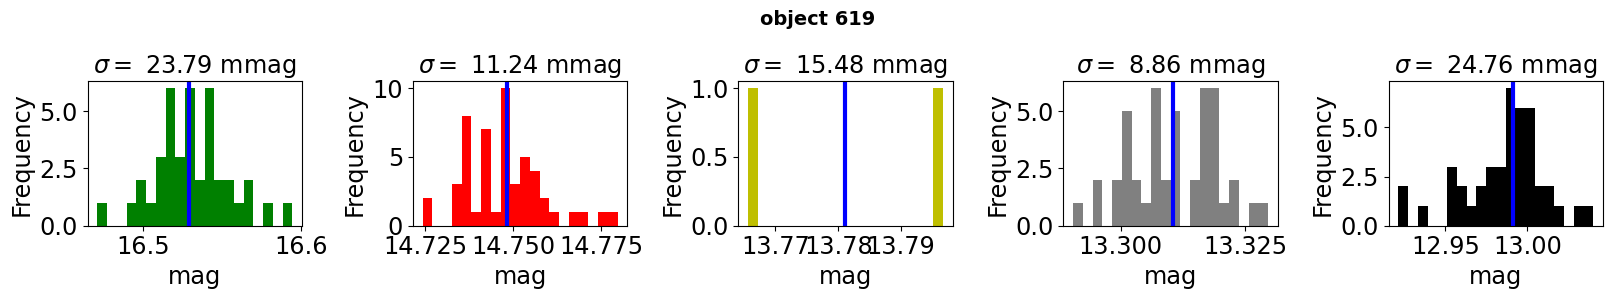

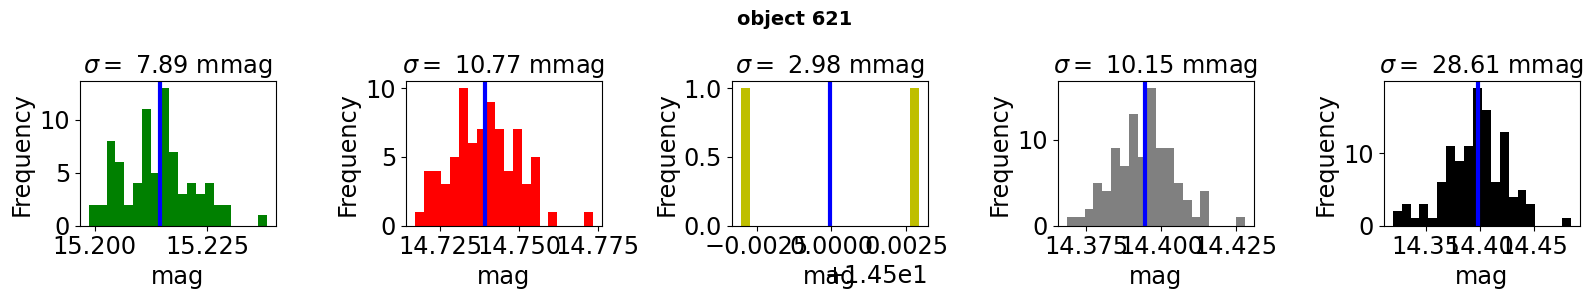

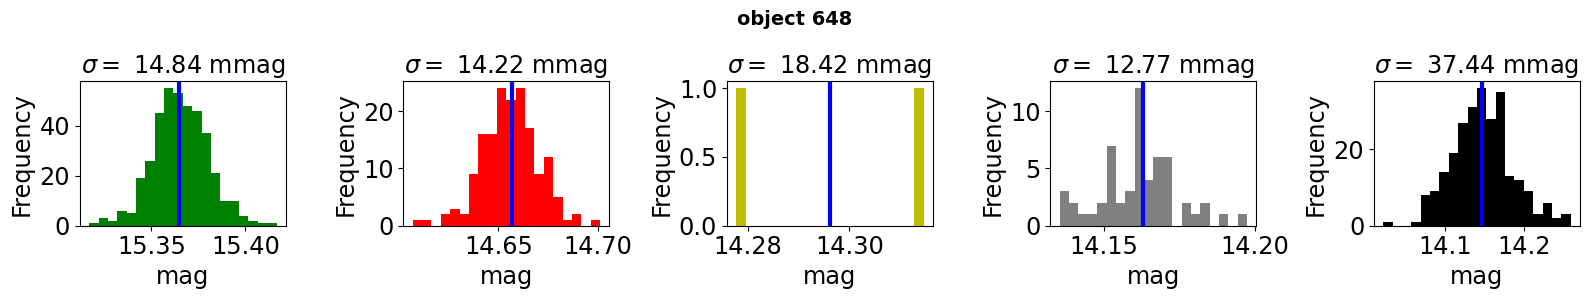

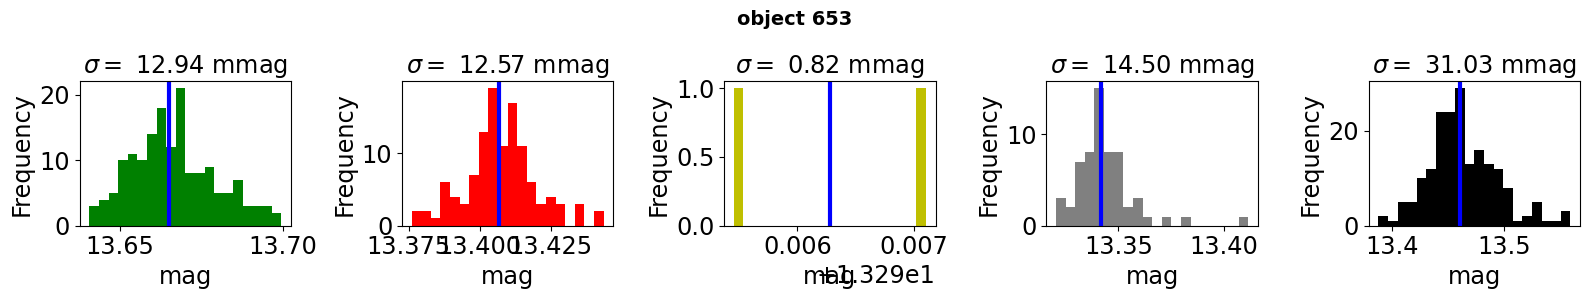

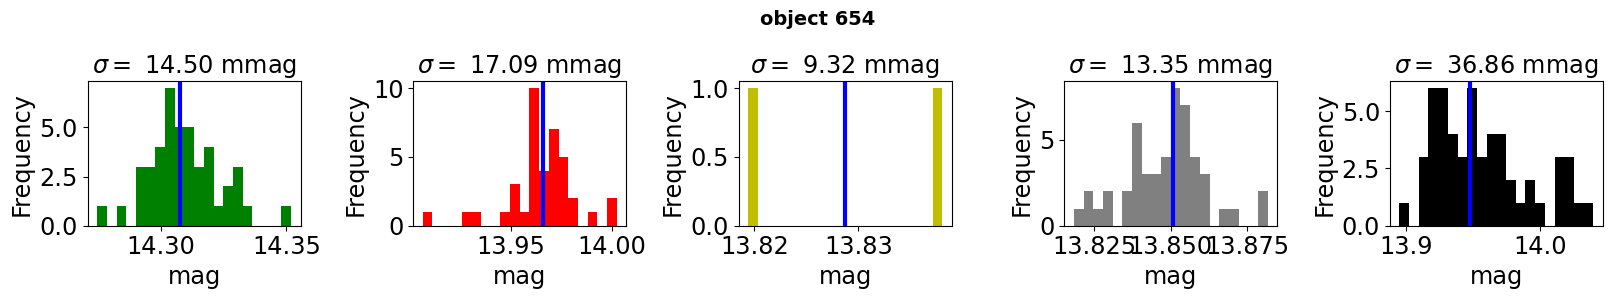

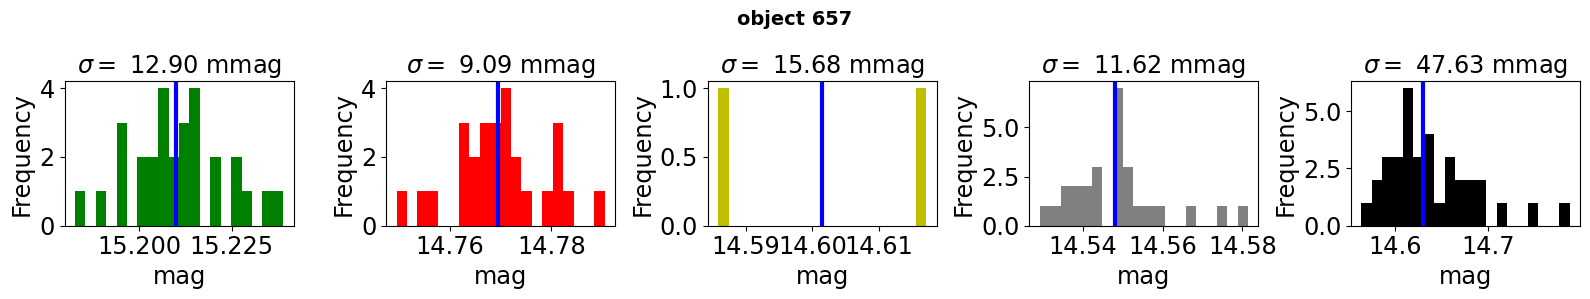

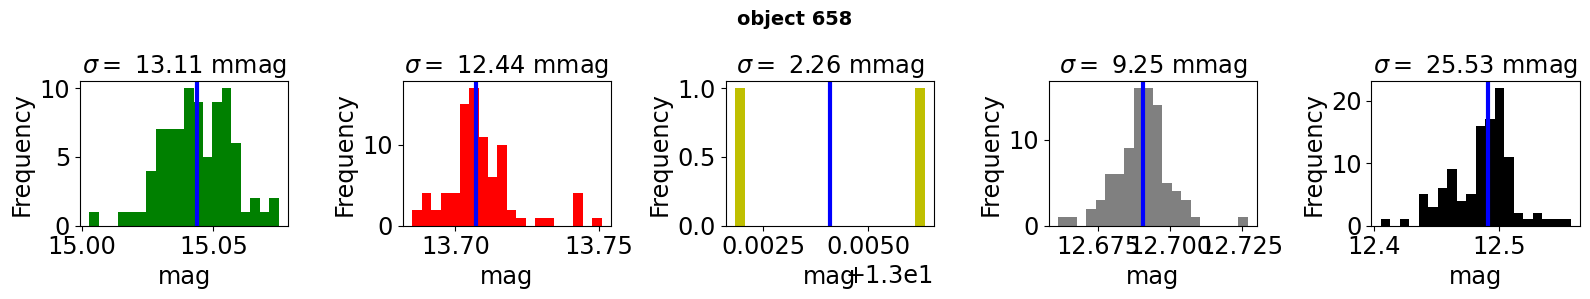

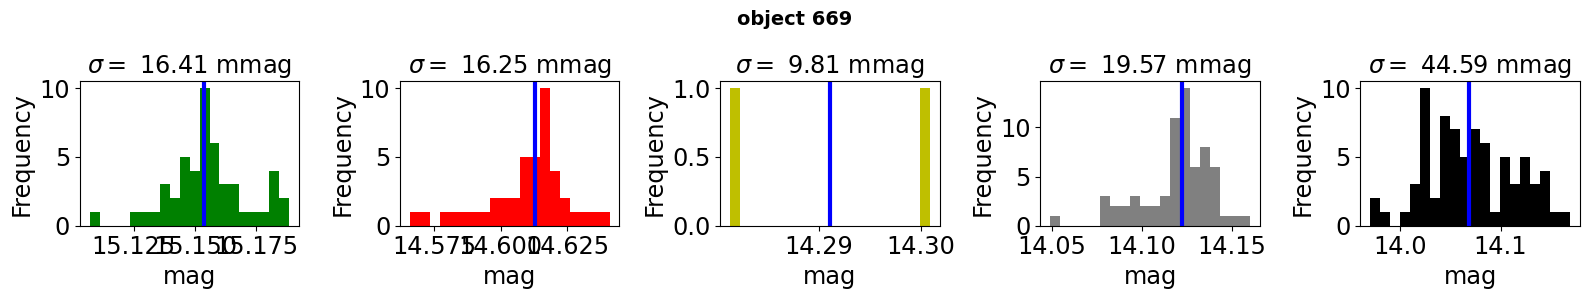

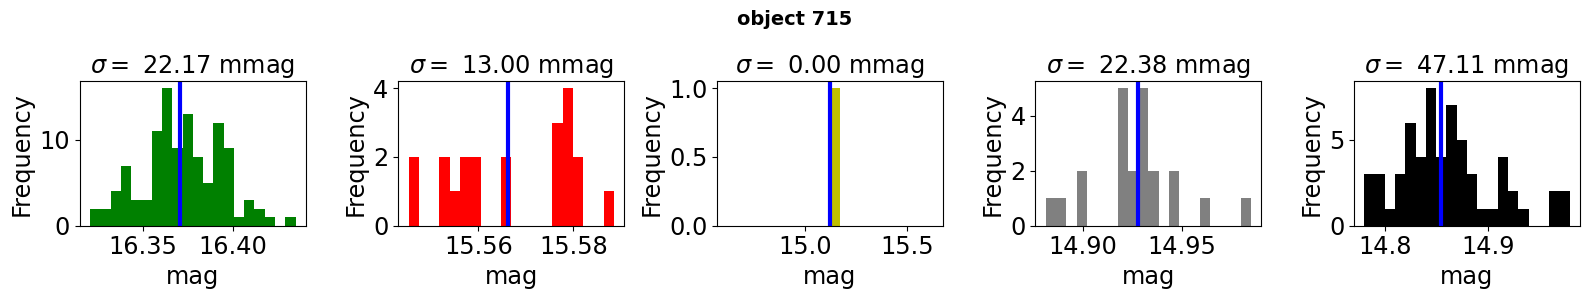

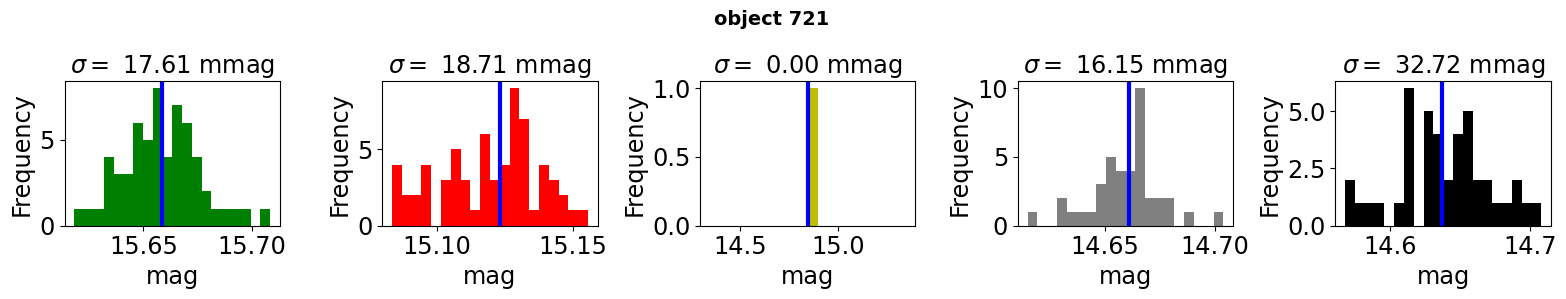

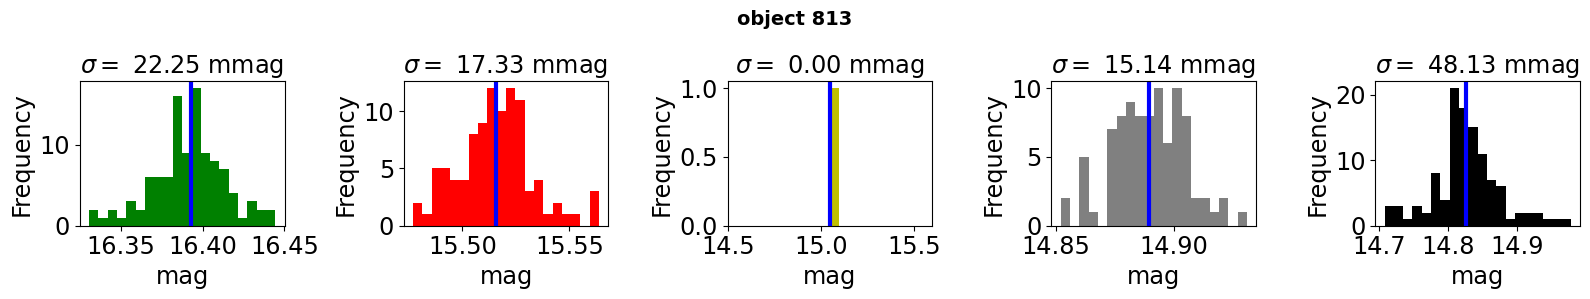

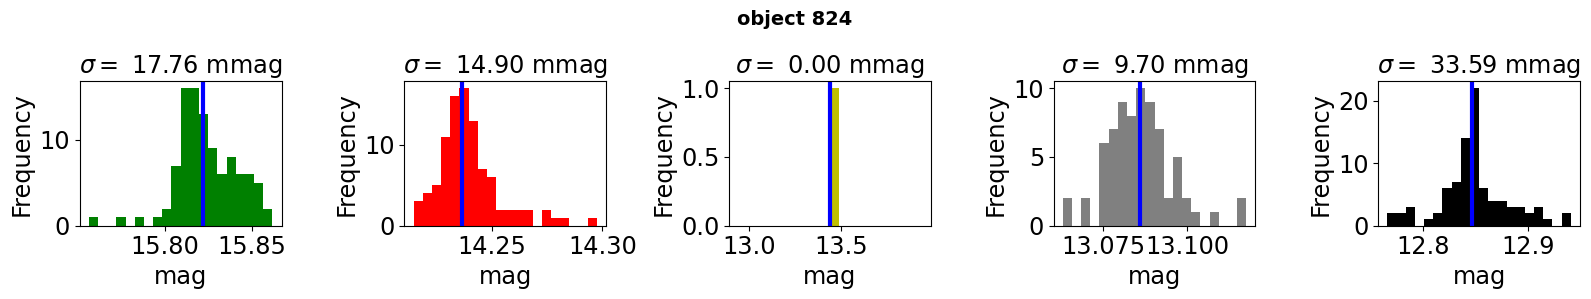

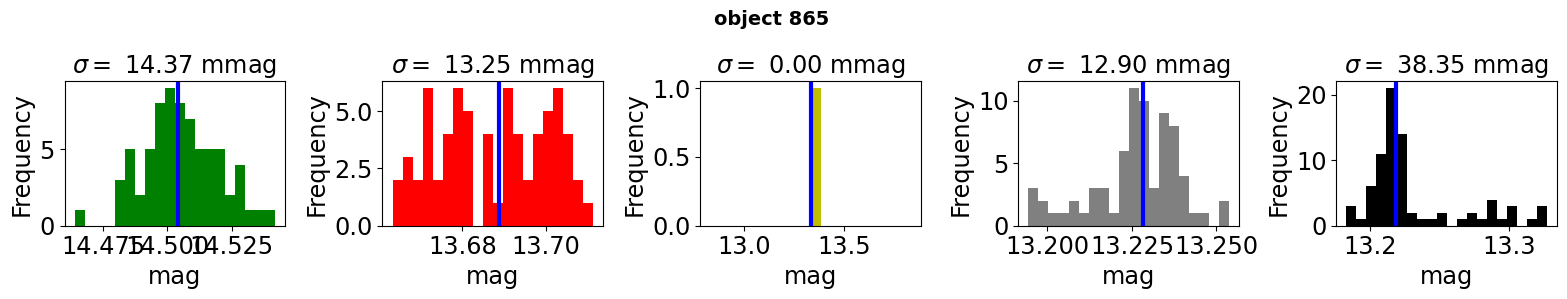

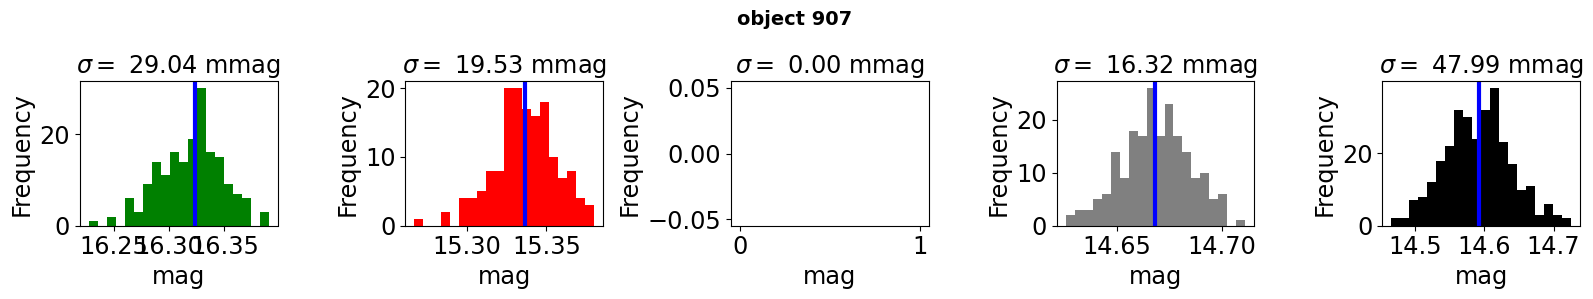

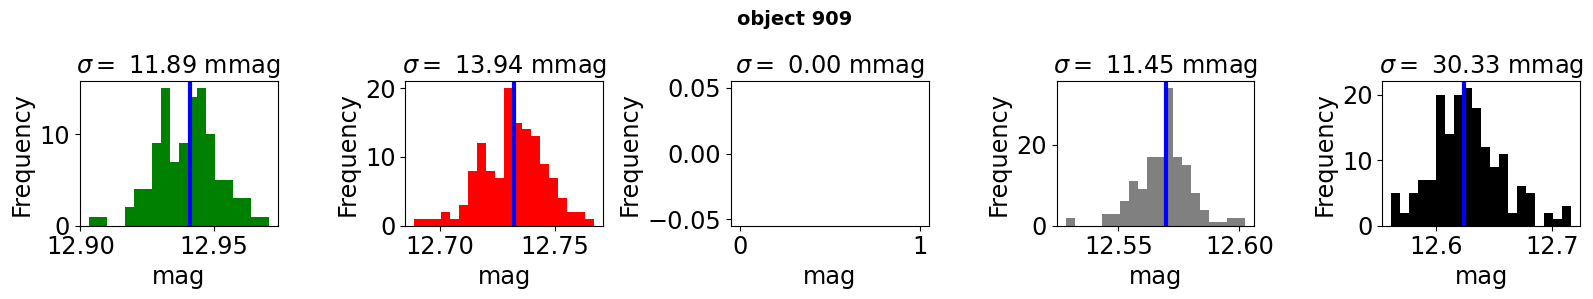

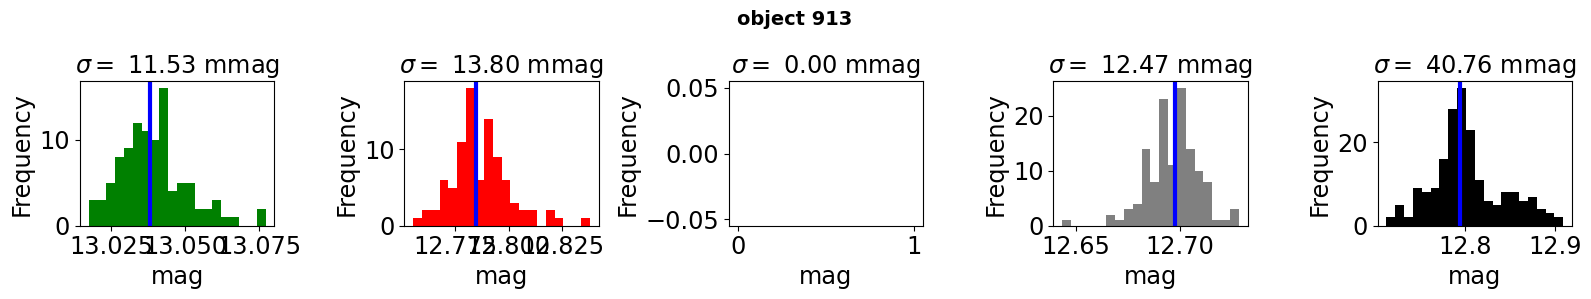

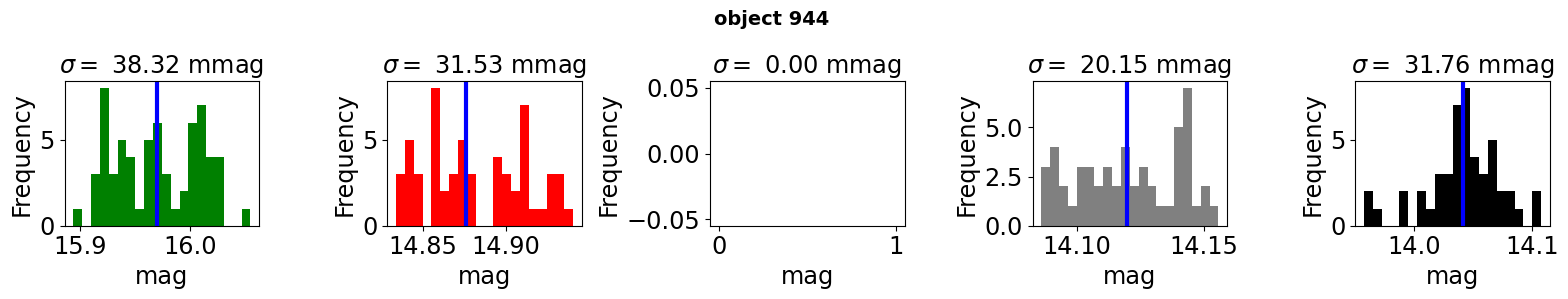

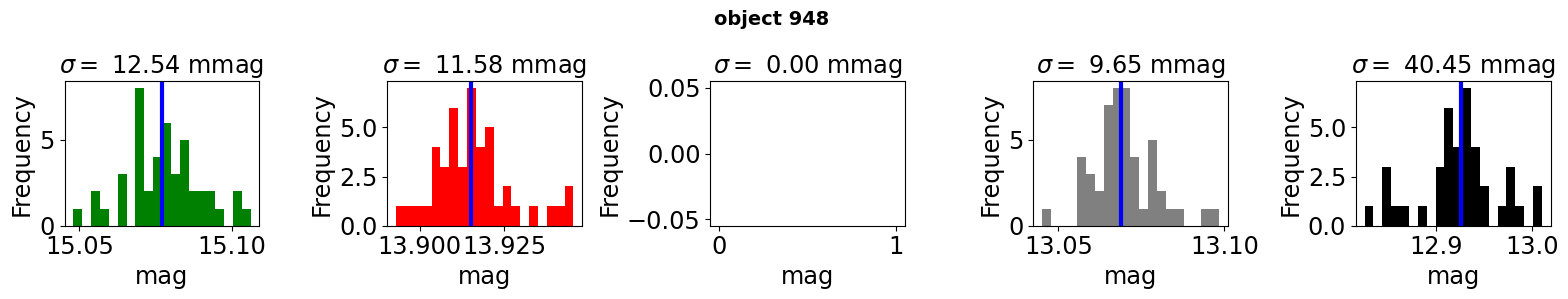

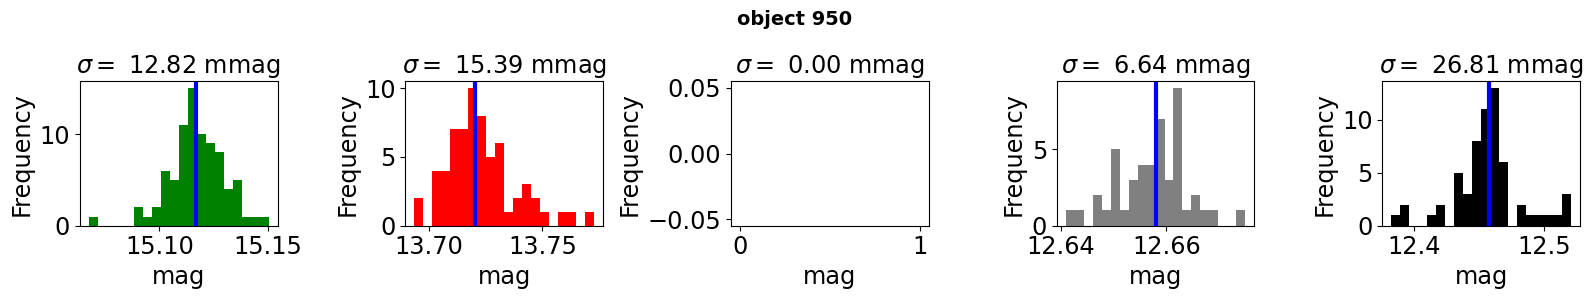

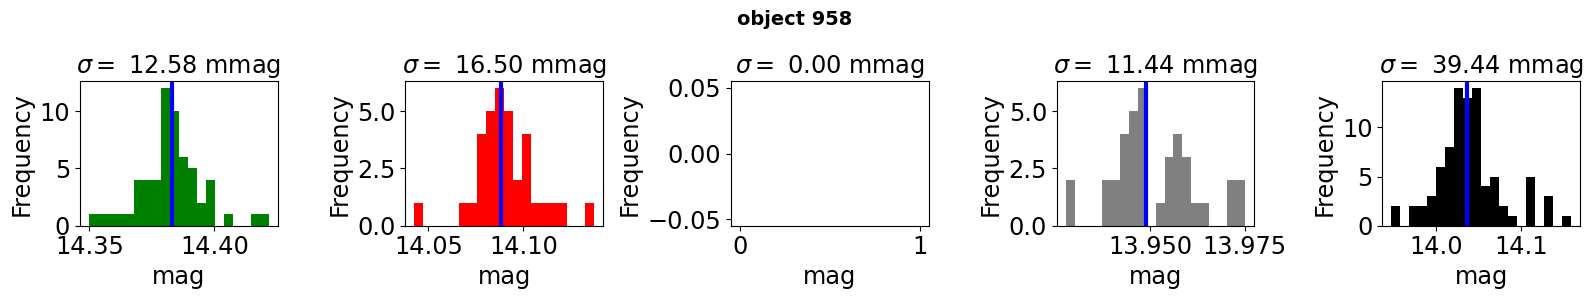

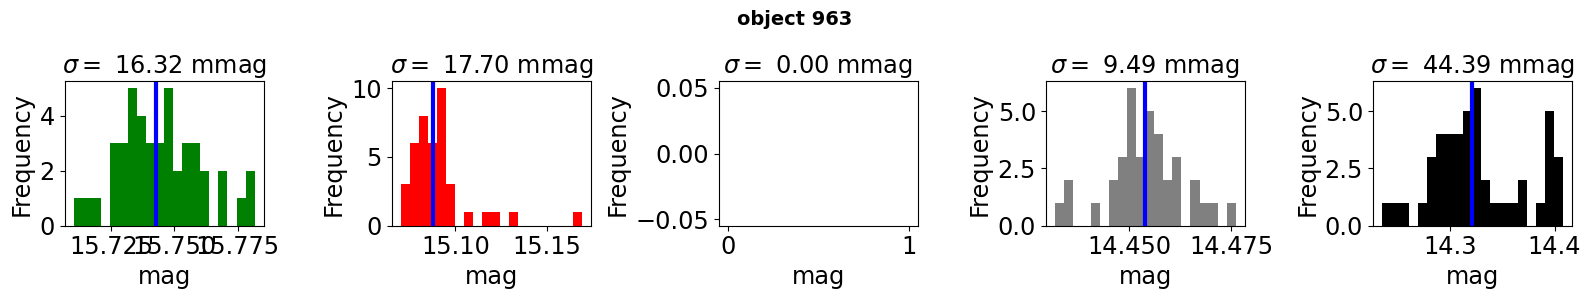

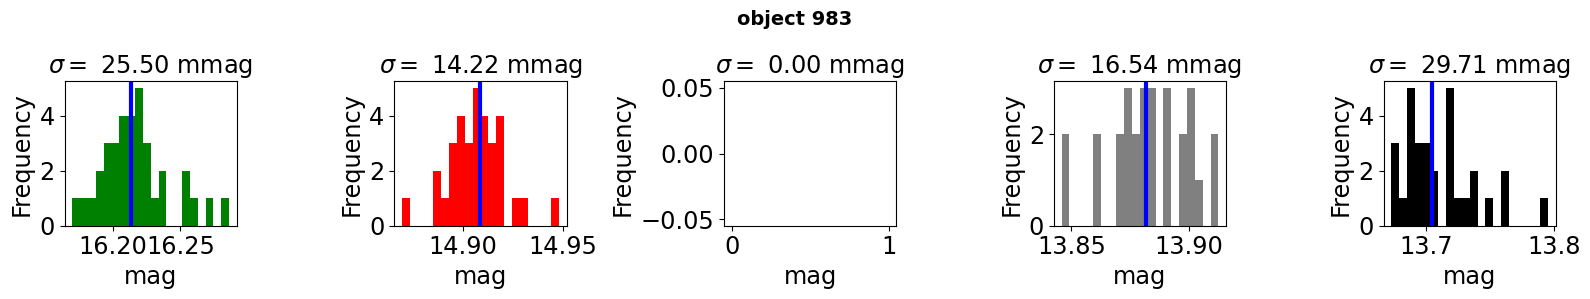

In [24]:
df_col_ap = pd.DataFrame(columns=["obj","ra","dec","g","r","i","z","y","sg","sr","si","sz","sy"])
for index in range(N):
    the_df = all_df[index]
    ra = the_df['ra'].mean()
    dec = the_df['dec'].mean()
    obj=selected_objectnum[index]
    #plothistogram_magperband(the_df,ctag="apFlux_35_0_calMag")
    plothistogram_valperband(the_df,ctag="apFlux_35_0_calMag")

    (medg,medr,medi,medz,medy) = get_df_median(the_df,ctag="apFlux_35_0_calMag")
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(the_df,ctag="apFlux_35_0_calMag")
    df_col_ap.loc[index]=[obj,ra,dec,medg,medr,medi,medz,medy,sigg,sigr,sigi,sigz,sigy]

In [25]:
ramin = df_col_ap["ra"].min()
ramax = df_col_ap["ra"].max()
decmin = df_col_ap["dec"].min()
decmax = df_col_ap["dec"].max()
dra = (ramax-ramin)*60.
ddec = (decmax-decmin)*60

In [26]:
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
#textstr = '\n'.join((
#    r'$\mu=%.2f$' % (mu, ),
#    r'$\mathrm{median}=%.2f$' % (median, ),
#    r'$\sigma=%.2f$' % (sigma, )))
textstr = f"FOV = {dra:.2f} arcmin x {ddec:.2f} arcmin"

In [27]:
df_col_ap["g_r"] = df_col_ap["g"]- df_col_ap["r"]
df_col_ap["z_y"] = df_col_ap["z"]- df_col_ap["y"]
df_col_ap["sig_g_r"] = df_col_ap.apply(lambda row: np.sqrt(row["sg"]**2+ row["sr"]**2),axis=1)
df_col_ap["sig_z_y"] = df_col_ap.apply(lambda row: np.sqrt(row["sz"]**2+ row["sy"]**2),axis=1)

In [28]:
#df_col_ap

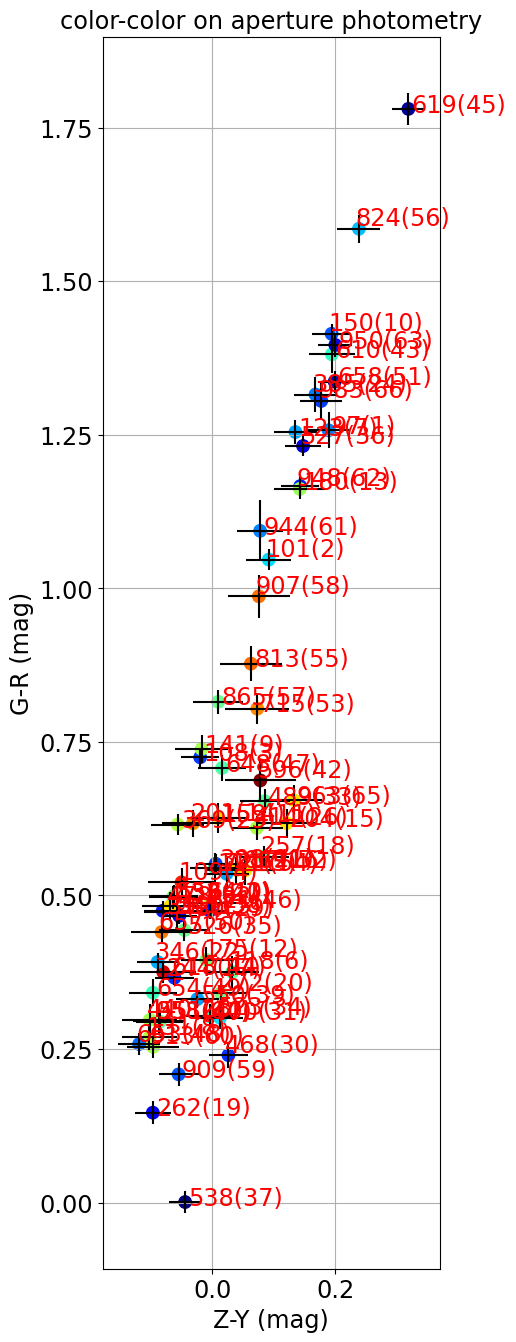

In [29]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.errorbar(df_col_ap["z_y"],df_col_ap["g_r"],xerr=df_col_ap["sig_z_y"] , yerr=df_col_ap["sig_g_r"], fmt=".",color='k',ecolor='k',markersize=1) 
df_col_ap.plot.scatter(x="z_y", y="g_r",marker= "o", s=80,c="sy",cmap="jet",ax=ax,colorbar=False)
ax.set_xlabel("Z-Y (mag)")
ax.set_ylabel("G-R (mag)")
ax.set_title("color-color on aperture photometry")
ax.set_aspect("equal")
ax.grid()


for index,row in df_col_ap.iterrows():
    idobj = int(row.obj)
    txtlabel = f"{idobj}({index})"
    x = row["z_y"]
    y = row["g_r"]
    if index%2 == 0:
        ax.text(x-0.005,y+.005,txtlabel,size= 'xx-large',color="r")
    else:
        ax.text(x+0.005,y-0.005,txtlabel,size= 'xx-large',color="r")


plt.show()

In [30]:
df_col_ap["sizecode"] = (15.5-df_col_ap["z"])*100

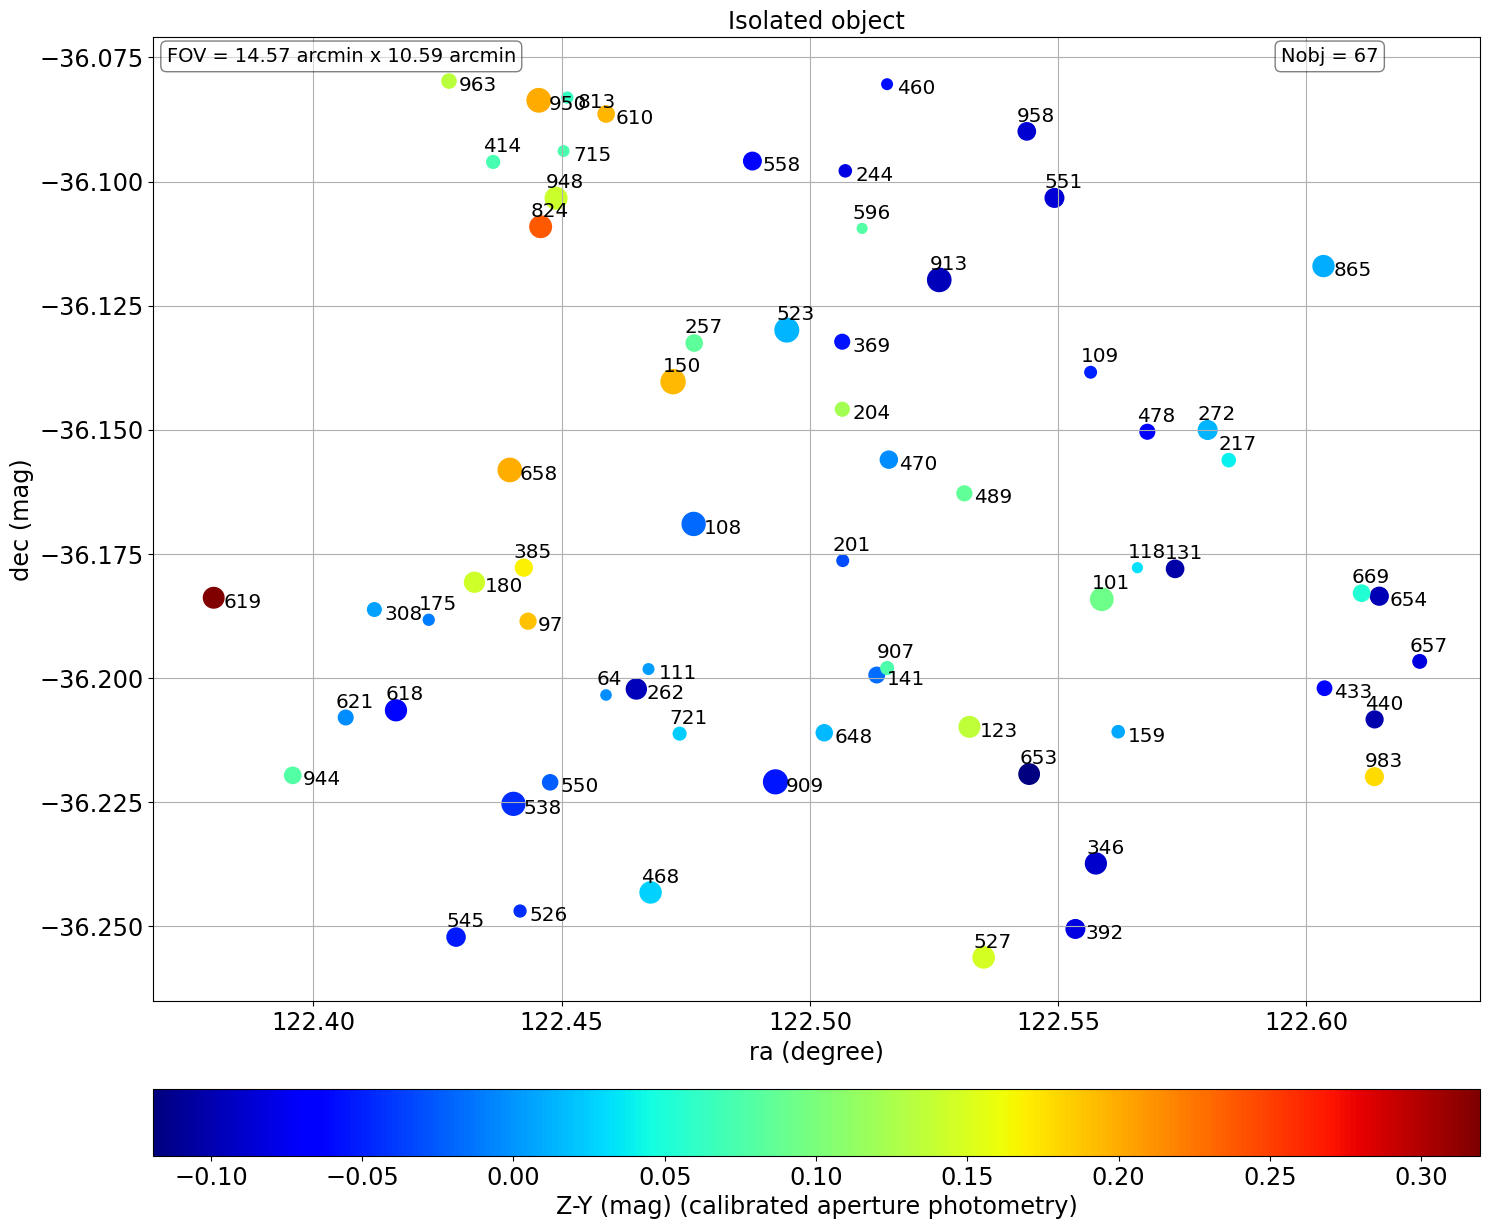

In [31]:
fig,ax = plt.subplots(1,1,figsize=(15,15))
df_col_ap.plot.scatter(x="ra", y="dec",marker= "o", s="sizecode",c="z_y",cmap="jet",ax=ax,colorbar=False)
ax.set_xlabel("ra (degree)")
ax.set_ylabel("dec (mag)")
ax.set_title("Isolated object")
ax.set_aspect("equal")
ax.grid()

cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=1.0,pad=0.06)
cbar.ax.set_xlabel('Z-Y (mag) (calibrated aperture photometry)', rotation=0)

for index,row in df_col_ap.iterrows():
    idobj = int(row.obj)
    x = row["ra"]
    y = row["dec"]
    if index%2 == 0:
        ax.text(x-0.002,y+.002,str(idobj),size= 'x-large')
    else:
        ax.text(x+0.002,y-0.002,str(idobj),size= 'x-large')


ax.text(0.01, 0.99, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax.text(0.85, 0.99, f"Nobj = {N}", transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

## Create pandas dataframe on psf photometry isolated object data

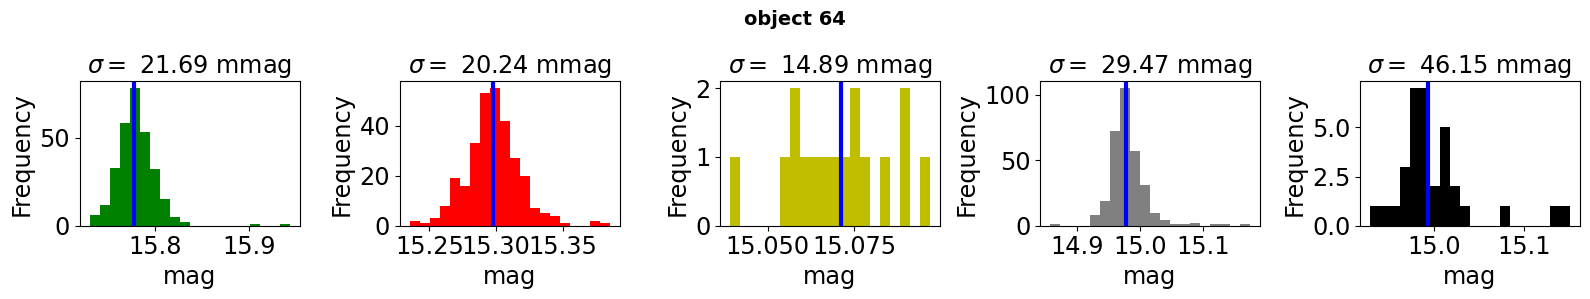

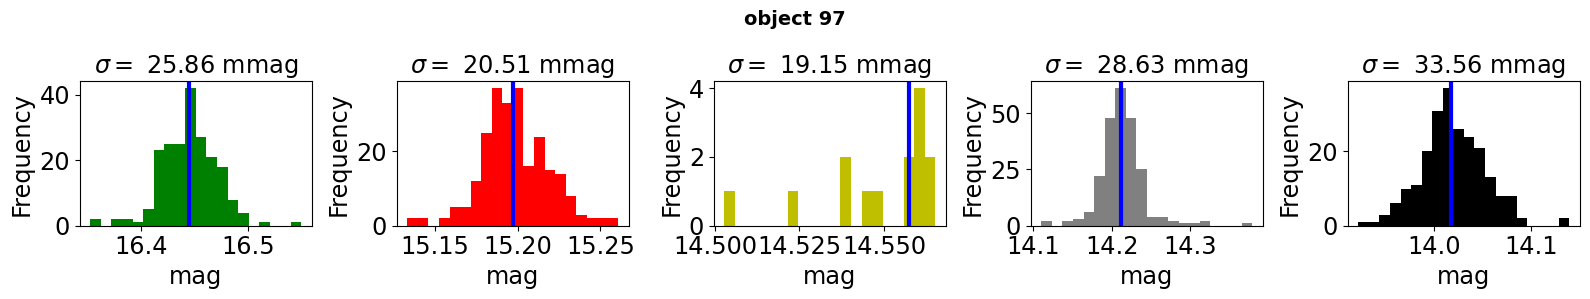

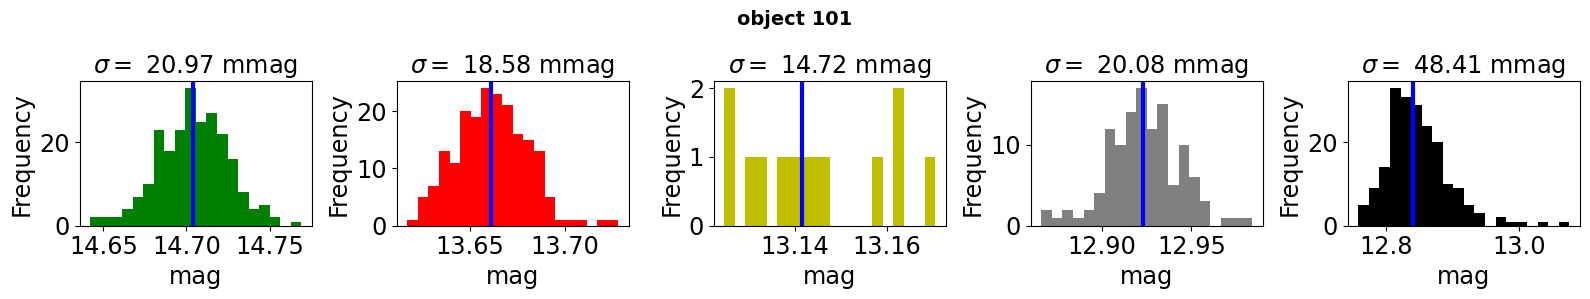

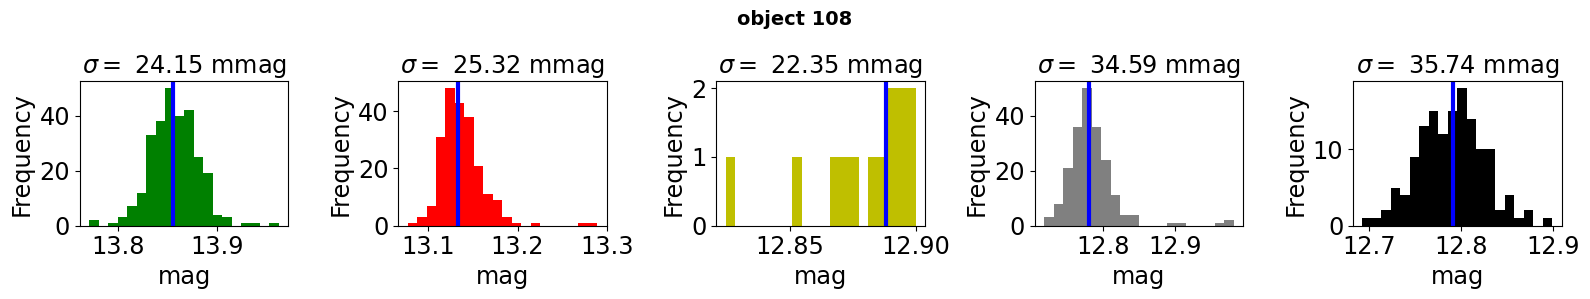

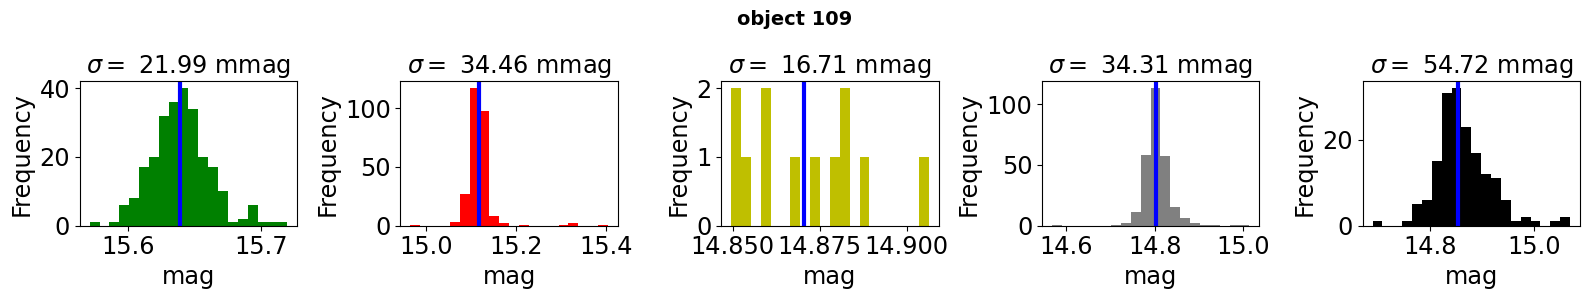

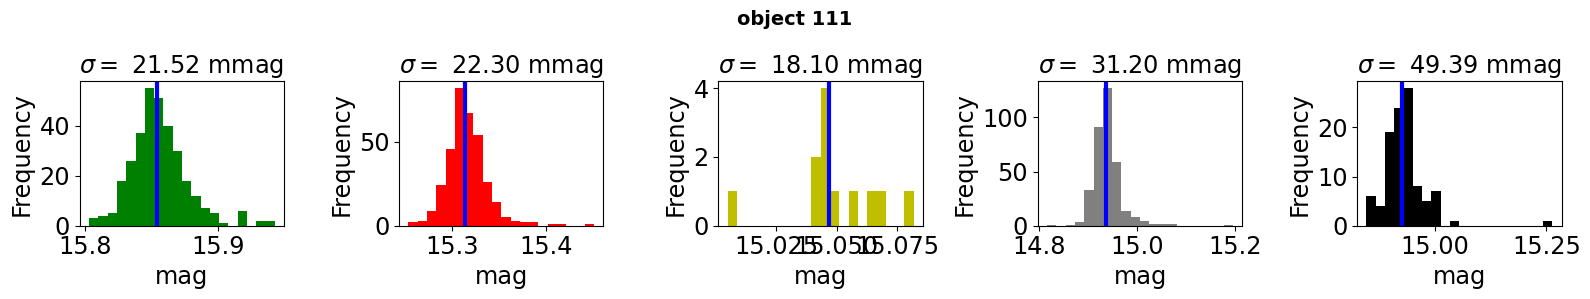

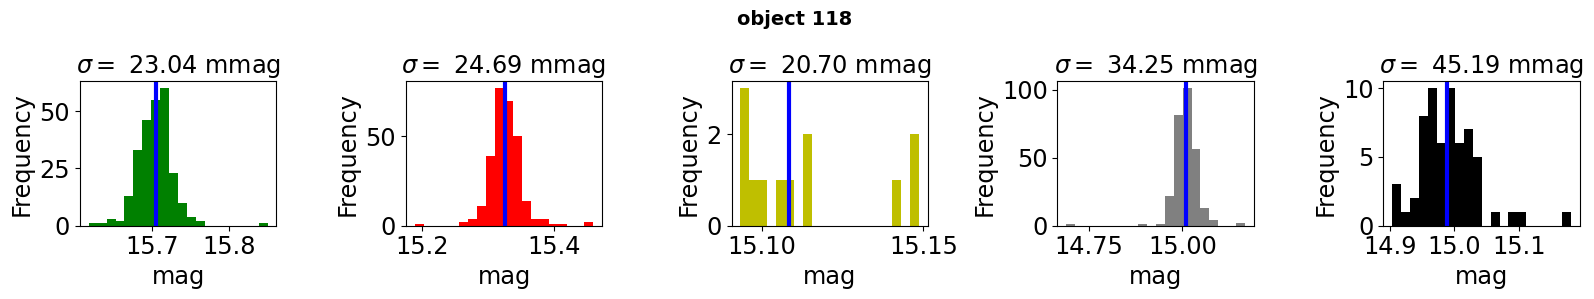

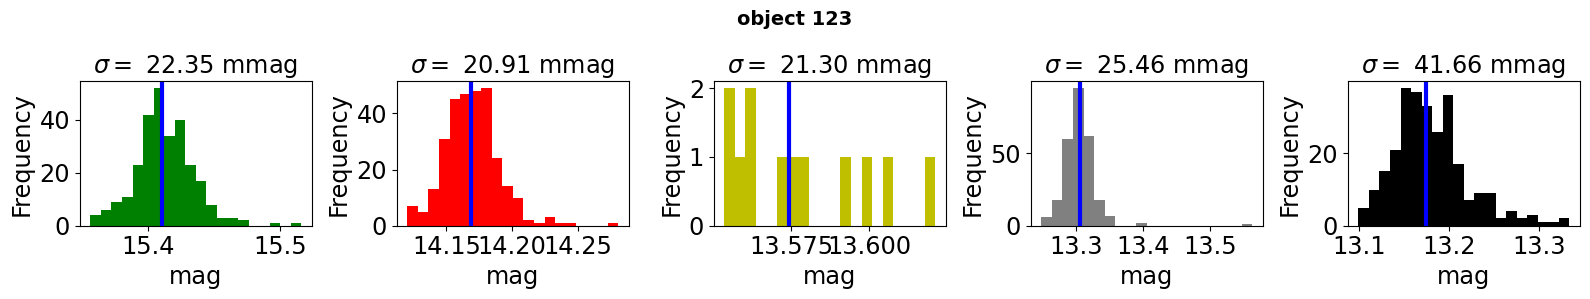

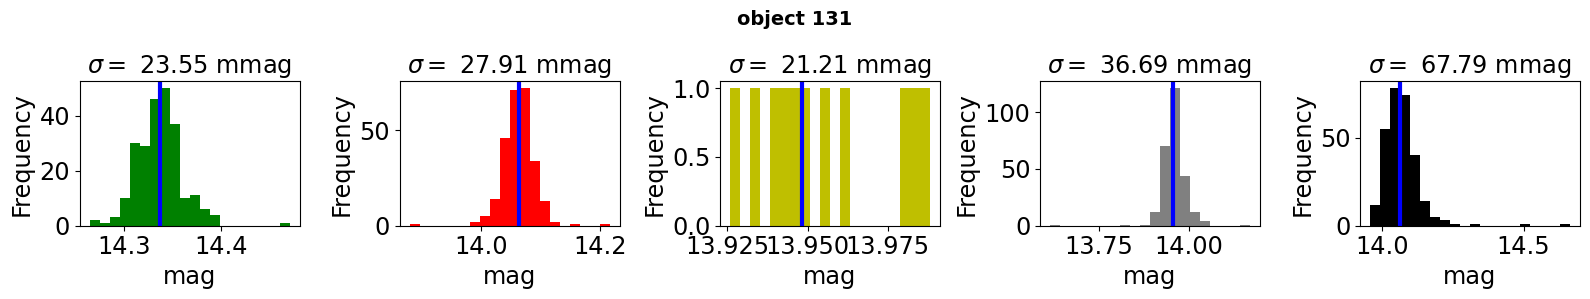

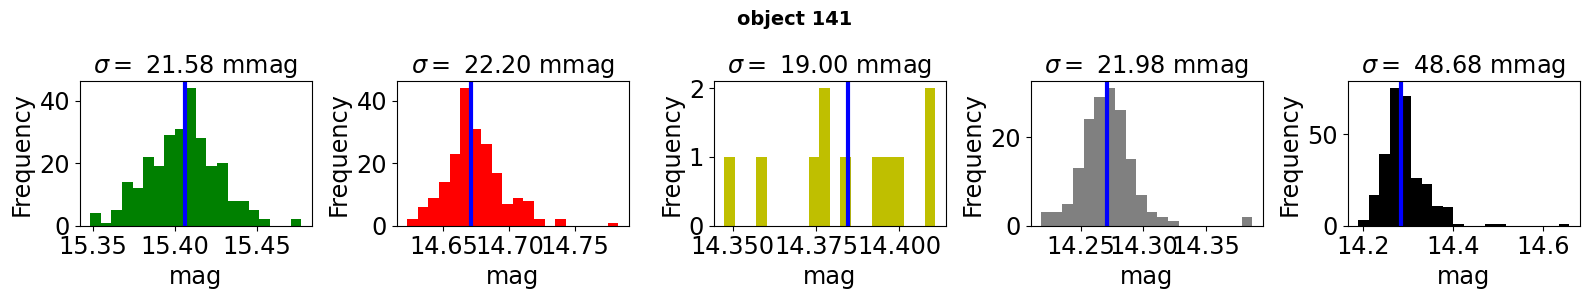

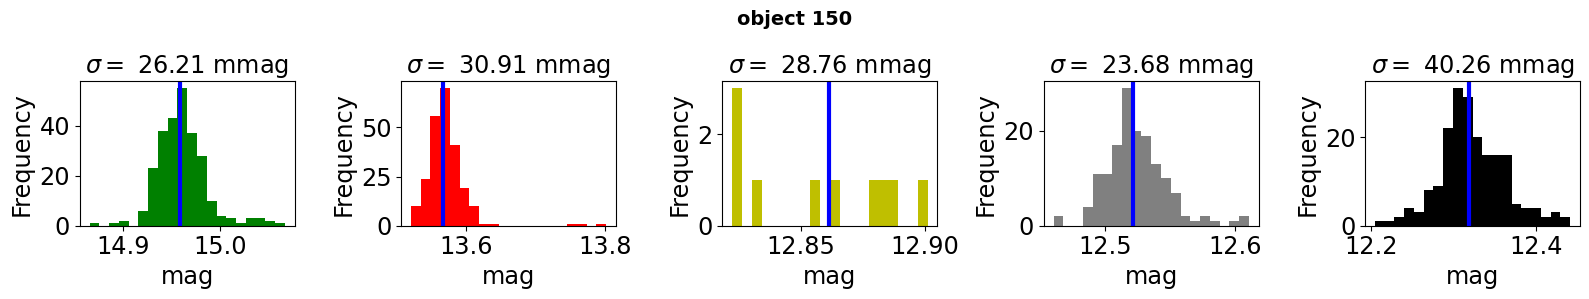

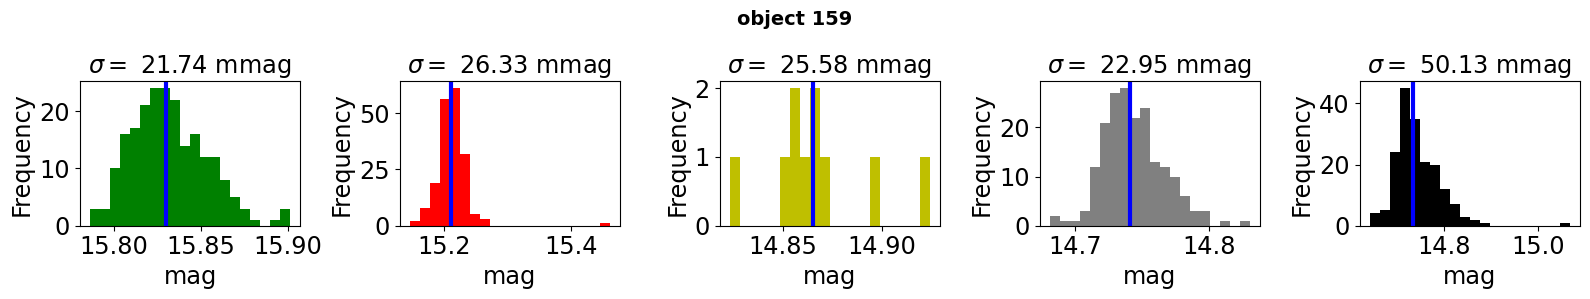

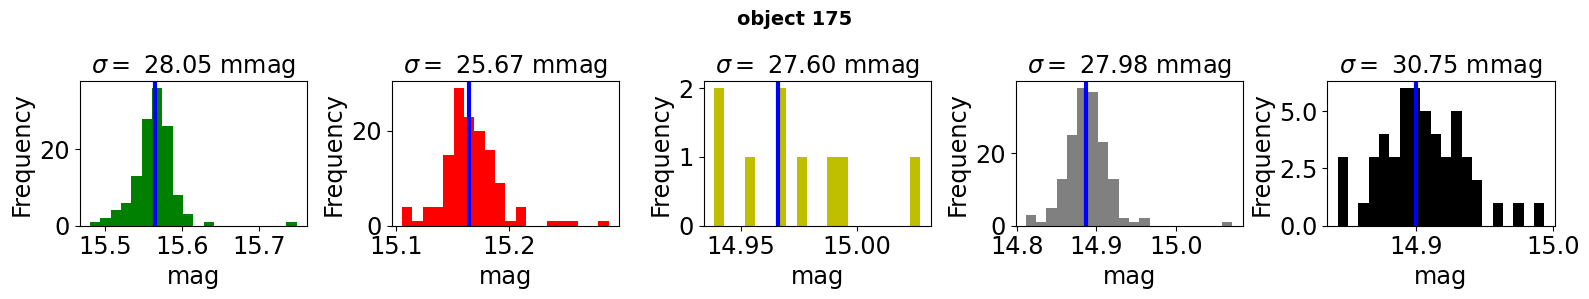

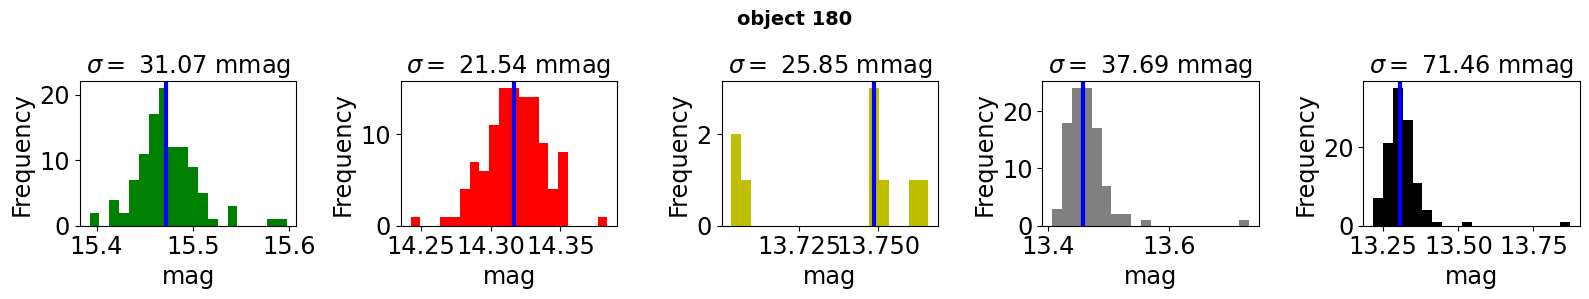

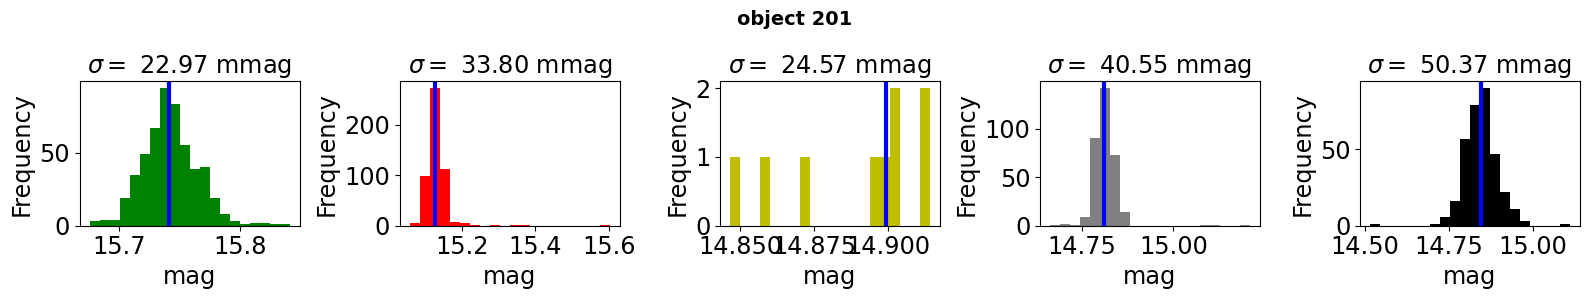

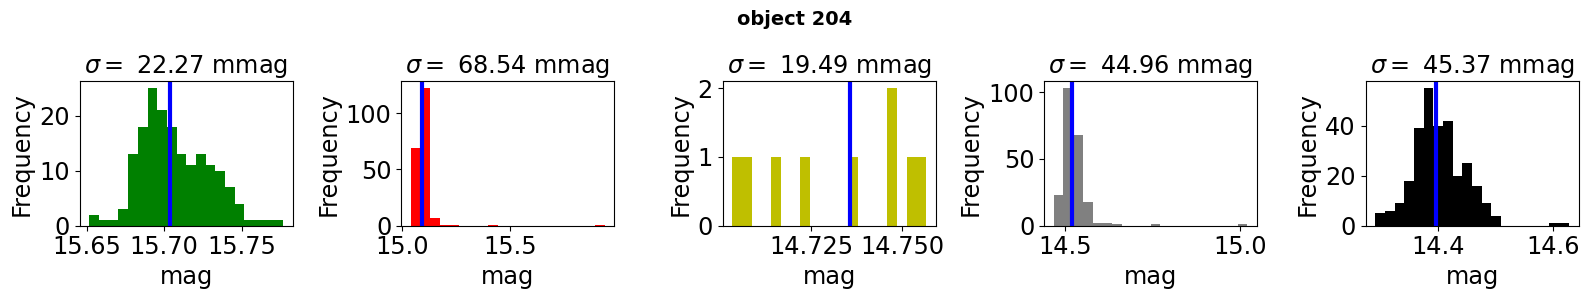

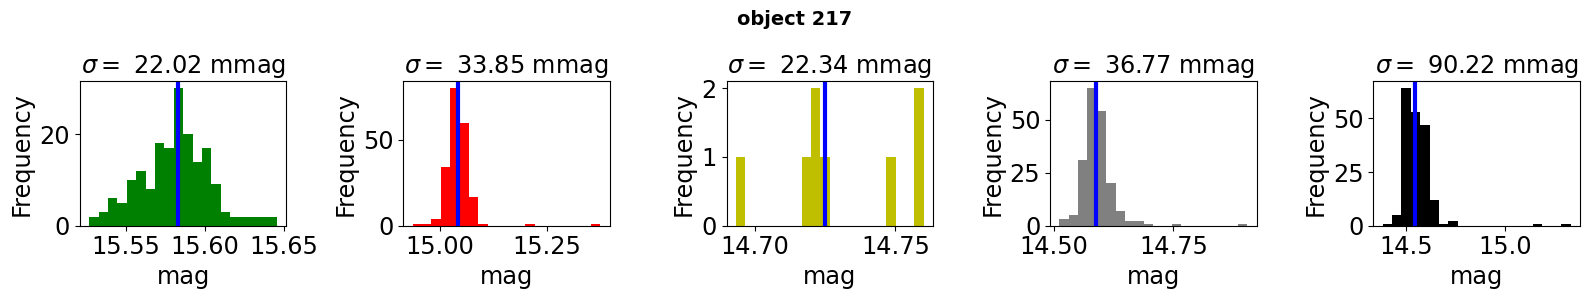

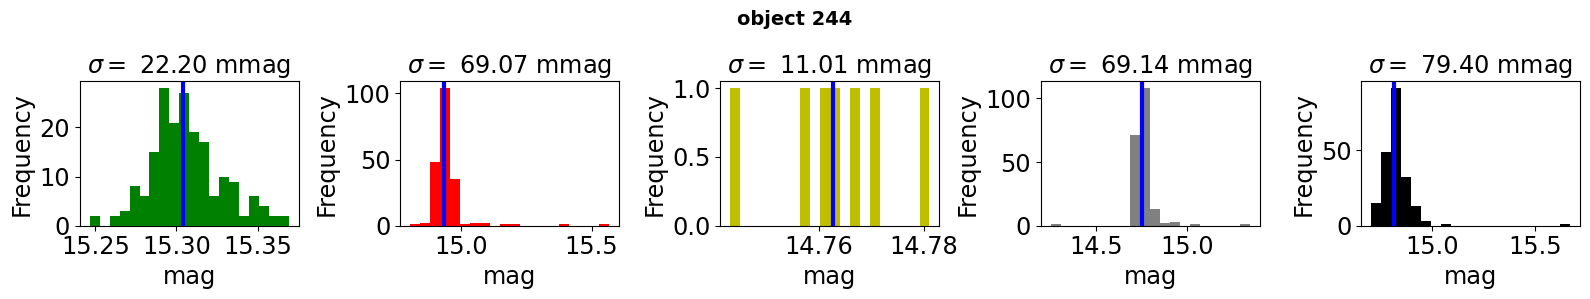

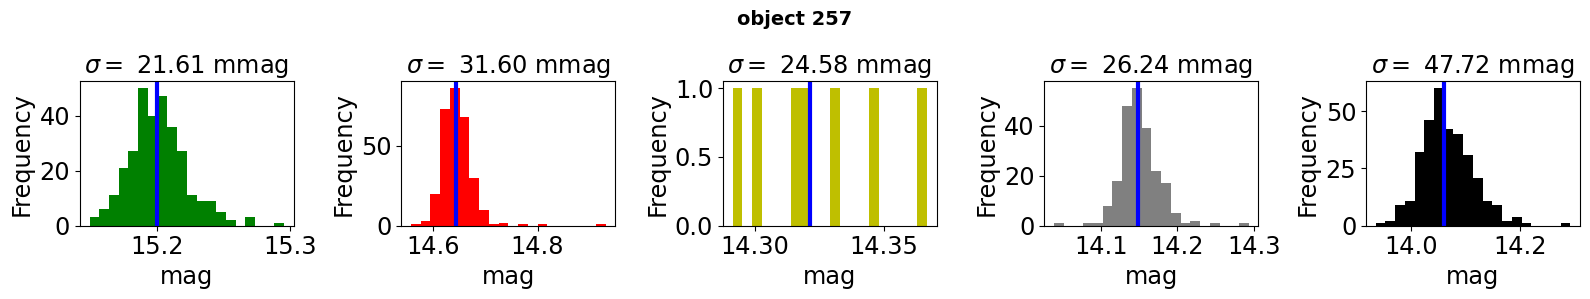

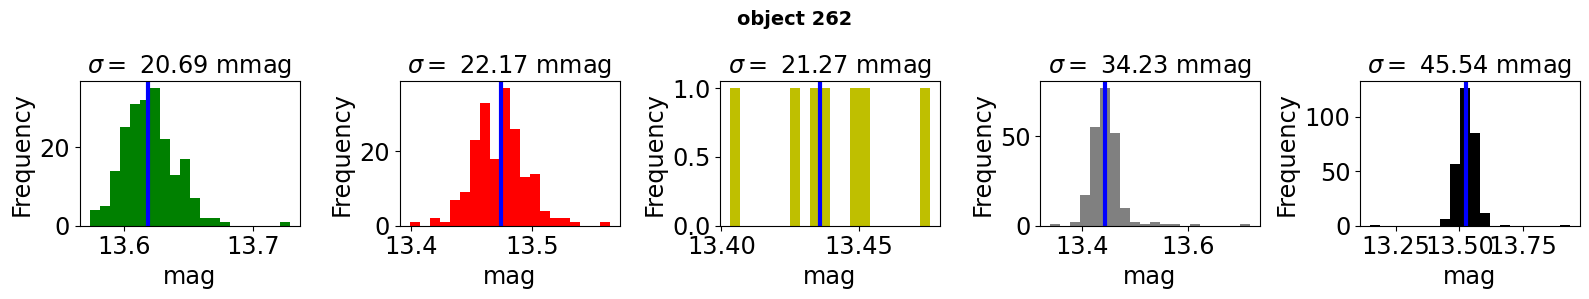

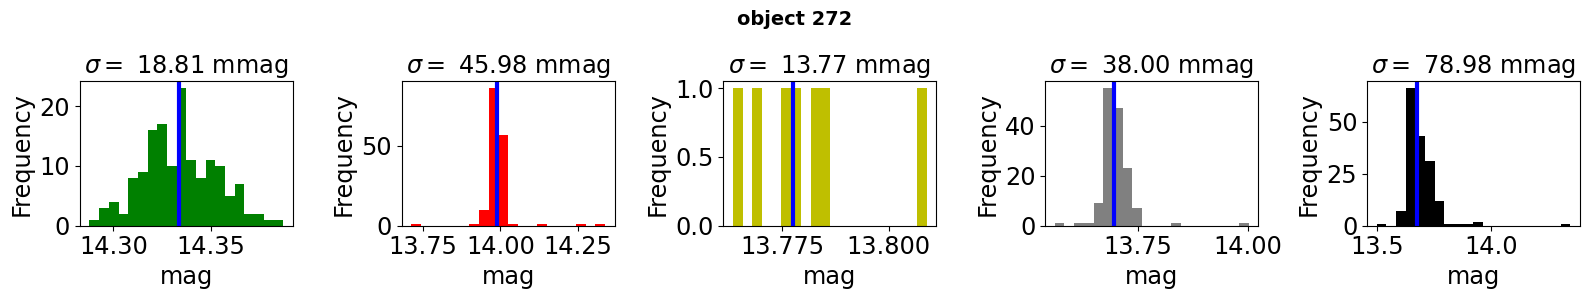

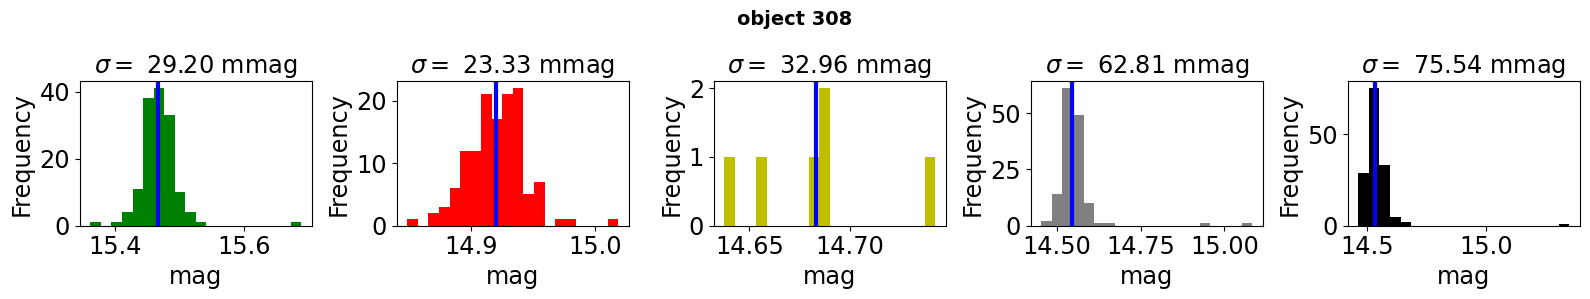

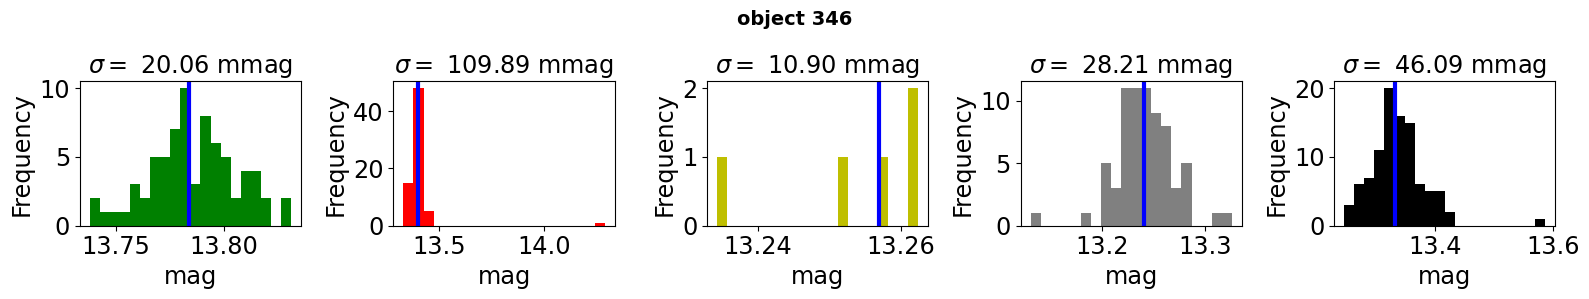

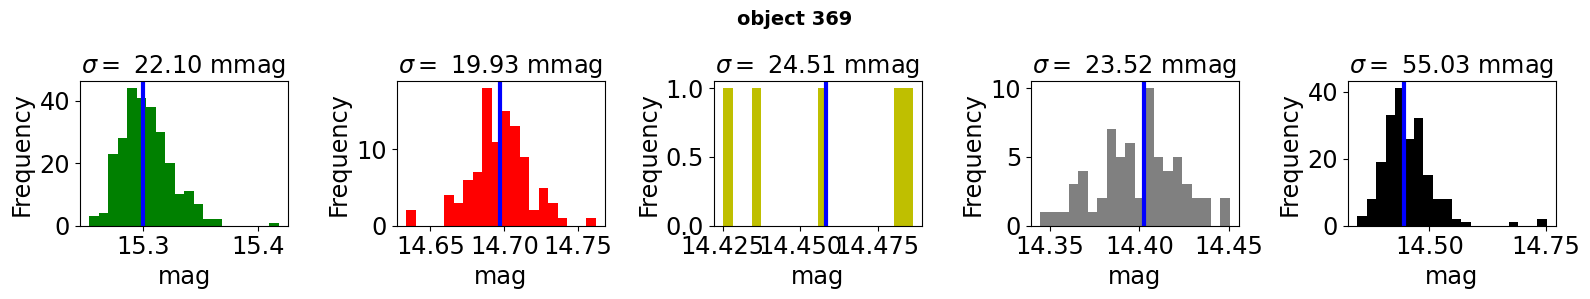

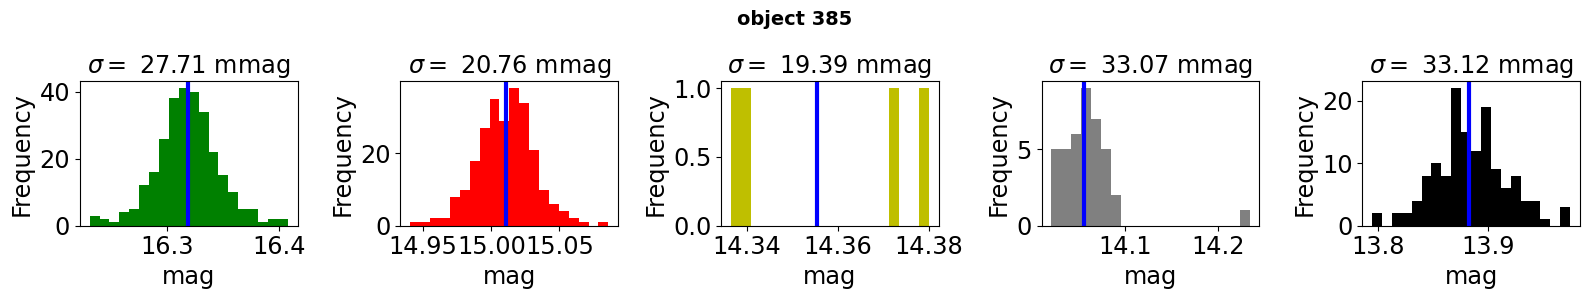

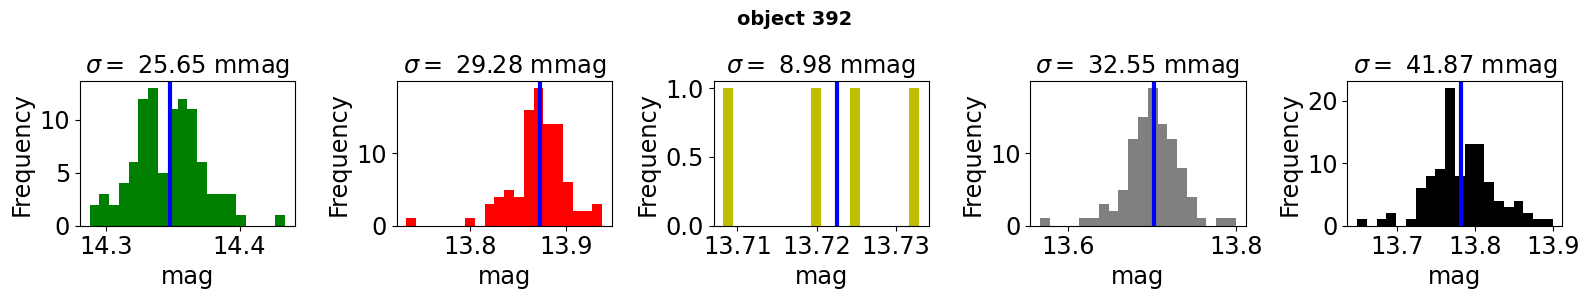

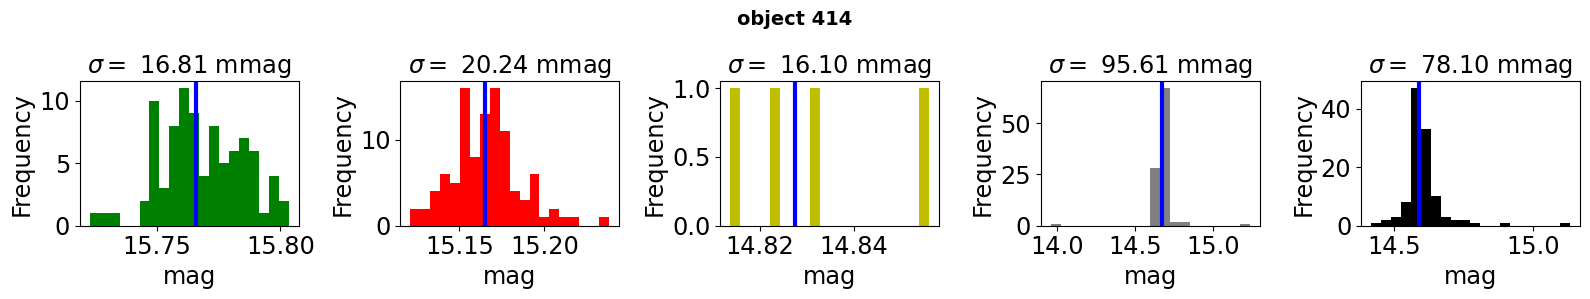

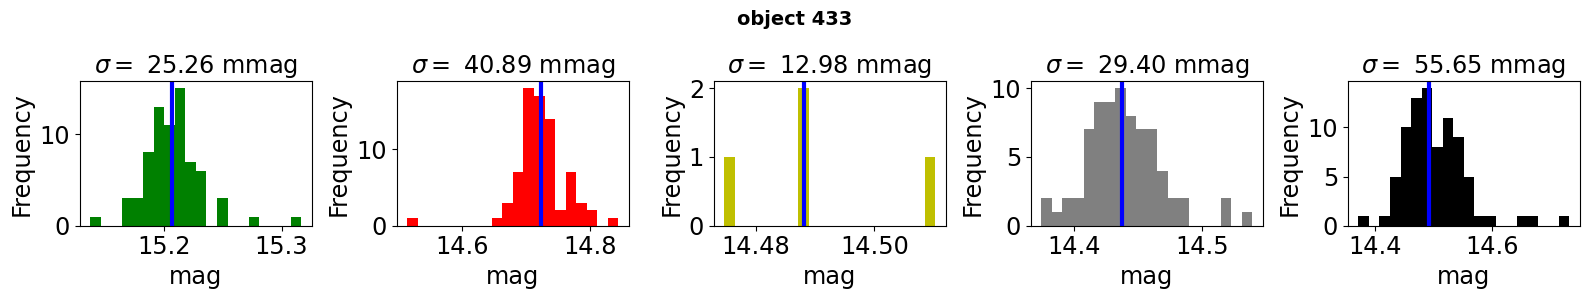

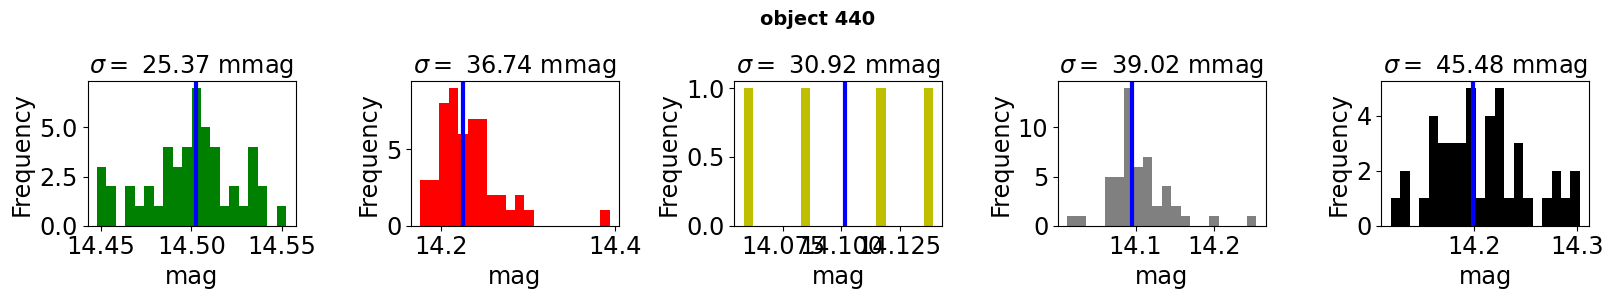

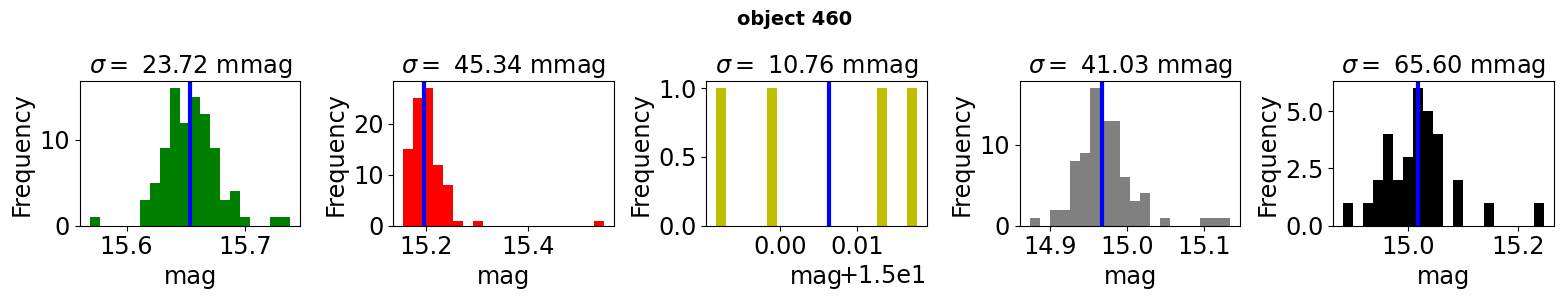

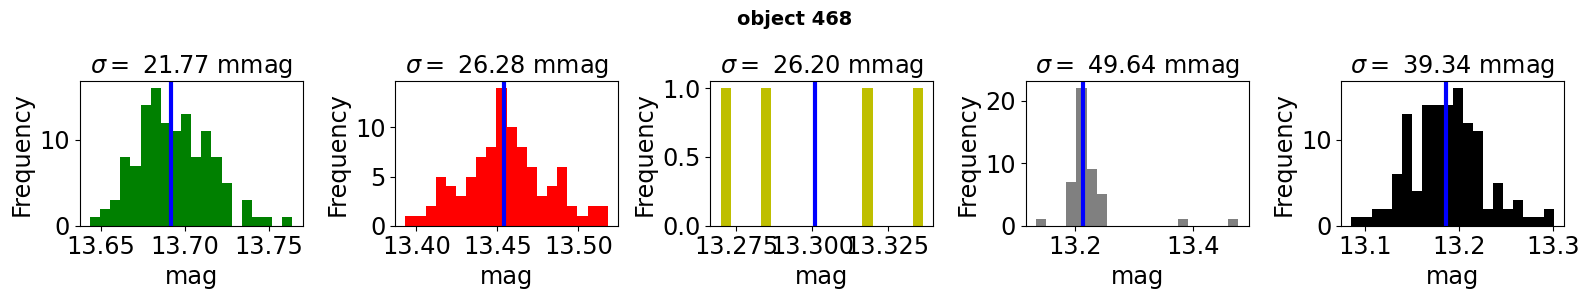

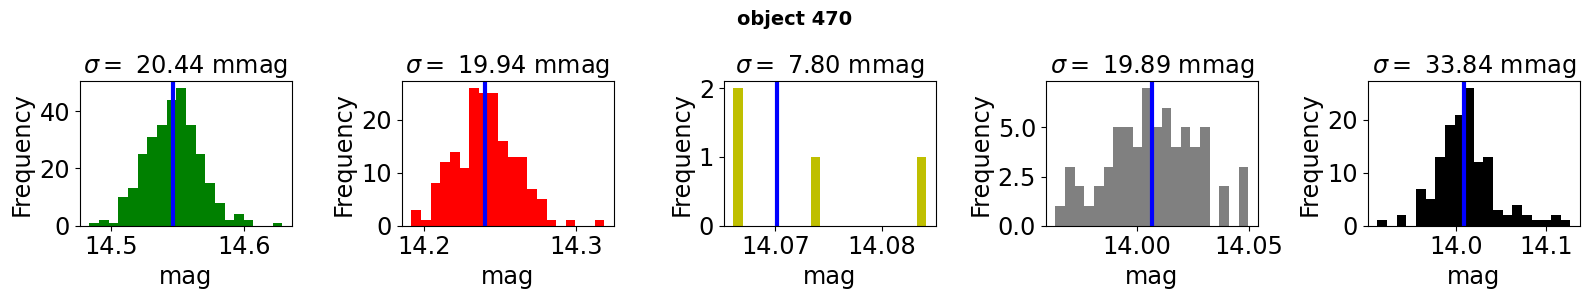

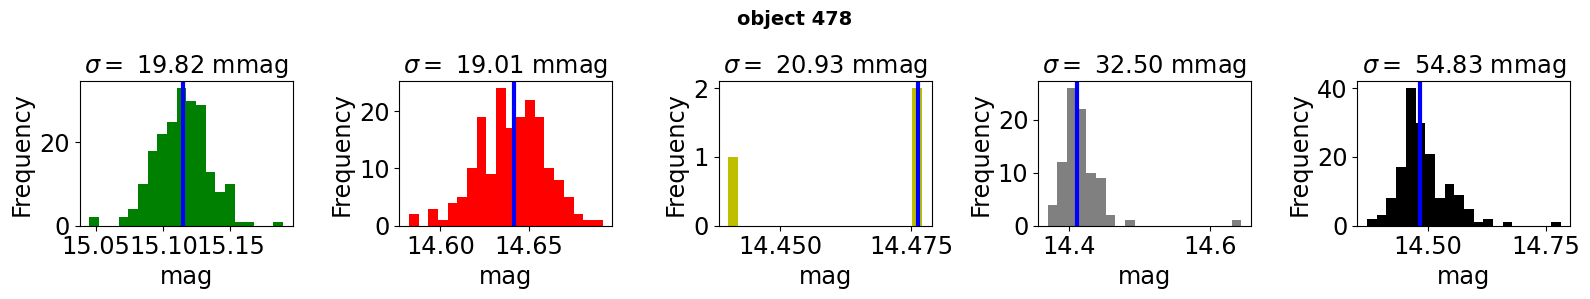

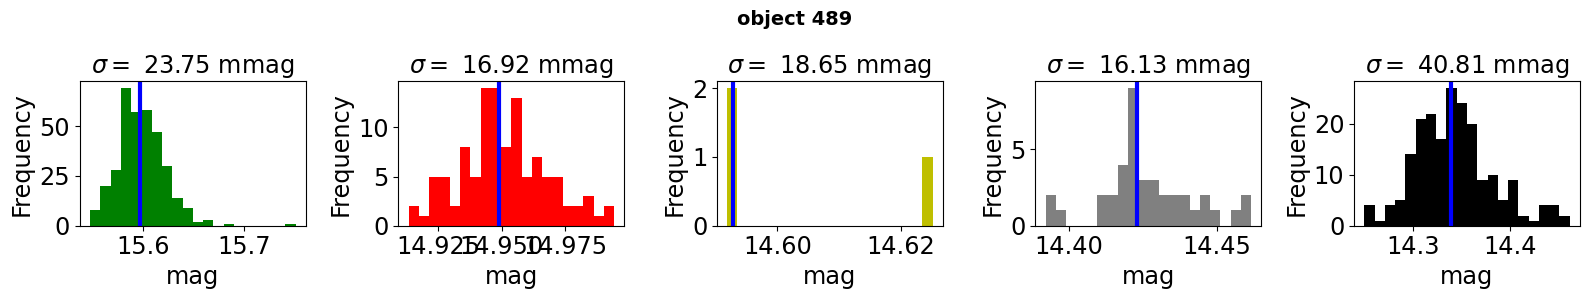

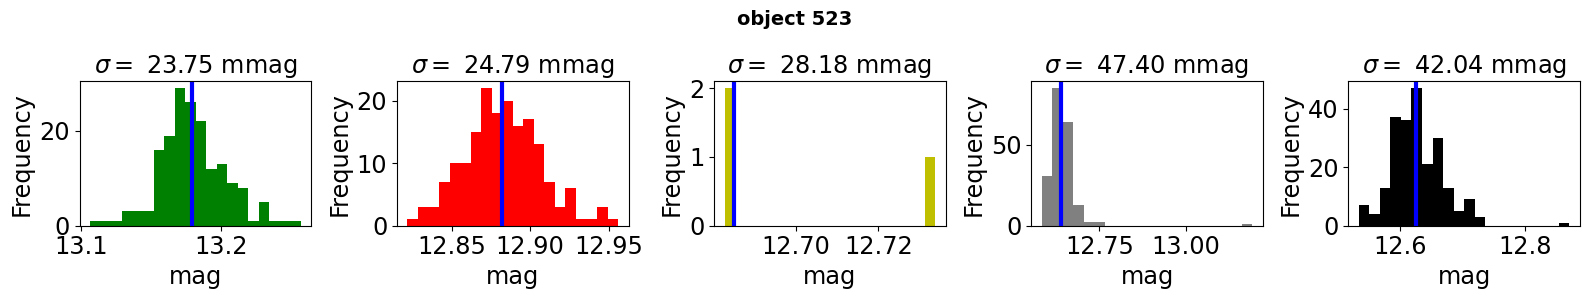

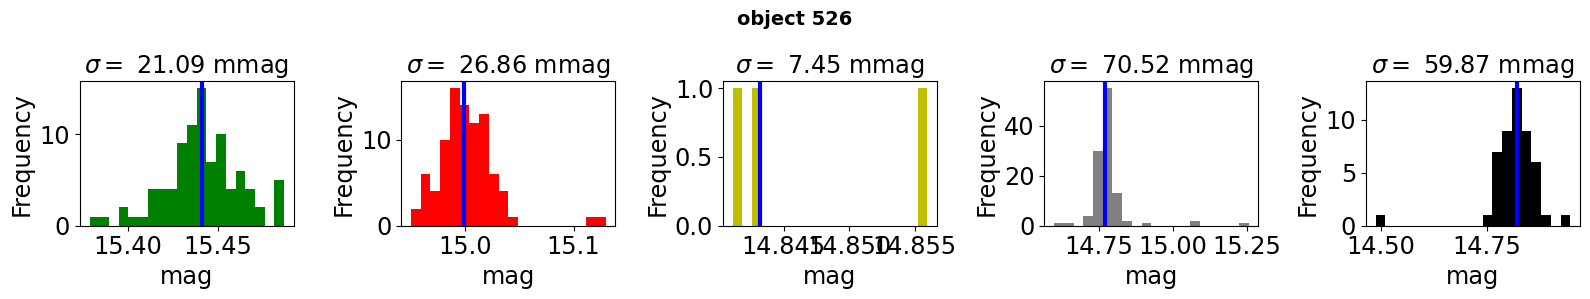

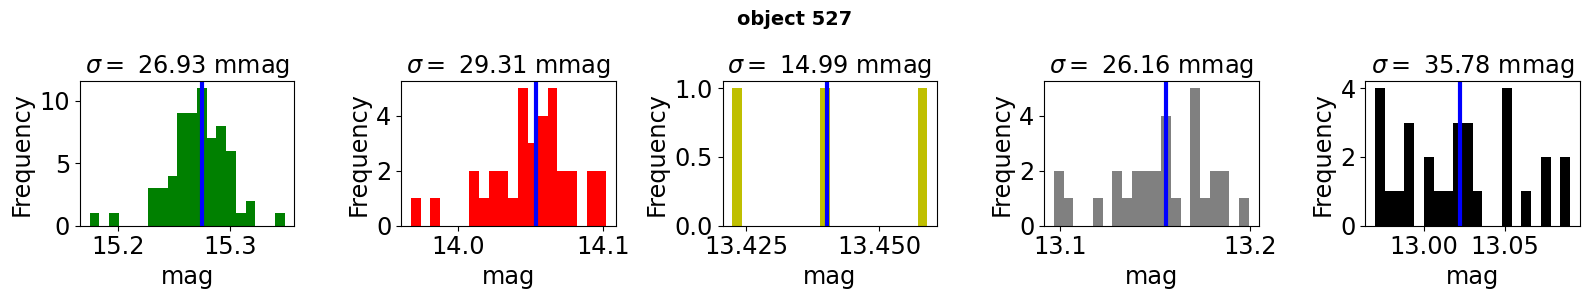

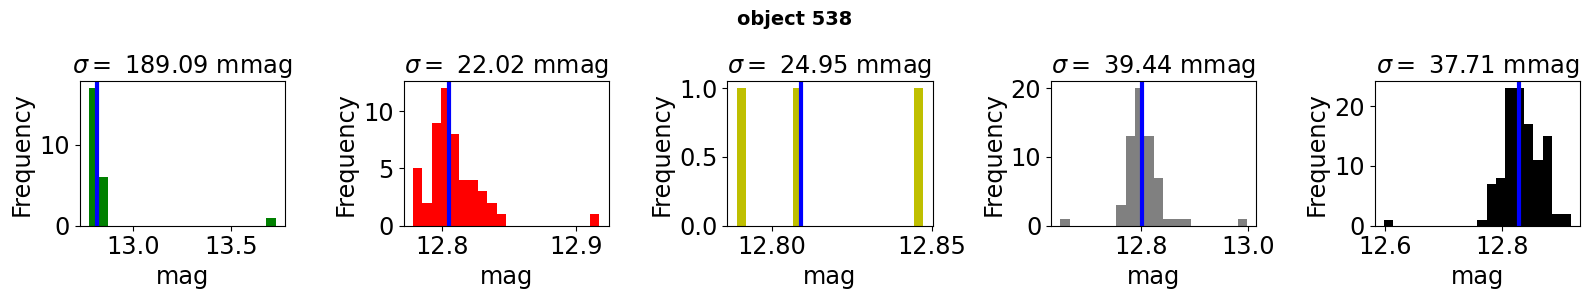

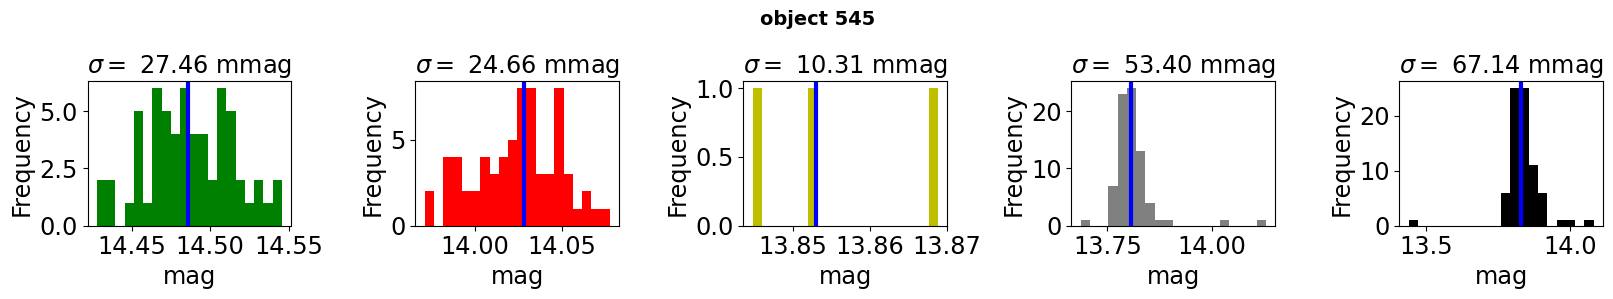

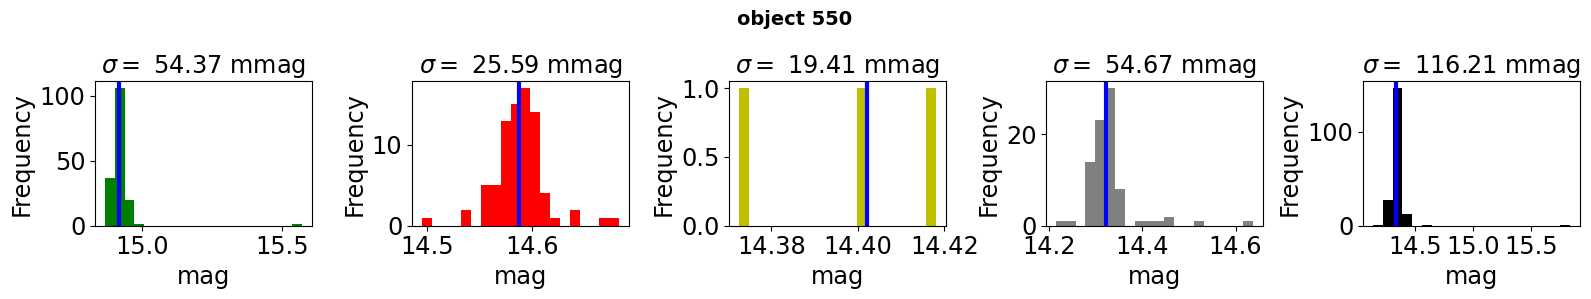

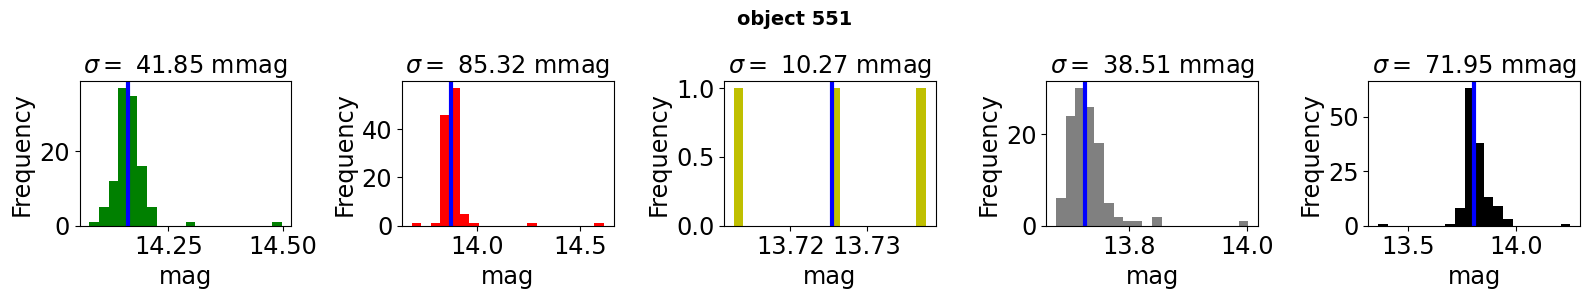

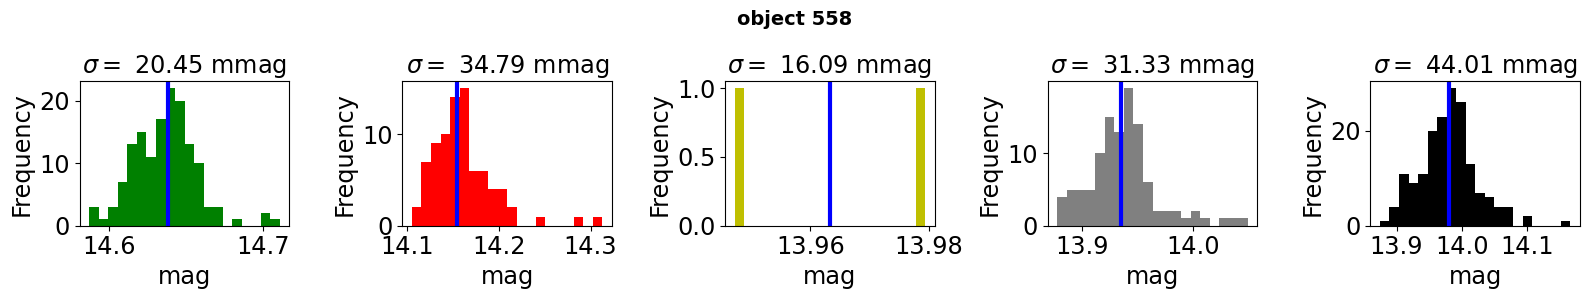

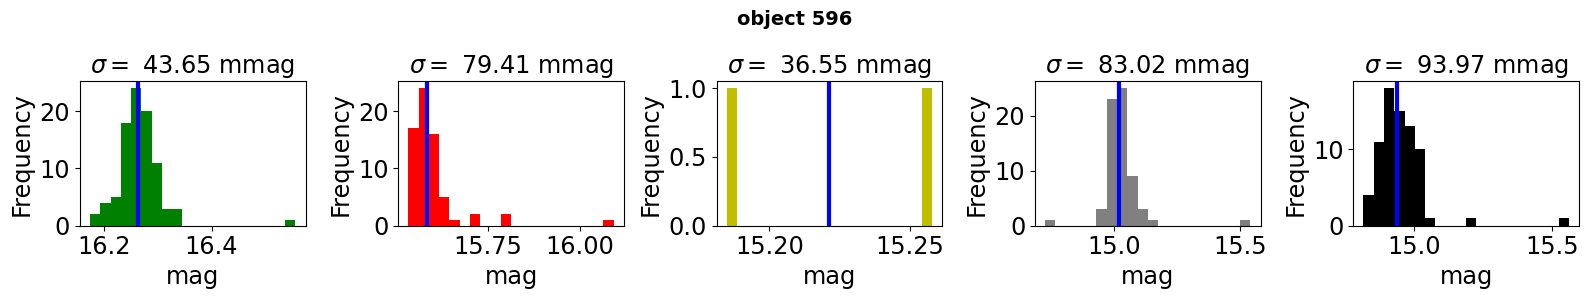

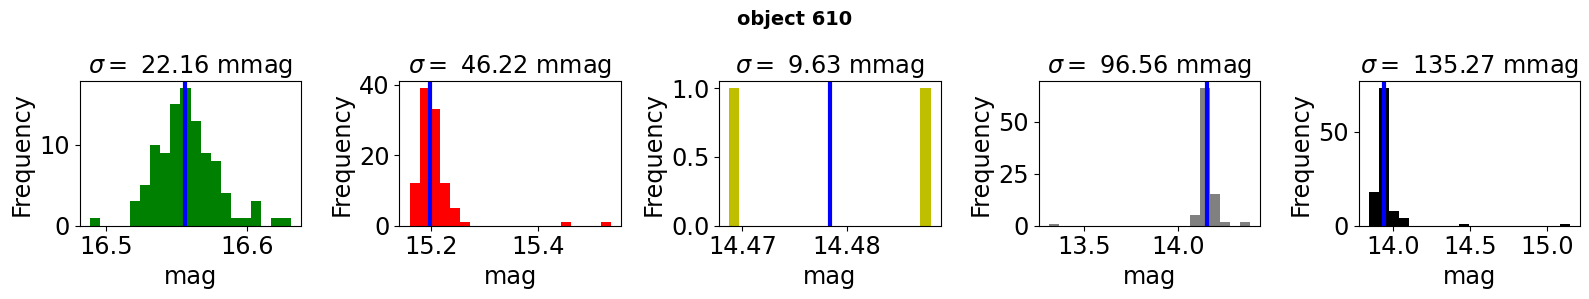

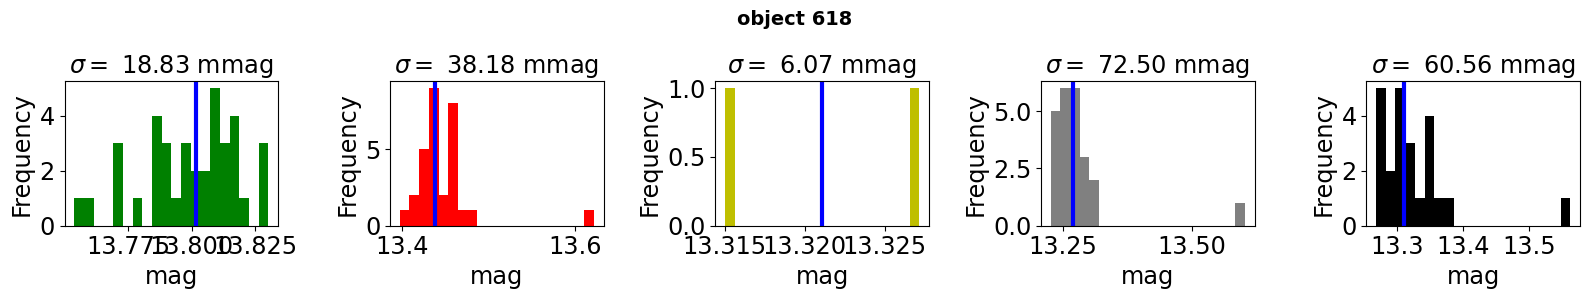

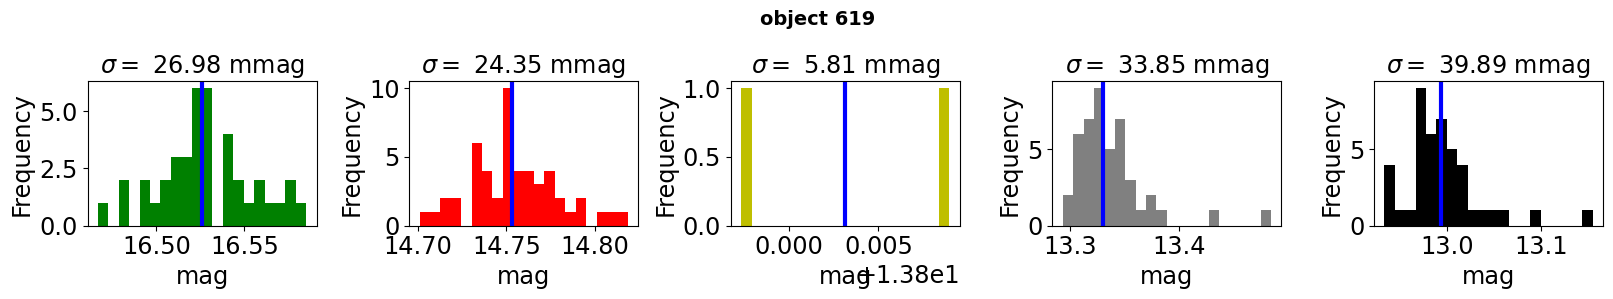

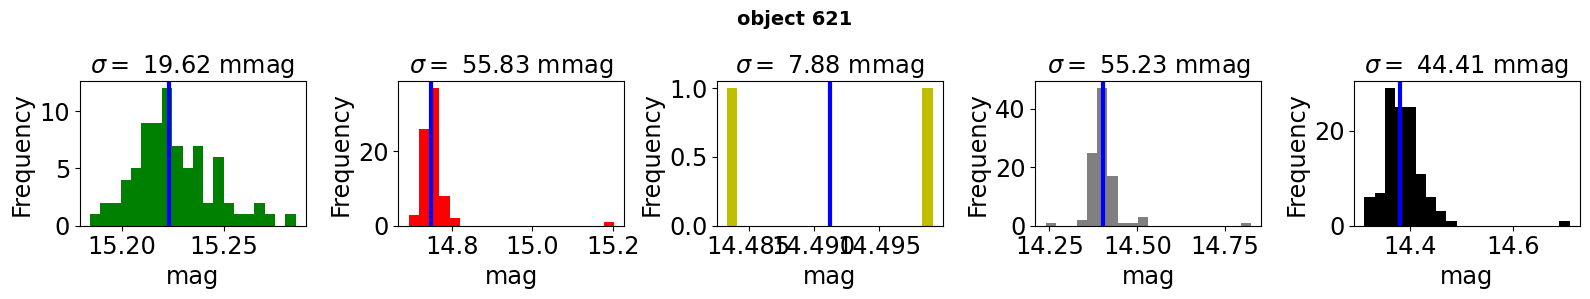

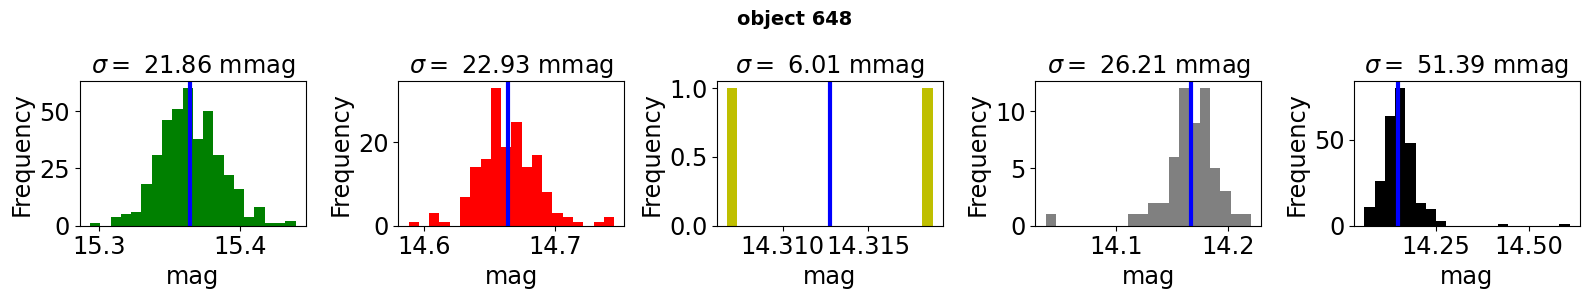

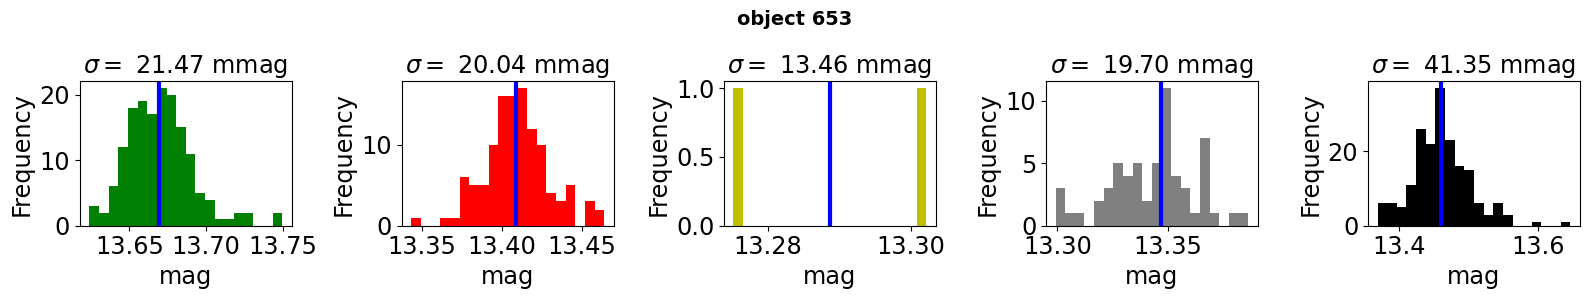

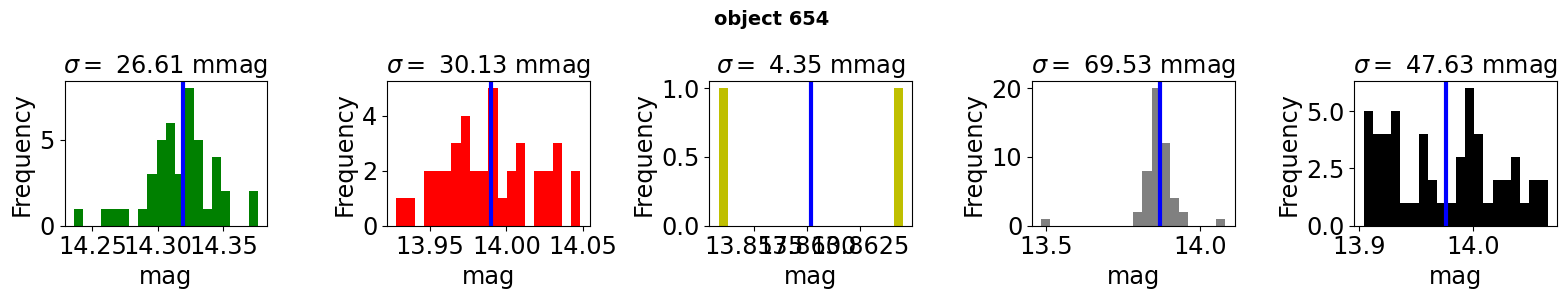

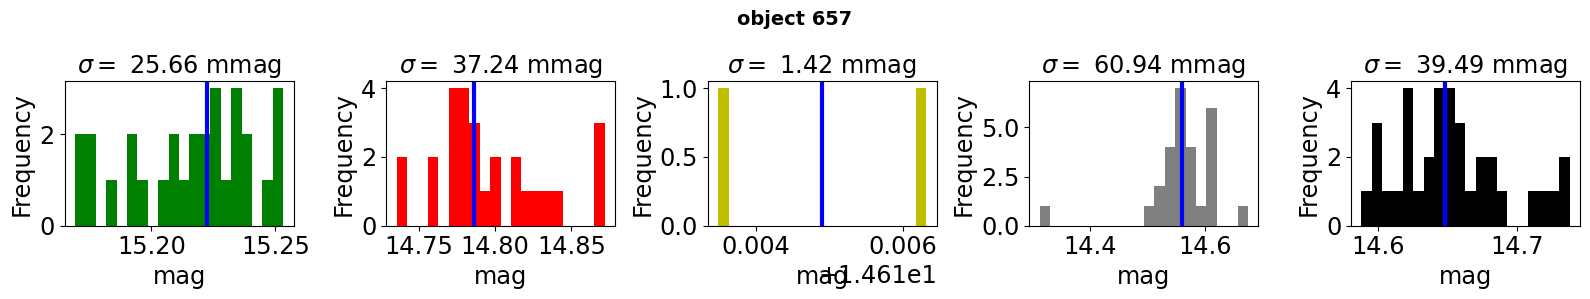

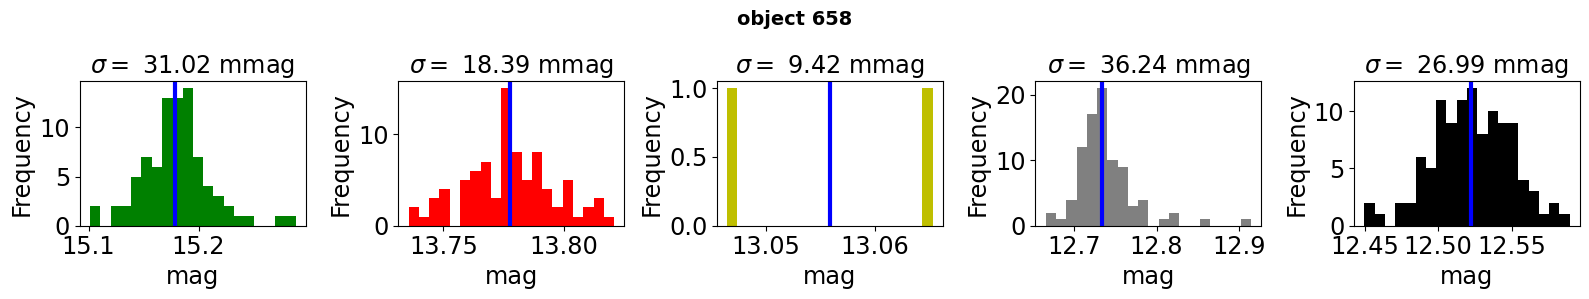

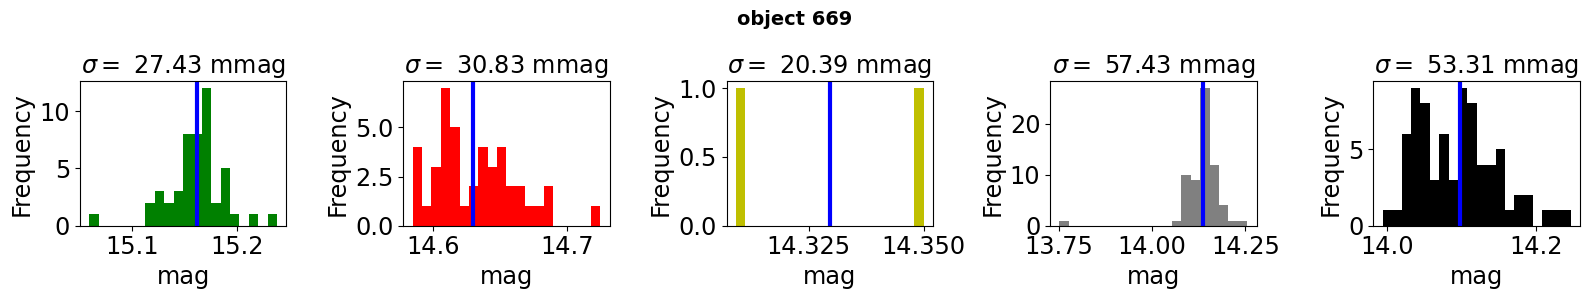

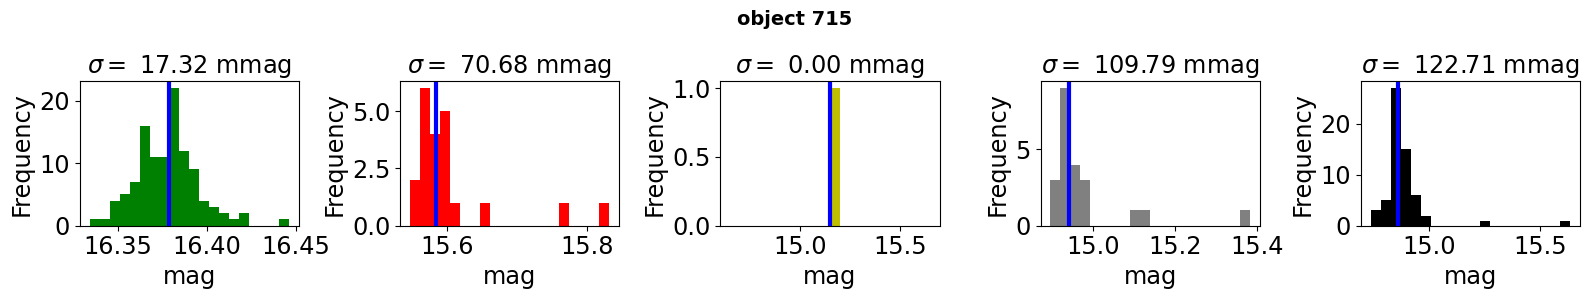

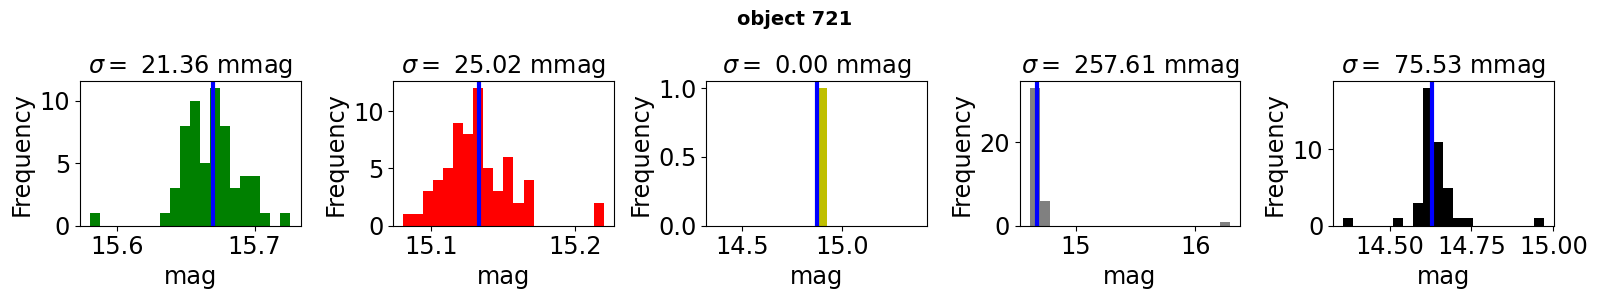

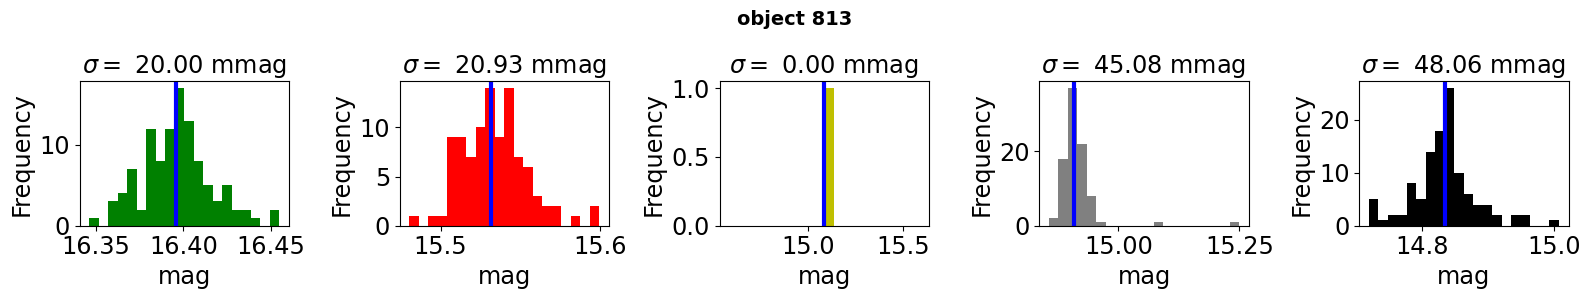

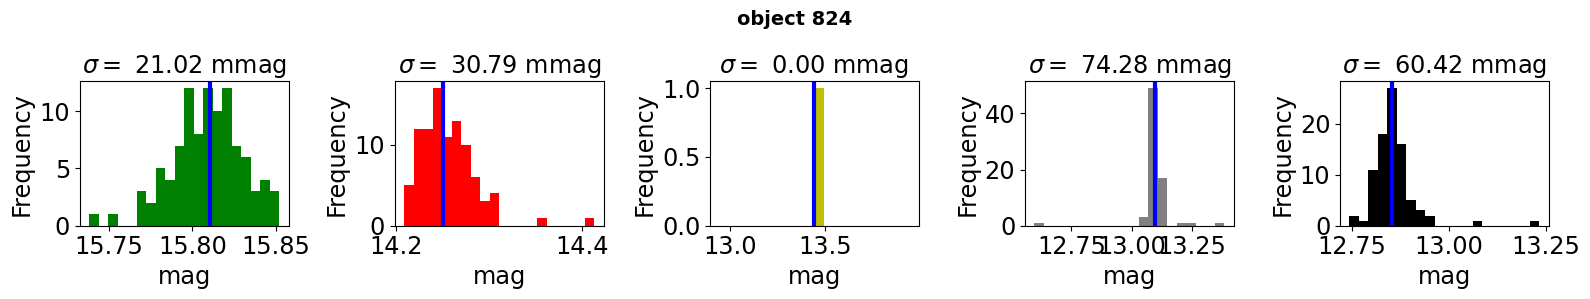

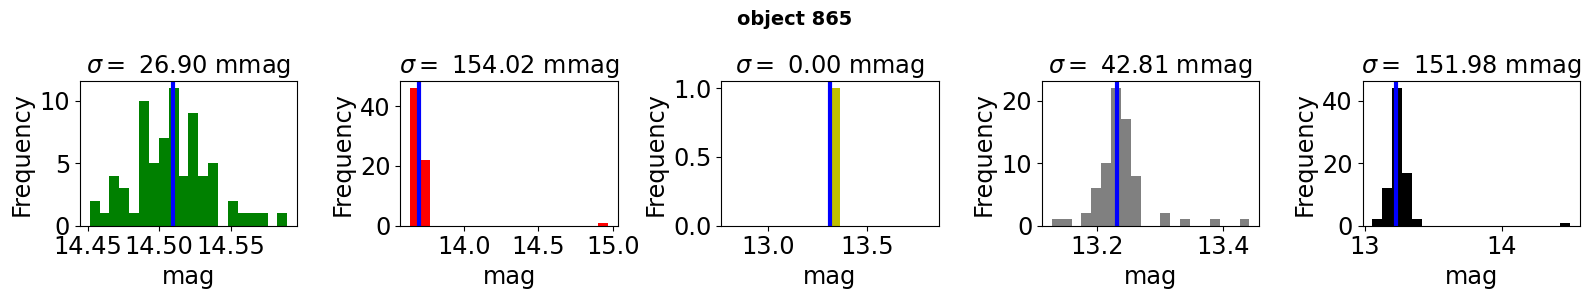

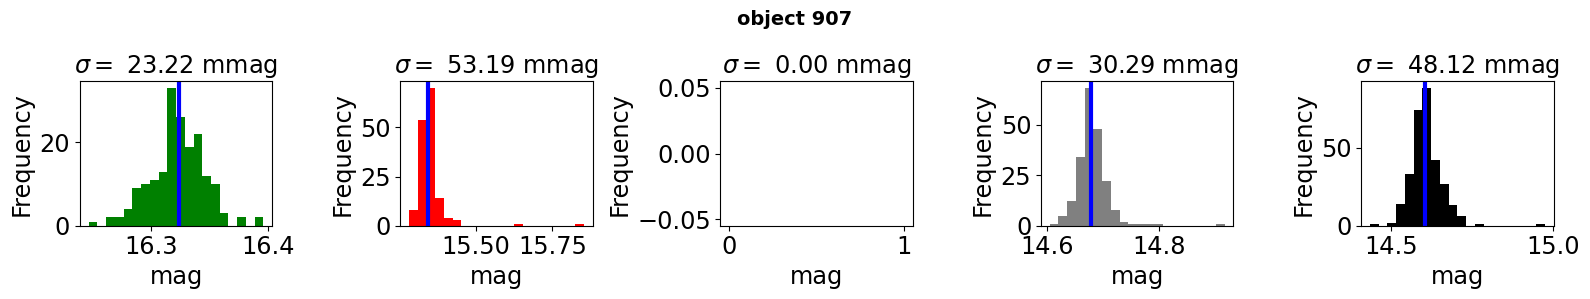

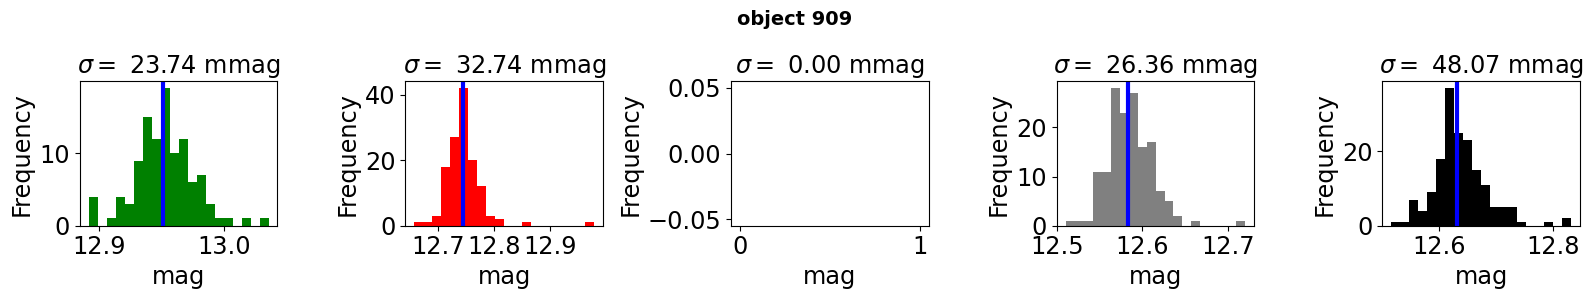

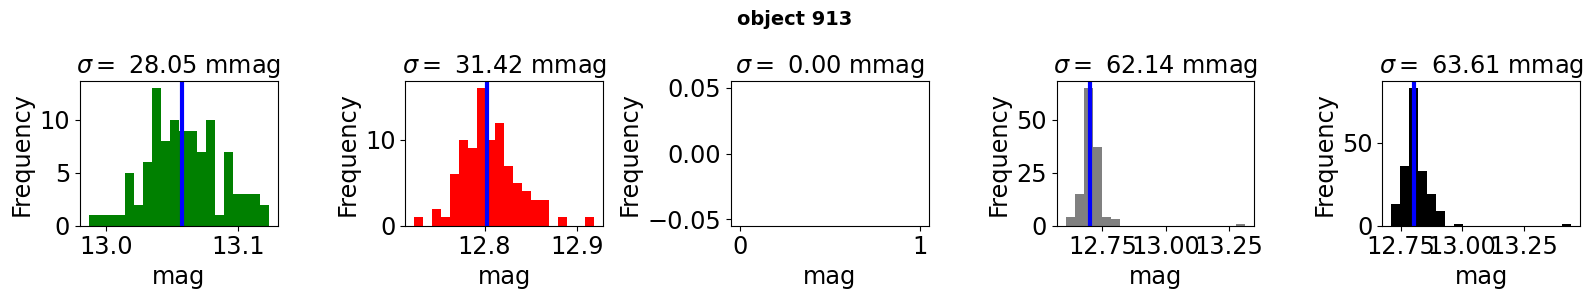

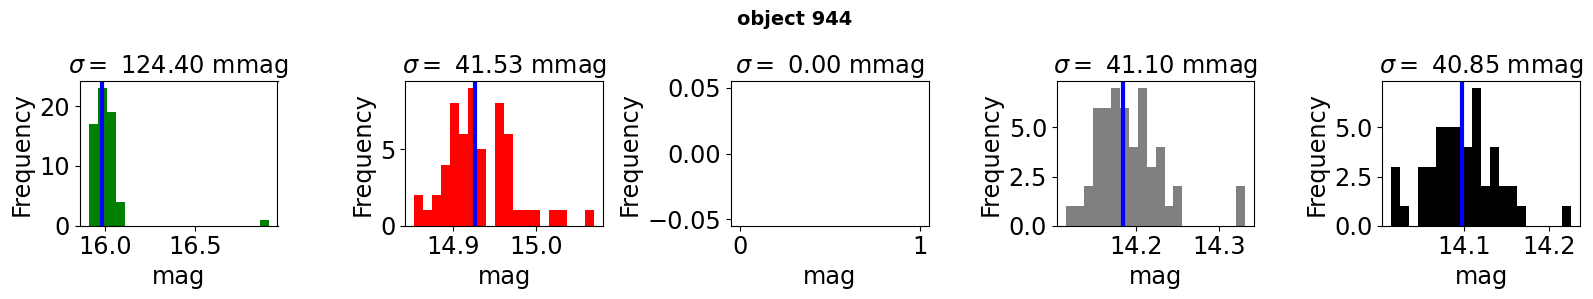

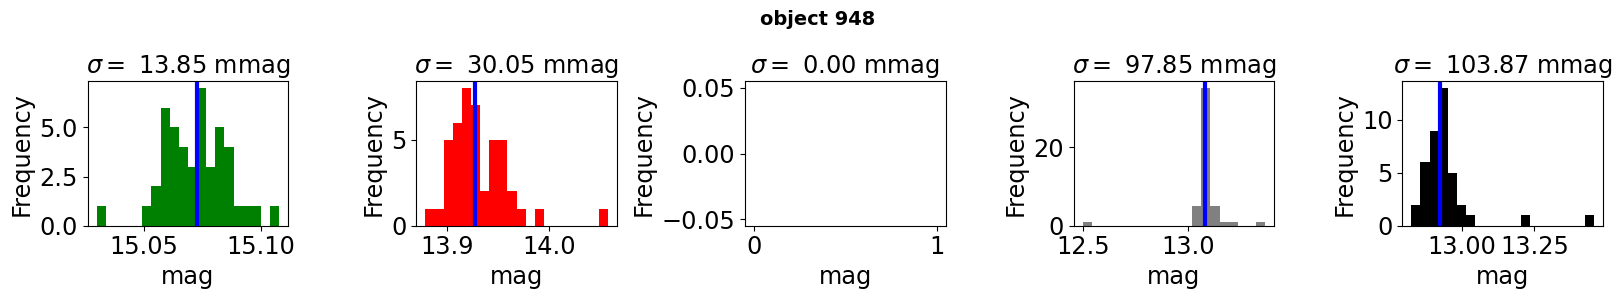

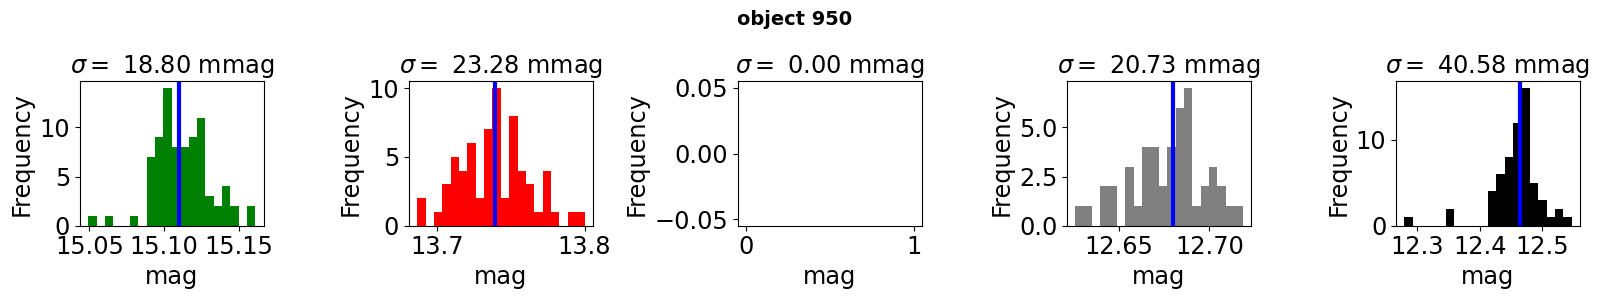

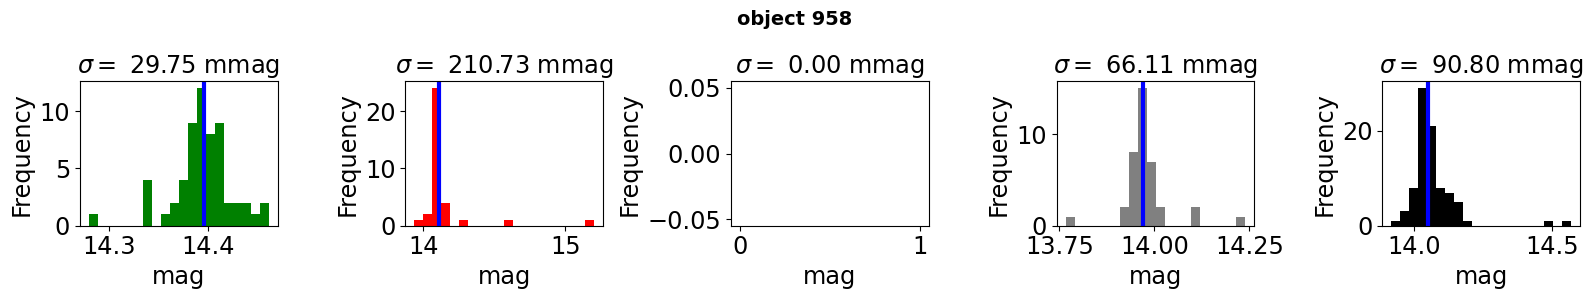

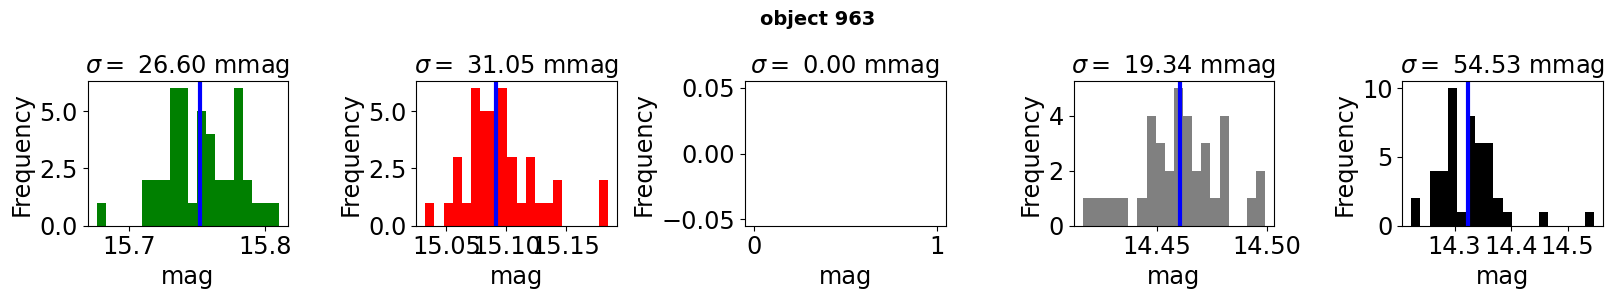

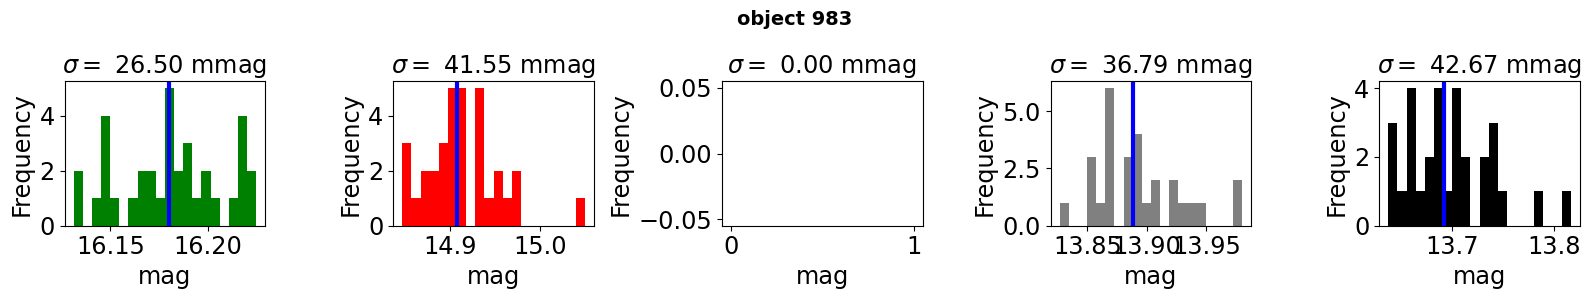

In [32]:
df_col_psf = pd.DataFrame(columns=["obj","ra","dec","g","r","i","z","y","sg","sr","si","sz","sy"])
for index in range(N):
    the_df = all_df[index]
    ra = the_df['ra'].mean()
    dec = the_df['dec'].mean()
    obj=selected_objectnum[index]
    
    plothistogram_valperband(the_df,ctag="psfMag")

    (medg,medr,medi,medz,medy) = get_df_median(the_df,ctag="psfMag")
    (sigg,sigr,sigi,sigz,sigy) = get_df_sigma(the_df,ctag="psfMag")
    df_col_psf.loc[index]=[obj,ra,dec,medg,medr,medi,medz,medy,sigg,sigr,sigi,sigz,sigy]

In [33]:
df_col_psf["g_r"] = df_col_psf["g"]- df_col_psf["r"]
df_col_psf["z_y"] = df_col_psf["z"]- df_col_psf["y"]
df_col_psf["sig_g_r"] = df_col_psf.apply(lambda row: np.sqrt(row["sg"]**2+ row["sr"]**2),axis=1)
df_col_psf["sig_z_y"] = df_col_psf.apply(lambda row: np.sqrt(row["sz"]**2+ row["sy"]**2),axis=1)

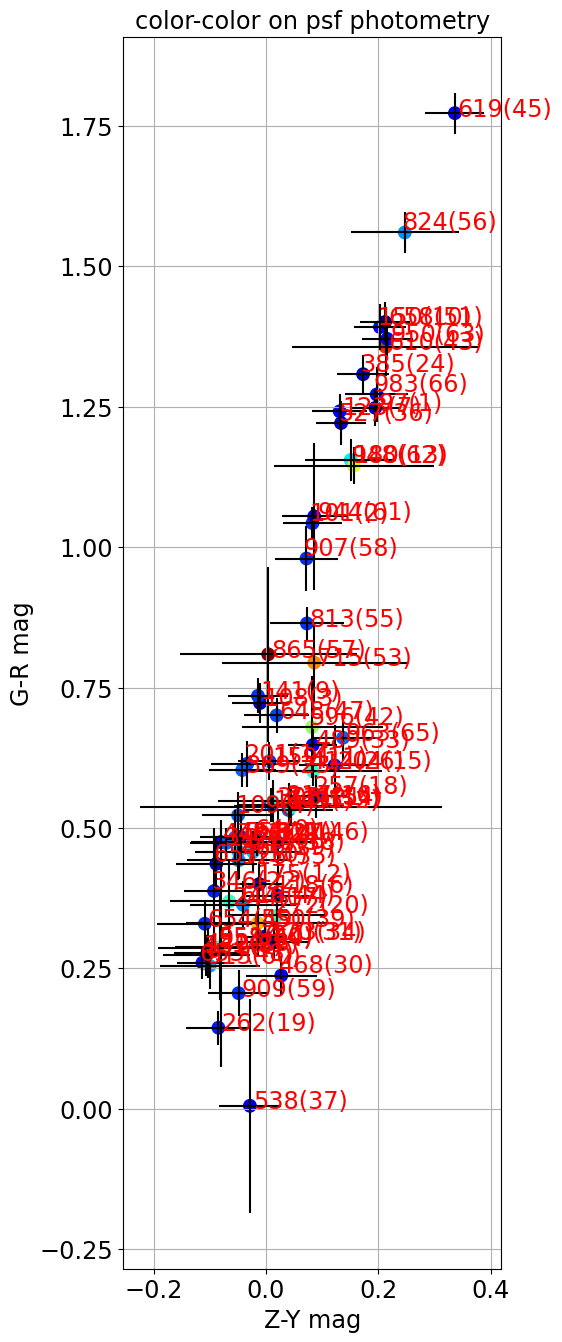

In [34]:
fig,ax = plt.subplots(1,1,figsize=(16,16))
ax.errorbar(df_col_psf["z_y"],df_col_psf["g_r"],xerr=df_col_psf["sig_z_y"] , yerr=df_col_psf["sig_g_r"], fmt=".",color='k',ecolor='k',markersize=1) 
df_col_psf.plot.scatter(x="z_y", y="g_r",marker= "o", s=80,c="sy",cmap="jet",ax=ax,colorbar=False)
ax.set_xlabel("Z-Y mag")
ax.set_ylabel("G-R mag")
ax.set_title("color-color on psf photometry")
ax.set_aspect("equal")
ax.grid()

for index,row in df_col_psf.iterrows():
    idobj = int(row.obj)
    txtlabel = f"{idobj}({index})"
    x = row["z_y"]
    y = row["g_r"]
    if index%2 == 0:
        ax.text(x-0.005,y+.005,txtlabel,size= 'xx-large',color="r")
    else:
        ax.text(x+0.005,y-0.005,txtlabel,size= 'xx-large',color="r")


plt.show()

In [35]:
df_col_psf

obj          ra        dec          g          r          i          z  \
0    64.0  122.458941 -36.203410  15.777671  15.297370  15.071238  14.976903   
1    97.0  122.443240 -36.188544  16.445282  15.197287  14.557551  14.212338   
2   101.0  122.558802 -36.184123  14.703686  13.661007  13.141518  12.923124   
3   108.0  122.476592 -36.168954  13.855750  13.133322  12.888260  12.780897   
4   109.0  122.556549 -36.138404  15.638635  15.116135  14.870493  14.804029   
5   111.0  122.467499 -36.198182  15.854061  15.313057  15.046935  14.935964   
6   118.0  122.565974 -36.177767  15.705004  15.325466  15.108323  15.009150   
7   123.0  122.532136 -36.209821  15.410894  14.169070  13.574203  13.305426   
8   131.0  122.573561 -36.178003  14.336624  14.063165  13.948259  13.957574   
9   141.0  122.513467 -36.199388  15.406302  14.671020  14.384672  14.270638   
10  150.0  122.472447 -36.140298  14.959604  13.567745  12.861611  12.521332   
11  159.0  122.562103 -36.210801  15.829871  15.211116  14.865053  14.740589   
12  175.0  122.423235 -36.188260  15.564385  15.164205  14.966148  14.887449   
13  180.0  122.432446 -36.180699  15.472064  14.316941  13.748660  13.457483   
14  201.0  122.506623 -36.176345  15.740950  15.126634  14.899210  14.811261   
15  204.0  122.506535 -36.145853  15.703485  15.092022  14.735783  14.519253   
16  217.0  122.584368 -36.156101  15.582938  15.043269  14.724720  14.588656   
17  244.0  122.507137 -36.097837  15.304057  14.934850  14.762610  14.752746   
18  257.0  122.476706 -36.132520  15.200161  14.643681  14.321275  14.148869   
19  262.0  122.465052 -36.202206  13.618702  13.474431  13.435971  13.442453   
20  272.0  122.580119 -36.150032  14.333408  13.989265  13.777701  13.695300   
21  308.0  122.412283 -36.186192  15.466608  14.919415  14.683280  14.545968   
22  346.0  122.557610 -36.237342  13.784027  13.396296  13.256942  13.240066   
23  369.0  122.506515 -36.132251  15.300275  14.697178  14.458163  14.402482   
24  385.0  122.442389 -36.177751  16.318742  15.010846  14.355431  14.055205   
25  392.0  122.553480 -36.250530  14.348143  13.873196  13.722605  13.702332   
26  414.0  122.436210 -36.096039  15.765970  15.165334  14.827558  14.674316   
27  433.0  122.603654 -36.202047  15.206659  14.723645  14.488126  14.437266   
28  440.0  122.613746 -36.208324  14.502408  14.225090  14.101803  14.095003   
29  460.0  122.515550 -36.080382  15.653784  15.195910  15.006316  14.967742   
30  468.0  122.467917 -36.243180  13.691614  13.454343  13.300912  13.213640   
31  470.0  122.515905 -36.156007  14.546818  14.240100  14.070187  14.006907   
32  478.0  122.567971 -36.150388  15.114800  14.641627  14.476303  14.411304   
33  489.0  122.531115 -36.162795  15.596581  14.949005  14.592831  14.422978   
34  523.0  122.495355 -36.129917  13.179312  12.881949  12.684986  12.638662   
35  526.0  122.441627 -36.246918  15.441493  14.999119  14.843224  14.772835   
36  527.0  122.535003 -36.256256  15.274288  14.053372  13.440157  13.155631   
37  538.0  122.440301 -36.225329  12.810387  12.805113  12.809050  12.801500   
38  545.0  122.428737 -36.252169  14.485780  14.028413  13.853037  13.807848   
39  550.0  122.447687 -36.220996  14.918729  14.588117  14.402023  14.320583   
40  551.0  122.549266 -36.103293  14.162298  13.874375  13.725381  13.724218   
41  558.0  122.488426 -36.095863  14.638236  14.154163  13.963307  13.935174   
42  596.0  122.510523 -36.109433  16.262683  15.583184  15.221442  15.021664   
43  610.0  122.458961 -36.086389  16.555580  15.199018  14.478390  14.151632   
44  618.0  122.416639 -36.206489  13.801715  13.438432  13.321096  13.269457   
45  619.0  122.379925 -36.183823  16.525764  14.753022  13.803156  13.330204   
46  621.0  122.406516 -36.207939  15.222911  14.748283  14.491244  14.402320   
47  648.0  122.502900 -36.211012  15.364334  14.663867  14.312763  14.167148   
48  653.0  122.544167 -36.219339  13.669059  13.409092  13.288692  13.347085   
49  65

In [36]:
df_col_psf["sizecode"] = (15.5-df_col_psf["z"])*50

In [37]:
N

67

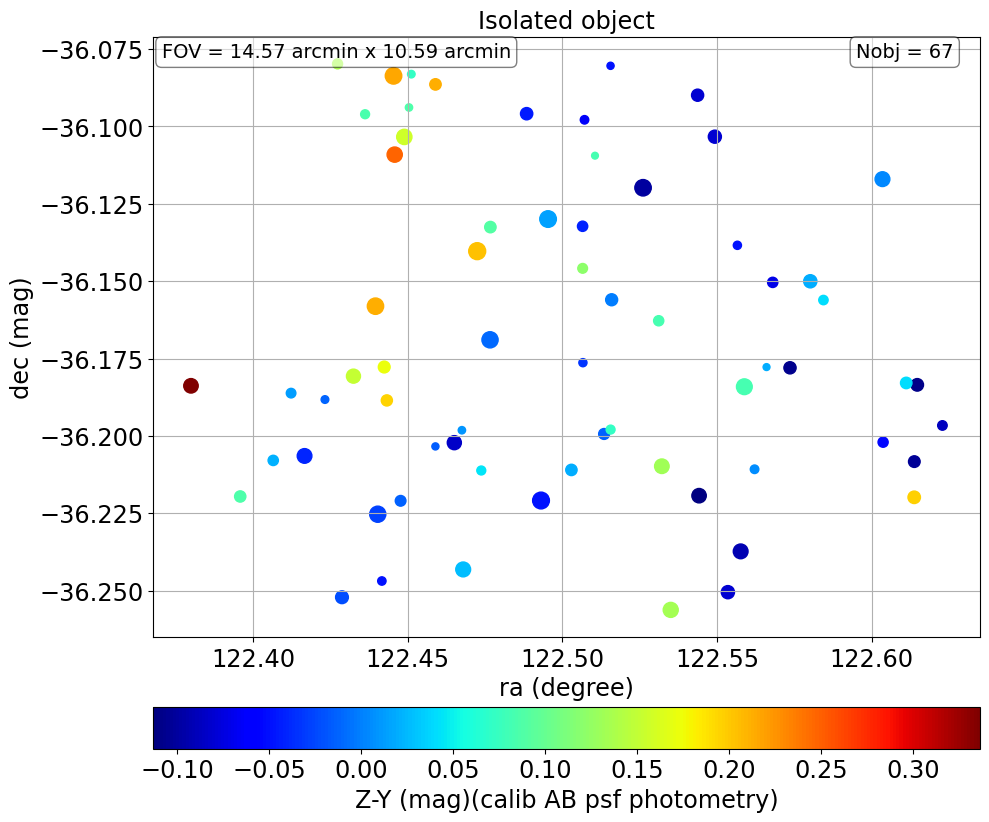

In [38]:
flag_show_numbers = False

fig,ax = plt.subplots(1,1,figsize=(10,12))
df_col_psf.plot.scatter(x="ra", y="dec",marker= "o", s="sizecode",c="z_y",cmap="jet",ax=ax,colorbar=False)
ax.set_xlabel("ra (degree)")
ax.set_ylabel("dec (mag)")
ax.set_title("Isolated object")
ax.set_aspect("equal")
ax.grid()

cbar = plt.colorbar(ax.collections[0],ax=ax,orientation = 'horizontal',shrink=1.0,pad=0.06)
cbar.ax.set_xlabel('Z-Y (mag)(calib AB psf photometry)', rotation=0)

if flag_show_numbers:
    for index,row in df_col_psf.iterrows():
        idobj = int(row.obj)
        x = row["ra"]
        y = row["dec"]
        if index%2 == 0:
            ax.text(x-0.002,y+.002,str(idobj),size= 'x-large')
        else:
            ax.text(x+0.002,y-0.002,str(idobj),size= 'x-large')

ax.text(0.01, 0.99, textstr, transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
ax.text(0.85, 0.99, f"Nobj = {N}", transform=ax.transAxes, fontsize=14,verticalalignment='top', bbox=props)
plt.tight_layout()
plt.show()

## Save file

In [39]:
df_obj_colors = pd.merge(left=df_col_psf,right=df_col_ap,on="obj",suffixes=("_psf","_ap"))

In [40]:
df_obj_colors.to_csv("isolated_objects_magandcolors_psfap_good.csv")

## Check the difference between the PSF and Aperture fluxes - mags - colors 2024-09-09

In [41]:
df_obj_colors.head()

obj      ra_psf    dec_psf      g_psf      r_psf      i_psf      z_psf  \
0   64.0  122.458941 -36.203410  15.777671  15.297370  15.071238  14.976903   
1   97.0  122.443240 -36.188544  16.445282  15.197287  14.557551  14.212338   
2  101.0  122.558802 -36.184123  14.703686  13.661007  13.141518  12.923124   
3  108.0  122.476592 -36.168954  13.855750  13.133322  12.888260  12.780897   
4  109.0  122.556549 -36.138404  15.638635  15.116135  14.870493  14.804029   

       y_psf    sg_psf    sr_psf    si_psf    sz_psf    sy_psf   g_r_psf  \
0  14.992762  0.021693  0.020236  0.014894  0.029471  0.046151  0.480301   
1  14.017652  0.025860  0.020512  0.019148  0.028628  0.033561  1.247996   
2  12.840352  0.020974  0.018582  0.014720  0.020080  0.048411  1.042680   
3  12.791457  0.024153  0.025324  0.022349  0.034595  0.035739  0.722428   
4  14.853749  0.021991  0.034464  0.016708  0.034313  0.054719  0.522499   

    z_y_psf  sig_g_r_psf  sig_z_y_psf  sizecode_psf       ra_ap     dec_ap  \
0 -0.015859     0.029666     0.054758     26.154859  122.458941 -36.203410   
1  0.194686     0.033007     0.044113     64.383116  122.443240 -36.188544   
2  0.082771     0.028022     0.052410    128.843809  122.558802 -36.184123   
3 -0.010560     0.034995     0.049740    135.955134  122.476592 -36.168954   
4 -0.049720     0.040882     0.064588     34.798528  122.556549 -36.138404   

        g_ap       r_ap       i_ap       z_ap       y_ap     sg_ap     sr_ap  \
0  15.769230  15.281390  15.056974  14.963003  14.966046  0.017832  0.014519   
1  16.446902  15.189414  14.539192  14.201647  14.012256  0.026035  0.013548   
2  14.686563  13.639592  13.118162  12.903610  12.811501  0.013577  0.009354   
3  13.846352  13.121422  12.864263  12.767248  12.786835  0.009785  0.011736   
4  15.635070  15.113755  14.866761  14.807542  14.857429  0.018663  0.015409   

      si_ap     sz_ap     sy_ap    g_r_ap    z_y_ap  sig_g_r_ap  sig_z_y_ap  \
0  0.015810  0.016177  0.042327  0.487840 -0.003043    0.022995    0.045314   
1  0.012467  0.012377  0.031766  1.257489  0.189391    0.029349    0.034092   
2  0.016151  0.011592  0.034385  1.046971  0.092109    0.016488    0.036287   
3  0.017851  0.010746  0.029535  0.724930 -0.019587    0.015280    0.031429   
4  0.016658  0.019196  0.050737  0.521315 -0.049887    0.024203    0.054246   

   sizecode_ap  
0    53.699653  
1   129.835278  
2   259.639010  
3   273.275198  
4    69.245797

In [42]:
df_obj_colors["g_psf_ap"] = (df_obj_colors['g_psf'] - df_obj_colors['g_ap'])*1000. 
df_obj_colors["r_psf_ap"] = (df_obj_colors['r_psf'] - df_obj_colors['r_ap'])*1000.  
df_obj_colors["i_psf_ap"] = (df_obj_colors['i_psf'] - df_obj_colors['i_ap'])*1000.  
df_obj_colors["z_psf_ap"] = (df_obj_colors['z_psf'] - df_obj_colors['z_ap'])*1000.  
df_obj_colors["y_psf_ap"] = (df_obj_colors['y_psf'] - df_obj_colors['y_ap'])*1000.  
df_obj_colors["gr_psf_ap"] = (df_obj_colors['g_r_psf'] - df_obj_colors['g_r_ap'])*1000.  
df_obj_colors["zy_psf_ap"] = (df_obj_colors['z_y_psf'] - df_obj_colors['z_y_ap'])*1000.  

In [43]:
list_of_variables = [ "g_psf_ap", "r_psf_ap","i_psf_ap","z_psf_ap","y_psf_ap", "gr_psf_ap","zy_psf_ap"]
Nvars = len(list_of_variables)
ncols = 2
nrows = int(np.ceil((Nvars/ncols)))

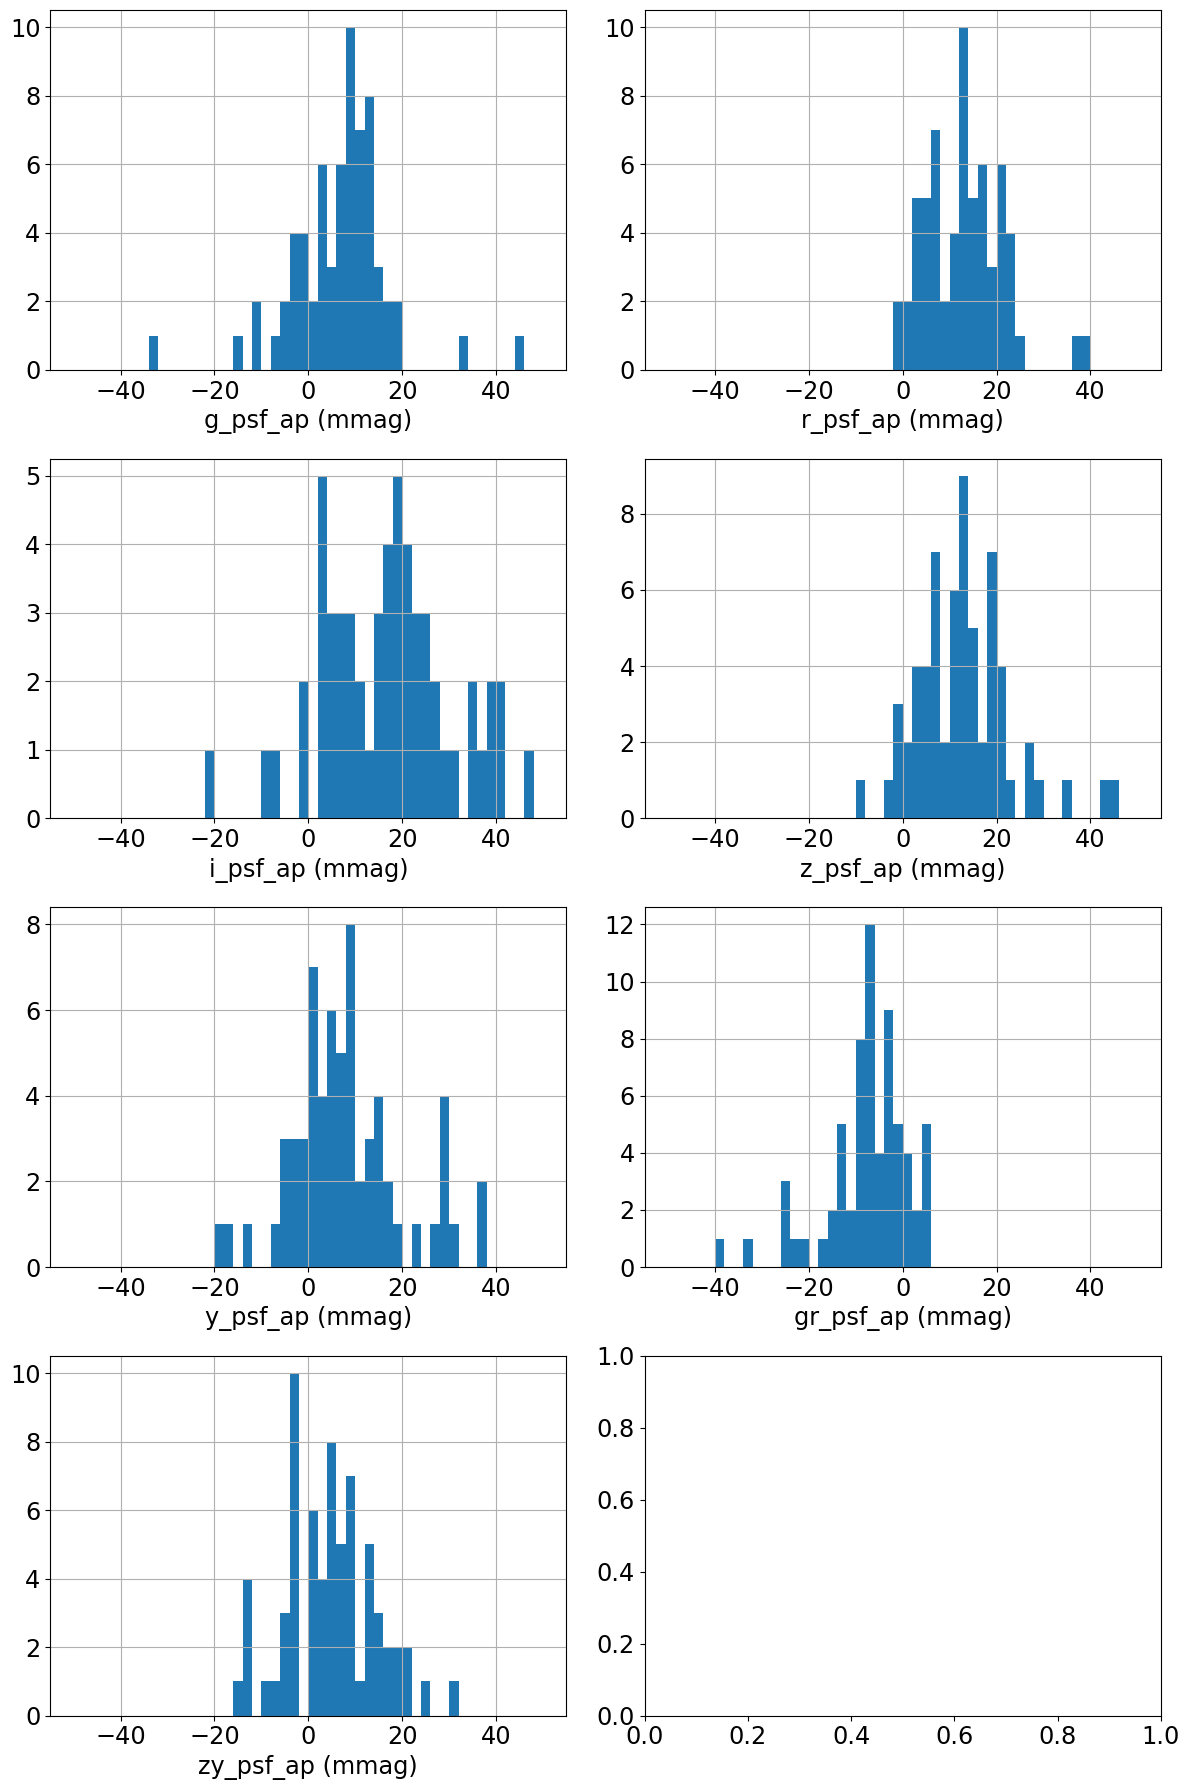

In [44]:
fig,axs = plt.subplots(nrows,ncols,figsize=(12,18))
ax = axs.flatten()

for idx,var in enumerate(list_of_variables):
    df_obj_colors[var].hist(bins=50,range=(-50,50),ax=ax[idx],label=True)
    ax[idx].set_xlabel(var + " (mmag)")

plt.tight_layout()
plt.show()

<Axes: >

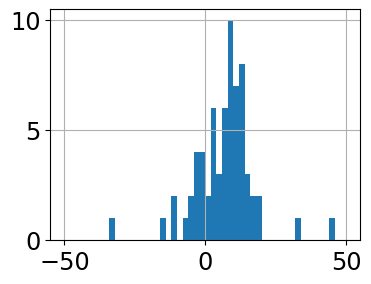

In [45]:
df_obj_colors["g_psf_ap"].hist(bins=50,range=(-50,50))

<Axes: >

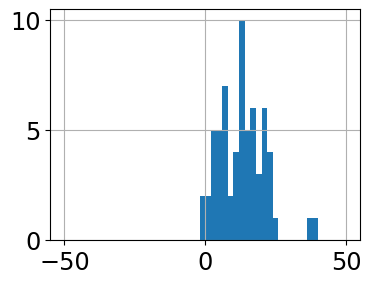

In [46]:
df_obj_colors["r_psf_ap"].hist(bins=50,range=(-50,50))

<Axes: >

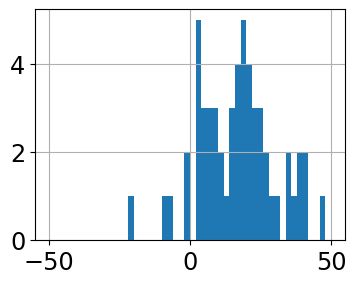

In [47]:
df_obj_colors["i_psf_ap"].hist(bins=50,range=(-50,50))